In [1]:
#Jump to: Maximizing/Matching CONTROL
 #or: Maximizing/Matching SOCIAL  

import csv
import pandas as pd
import numpy as np
import glob
import matplotlib
import scipy as sp
from matplotlib import pyplot as plt
from itertools import cycle, islice
from scipy import stats
from datetime import datetime

import seaborn as sns

-plot score for 50 and 20 intervals 


-removing 1st trials?
-RT
-questionnaire
-JSD for max/match
-win-stay, lose-switch

9/25
need to:

1. look into c07 (key error 399): need to code first 3 trials
2. compare 100, 200, 300 timestamps
4. write script to add probabilities to hand coded df 
5. work on reaction time analyses
    import timestamps from hand coded files 
7. hand code first 3 trials of c07 and add to analyses 

This notebook is for analyzing behavior data in the social multi-armed bandit (SMAB) paradigm.
It uses Pandas dataframes (https://pandas.pydata.org/docs/getting_started/index.html#getting-started).
The 's' datasets are single-player sessions from SMAB3 and the 'j' datasets are multi-player sessions from SMAB3.
The 'c' datasets are single-player sessions from SMAB4 and the 'm' datasets are multi-player sessions from SMAB4.

Updated by Bar Y. 8/4/20

In [2]:
'''
These functions import csv files into pandas dataframes and rename the columns.
input: filename of the csv file to import; the path needs to be included, as well
output: pandas dataframe

There are multiple iterations of this function because the data is in slightly different formats. 
'''


def organize_trial_by_trial(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #drops first 20 trials of game 1
    #remove if you want to analyze the whole session
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    #df = df.drop(['reward'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



#0 means "next" button
#need to exclude zero?

def organize_trial_by_trial_floatclick(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"P1 score", 7:"P2 score", 8:""})
    #have 402 so need to restrict
    #df = df[1:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



def organize_trial_by_trial_300(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"reward", 7:"time", 8:"P1 score", 9:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    #df = df.drop(['type', 'reward'], axis=1)
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

#used before changes were made to template
def organize_trial_by_trial_hand_code(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers (NEED TO FIX)
    df.reset_index(drop=True,inplace=True)
    df = df.drop(range(0, 8))
    df.reset_index(drop=True,inplace=True)
    #df = df.apply(pd.to_numeric)
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward",6:"time",7:"P1 score", 8:"P2 score"})
    df.head()
    
    return df

#use this function for hand coded game data files 
def organize_trial_by_trial_hand_code2(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers (NEED TO FIX)
    df.reset_index(drop=True,inplace=True)
    df = df.drop(range(0, 8))
    df.reset_index(drop=True,inplace=True)
    #drop comment columns
    #df = df.drop(range(7,9), axis = 1)
    #add p1 and p2 score columns
    df.insert
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward",6:"time",7:"comment 1", 8:"comment 2", 9:"P1 score", 10:"P2 score"})
    
    #remove the time and comment columns (we'll add them back in a moment)
    #we are removing them bc we are converting all the values to numbeic and this can't be done to these columns
    time = df['time']
    df = df.drop('time', axis = 1 )
    
    comment_1 = df['comment 1']
    comment_2 = df['comment 2']
    df = df.drop('comment 1', axis = 1 )
    df = df.drop('comment 2', axis = 1 )
    
    df = df.apply(pd.to_numeric)
    
    #add dropped columns back in
    df['time'] = time
    df['comment 1'] = comment_1
    df['comment 2'] = comment_2
    
    #convert time and comment 1 to date time objects
    df['time']= pd.to_datetime(df['time'], errors = 'coerce', format = '%M:%S.%f')
    df['comment 1']= pd.to_datetime(df['comment 1'], errors = 'coerce', format = '%M:%S.%f')

    df.head()
    
    return df

In [3]:
'''
This function returns the score for game 1 and game 2. call_get_score can be used to call this function.
'''
def get_score(df, player_number, game_number):
    if game_number == 1:
        row = 199
    elif game_number == 2:
        row = 399
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

'''Here we get the score at trial 50 of both games'''
def get_score_at_50(df, player_number, game_number):
    if game_number == 1:
        row = 99
    elif game_number == 2:
        row = 300
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

In [4]:
#create a dataframes for scores
scores = pd.DataFrame(columns=['s_g1','s_g2','c_g1','c_g2', 'j_g1', 'j_g2', 'm_g1', 'm_g2'])

'''This function calls get_score.
input: dataframe with game data and version*
output: scores for each player and each game**
*version is 's' for single player SMAB3, 'c' for single player SMAB4, 'j' for multiplayer SMAB3, 
'm' for multiplayer SMAB4
**only 1 player score is outputted for each game in the single player sessions, while scores for both players are 
outputted for multiplayer sessions'''
def call_get_score(df, version):
    p1_g1 = get_score(df, 1, 1)
    p1_g2 = get_score(df, 1, 2)
    p1_score_diff = p1_g2 - p1_g1
    
    p1_g1_50 = get_score_at_50(df, 1, 1)
    p1_g2_50 = get_score_at_50(df, 1, 2)
    
    if version == 'j' or version == 'm':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        
        p1_g1_50 = get_score_at_50(df, 1, 1)
        p1_g2_50 = get_score_at_50(df, 1, 2)
        
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        
        p2_g1_50 = get_score_at_50(df, 2, 1)
        p2_g2_50 = get_score_at_50(df, 2, 2)
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff, p1_g1_50,p1_g2_50, p2_g1_50, p2_g2_50

    return p1_g1, p1_g2, p1_score_diff, p1_g1_50, p1_g2_50

In [5]:
'''This functions separates the dataframes by player and game.
input: dataframe with gamedata and version*
output: four dataframes separated by player and game
*same as call_get_score above'''
def separate_df(df, version):
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    
    #remove trials for g1
    #df_p1_g1 = df_p1_g1[20:40]
    #remove trials for g2
    #df_p1_g2 = df_p1_g2[20:40]
    
    if version == 's':
        return df_p1_g1, df_p1_g2
    if version == 'c':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    
    #remove trials for g1
   # df_p2_g1 = df_p2_g1[20:40]
    #remove trials for g2
    #df_p2_g2= df_p2_g2[20:40]
    
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2

In [6]:
#ignore for now
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [305]:
'''This function separates reaction times into post-win and post-loss arrays.
NOTE that it is intended to be called with dataframes separated by separate_df (ex. s01_p1_g1)'''
def reaction_time(df, time):
    df.reset_index(drop=True, inplace=True)
    post_win_time = []
    post_loss_time = []
    for index, row in df.iterrows():
        if index > 0 and index < 101:
            prev_rew = df.loc[index - 1, 'reward']
            if prev_rew == 1:
                post_win_time.append(df.loc[index, 'time'])
            elif prev_rew == 0:
                post_loss_time.append(df.loc[index, 'time'])
    post_win_mean = np.mean(post_win_time)
    post_loss_mean = np.mean(post_loss_time)
    name = str(get_df_name(df))
    time = time.append({'session' : name , 'post win' : post_win_mean, 'post loss': post_loss_mean} , ignore_index=True)
    return(time)

In [8]:
'''This functionfixes the reward column in the files imported using the '300' function. 
This function works for dataframes that have already been split up by game and player by separate_df (ex. c12_p1_g1)
NOTE that this function had to be written for a subset of the data that had a bug that caused the reward column to be
0 for all trials.'''
def fix_reward(df):
    df.reset_index(drop=True, inplace=True)
    for index, row in df.iterrows():
        if df.loc[index, 'player'] == 1:
                score_column = 'P1 score'
        elif df.loc[index, 'player'] == 2:
                score_column = 'P2 score'
        if index == 0:
            if df.loc[index, score_column] == 1:
                df.loc[index, 'reward'] = 1
            #not necessary here because the values are all 0
            else:
                df.loc[index, 'reward'] = 0
        elif index > 0:
            prev_score = df.loc[index - 1, score_column]
            curr_score = df.loc[index, score_column]
            score_diff = curr_score - prev_score
            df.loc[index, 'reward'] = score_diff
    return(df)

In [9]:
'''This function outputs the hole-probability mappings in each game. 
input: df of session data
output: df with the hole-probability mappings
g = game
p = player
h = hole
r = reward (1 means yes and 0 means no)
'''

def hole_prob_map(df):
    h1_prob = df.loc[df['arm'] == 1, 'probability'].iloc[0]
    h2_prob = df.loc[df['arm'] == 2, 'probability'].iloc[0]
    h3_prob = df.loc[df['arm'] == 3, 'probability'].iloc[0]
    h_probs = pd.DataFrame({'h1_prob': [h1_prob], 'h2_prob': [h2_prob], 'h3_prob': [h3_prob]})
    
    return h_probs


In [10]:
'''Here we compare the choice distributions to idealized models of two decision-making strategies: 
matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
and maximizing would be always choosing the high reward hole.'''

#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://urldefense.com/v3/__https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX94Xg7JRI$ . *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://urldefense.com/v3/__https://en.wikipedia.org/wiki/Jensen**BShannon_divergence__;4oCT!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9SSBIvMc$ 
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.



#Idealized probability distributions to use for comparison. You can change these or add more models.

maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,90/180 * 100]
random = [30/90 * 100,30/90 * 100,30/90 * 100]
social = [1/3 * 100,1/3 * 100, 1/3 * 100]


#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize) #(p, q)
    matchi = jsd(counts,match)
    randi = jsd(counts,random)
    soci = jsd(counts,social)
    return maxi,matchi,randi, soci

# Hand Coding Functions
These functions can be used for game data files that were created by hand coding.

In [11]:
'''This function calculates the number of times each hole was chosen and the 
probability with which each hole rewarded each player in each game.
input: hand coded game data file in a df
output: df with the number of times each hole was chosen by each player in each game and the percentage of choices that were
rewarded
g = game
p = player
h = hole
r = reward (1 means yes and 0 means no)'''

def handcode_calc_prob(df):
    
    #NOTE: turn into function with parameters for game and player
    #get counts for g1, p1
    g1_p1_h1_r1_count,g1_p1_h1_r0_count,g1_p1_h2_r1_count,g1_p1_h2_r0_count,g1_p1_h3_r1_count,g1_p1_h3_r0_count = get_count(df, 1,1)
    
    g1_p2_h1_r1_count,g1_p2_h1_r0_count,g1_p2_h2_r1_count,g1_p2_h2_r0_count,g1_p2_h3_r1_count,g1_p2_h3_r0_count = get_count(df, 2,1)
    
    g2_p1_h1_r1_count,g2_p1_h1_r0_count,g2_p1_h2_r1_count,g2_p1_h2_r0_count,g2_p1_h3_r1_count,g2_p1_h3_r0_count = get_count(df, 1,2)
    
    g2_p2_h1_r1_count,g2_p2_h1_r0_count,g2_p2_h2_r1_count,g2_p2_h2_r0_count,g2_p2_h3_r1_count,g2_p2_h3_r0_count = get_count(df, 2,2)
    
    #calculate reward rate of each hole in each condition
    
    g1_p1_h1 = calc_prob(g1_p1_h1_r1_count,g1_p1_h1_r0_count)
    g1_p1_h2 = calc_prob(g1_p1_h2_r1_count,g1_p1_h2_r0_count)
    g1_p1_h3 = calc_prob(g1_p1_h3_r1_count,g1_p1_h3_r0_count)
    
    g1_p2_h1 = calc_prob(g1_p2_h1_r1_count,g1_p2_h1_r0_count)
    g1_p2_h2 = calc_prob(g1_p2_h2_r1_count,g1_p2_h2_r0_count)
    g1_p2_h3 = calc_prob(g1_p2_h3_r1_count,g1_p2_h3_r0_count)
    
    g2_p1_h1 = calc_prob(g2_p1_h1_r1_count,g2_p1_h1_r0_count)
    g2_p1_h2 = calc_prob(g2_p1_h2_r1_count,g2_p1_h2_r0_count)
    g2_p1_h3 = calc_prob(g2_p1_h3_r1_count,g2_p1_h3_r0_count)
    
    g2_p2_h1 = calc_prob(g2_p2_h1_r1_count,g2_p2_h1_r0_count)
    g2_p2_h2 = calc_prob(g2_p2_h2_r1_count,g2_p2_h2_r0_count)
    g2_p2_h3 = calc_prob(g2_p2_h3_r1_count,g2_p2_h3_r0_count)
    
    
    #NEED to add indices to these
    p1_counts_d = {'g1_p1_h1_count': [g1_p1_h1_r1_count, g1_p1_h1_r0_count], 'g1_p1_h2_count': [g1_p1_h2_r1_count, g1_p1_h2_r0_count],
        'g1_p1_h3_count': [g1_p1_h3_r1_count, g1_p1_h3_r0_count], 'g2_p1_h1_count': [g2_p1_h1_r1_count, g2_p1_h1_r0_count], 
         'g2_p1_h2_count': [g2_p1_h2_r1_count, g2_p1_h2_r0_count],
        'g2_p1_h3_count': [g2_p1_h3_r1_count, g2_p1_h3_r0_count] }
    p1_counts_df = pd.DataFrame(p1_counts_d)
    
    p2_counts_d = {'g1_p2_h1_count': [g1_p2_h1_r1_count, g1_p2_h1_r0_count], 'g1_p2_h2_count': [g1_p2_h2_r1_count, g1_p2_h2_r0_count],
        'g1_p2_h3_count': [g1_p2_h3_r1_count, g1_p2_h3_r0_count], 'g2_p2_h1_count': [g2_p2_h1_r1_count, g2_p2_h1_r0_count], 
         'g2_p2_h2_count': [g2_p2_h2_r1_count, g2_p2_h2_r0_count],
        'g2_p2_h3_count': [g2_p2_h3_r1_count, g2_p2_h3_r0_count] }
    p2_counts_df = pd.DataFrame(p2_counts_d)
    
    p1_counts_df.index = ['rewarded', 'non-rewarded']
    p2_counts_df.index = ['rewarded','non-rewarded']
    
    p1_probs_d = {'p1_h1':[g1_p1_h1, g2_p1_h1], 'p1_h2':[g1_p1_h2, g2_p1_h2], 'p1_h3':[g1_p1_h3, g2_p1_h3]}
    p1_probs_df = pd.DataFrame(p1_probs_d)
    
    p2_probs_d = {'p2_h1':[g1_p2_h1, g2_p2_h1], 'p1_h2':[g1_p2_h2, g2_p2_h2], 'p1_h3':[g1_p2_h3, g2_p2_h3]}
    p2_probs_df = pd.DataFrame(p2_probs_d)
    
    p1_probs_df.index = ['game 1', 'game 2'] 
    p2_probs_df.index = ['game 1','game 2']
    
    return p1_counts_df, p2_counts_df, p1_probs_df, p2_probs_df


In [12]:
'''This function is called in handcode_calc_prob and calculates the number of times each hole was chosen and rewarded/not rewarded
input: df, player and game numbers
output: counts for each hole and outcome (rewarded/not rewarded)
'''
def get_count(df,player,game):
    h1_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==1) & (df['reward']==1)])
    h1_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==1) & (df['reward']==0)])
    h2_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==2) & (df['reward']==1)])
    h2_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==2) & (df['reward']==0)])
    h3_r1_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==3) & (df['reward']==1)])
    h3_r0_count = len(df[(df['game number']==game) & (df['player']==player) & (df['arm']==3) & (df['reward']==0)])
    return h1_r1_count, h1_r0_count, h2_r1_count, h2_r0_count, h3_r1_count, h2_r0_count

In [13]:
'''This function is called in handcode_calc_prob and calculates the reward probability of a hole.
input: number of rewarded trials, number of un-rewarded trials
output: percentage of rewarded trials for that hole'''
def calc_prob(r1,r0):
    try:
        return (r1/(r1+r0) * 100)
    #if the hole was never chosen and the denominator is 0
    except ZeroDivisionError:
        return 0

In [14]:
'''This function fills in the dataframe with the probabilities (30, 60, or 90) to each hole for each player in each
game.
input: dataframe with gamedata, probabilities for each player/game number/hole*
output: dataframe with the probabilities filled in
*You must put the inputs in the correct order as defined in the parameters of the function.
'''
def fill_in_prob(df, p1_g1_h1, p1_g1_h2, p1_g1_h3, p1_g2_h1, p1_g2_h2, p1_g2_h3, p2_g1_h1, p2_g1_h2, p2_g1_h3, 
                 p2_g2_h1, p2_g2_h2, p2_g2_h3):
    for index, row in df.iterrows():
        if df.loc[index,'game number'] == 1:
            if df.loc[index,'player'] == 1:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p1_g1_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p1_g1_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p1_g1_h3
            elif df.loc[index,'player'] == 2:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p2_g1_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p2_g1_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p2_g1_h3
        elif df.loc[index,'game number'] == 2:
            if df.loc[index,'player'] == 1:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p1_g2_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p1_g2_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p1_g2_h3
            elif df.loc[index,'player'] == 2:
                if df.loc[index,'arm'] == 1:
                    df.loc[index,'probability'] = p2_g2_h1
                elif df.loc[index,'arm'] == 2:
                    df.loc[index,'probability'] = p2_g2_h2
                elif df.loc[index,'arm'] == 3:
                    df.loc[index,'probability'] = p2_g2_h3
    return df

# SMAB3 Single Player Analysis

In [308]:
'''
Here, we load all of the csv files into pandas dataframes using organize_trial_by_trial and get the game 1 and 2 scores using 
call_get_score.'''

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s01_gamedata.csv')
s01 = df
s01_p1_g1_score,s01_p1_g2_score,s01_score_diff,s01_p1_g1_50,s01_p1_g2_50 = call_get_score(s01, 's')
s01.head()

''''#in the s files, p2 is the confederate- NEED TO WORK ON
df = organize_trial_by_trial('data/s02_gamedata.csv')
s02 = df
s02_p1_g1_score = get_score(s02, 1, 1)
s02_p1_g1_score,s02_p1_g2_score,s02_score_diff,s02_p1_g1_50,s02_p1_g2_50 = call_get_score(s02, 's')
s02.head()'''


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s03_gamedata.csv')
s03 = df
s03_p1_g1_score,s03_p1_g2_score,s03_score_diff,s03_p1_g1_50,s03_p1_g2_50 = call_get_score(s03, 's')
s03.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s05_gamedata.csv')
s05 = df
s05_p1_g1_score,s05_p1_g2_score,s05_score_diff, s05_p1_g1_50,s05_p1_g2_50 = call_get_score(s05, 's')
s05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s06_gamedata.csv')
s06 = df
s06_p1_g1_score,s06_p1_g2_score,s06_score_diff, s06_p1_g1_50,s06_p1_g2_50 = call_get_score(s06, 's')
s06.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s07_gamedata.csv')
s07 = df
s07_p1_g1_score,s07_p1_g2_score,s07_score_diff, s07_p1_g1_50,s07_p1_g2_50 = call_get_score(s07, 's')
s07.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s08_gamedata.csv')
s08 = df
s08_p1_g1_score,s08_p1_g2_score,s08_score_diff, s08_p1_g1_50,s08_p1_g2_50 = call_get_score(s08, 's')
s08.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s09_gamedata.csv')
s09 = df
s09_p1_g1_score,s09_p1_g2_score,s09_score_diff, s09_p1_g1_50,s09_p1_g2_50 = call_get_score(s09, 's')
s09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s11_gamedata2.csv')
s11 = df
s11_p1_g1_score,s11_p1_g2_score,s11_score_diff,s11_p1_g1_50,s11_p1_g2_50 = call_get_score(s11, 's')
s11.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s12_gamedata.csv')
s12 = df
s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_hand_code2('data/s14_gamedata_handcode.csv')
s14 = df
#s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s15_gamedata2.csv')
s15 = df
s15_p1_g1_score,s15_p1_g2_score,s15_score_diff,s15_p1_g1_50,s15_p1_g2_50 = call_get_score(s15, 's')
s15.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s16_gamedata2.csv')
s16 = df
s16_p1_g1_score,s16_p1_g2_score,s16_score_diff,s16_p1_g1_50,s16_p1_g2_50 = call_get_score(s16, 's')
s16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s19_gamedata.csv')
s19 = df
s19_p1_g1_score,s19_p1_g2_score,s19_score_diff,s19_p1_g1_50,s19_p1_g2_50 = call_get_score(s19, 's')
s19.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s17_gamedata2.csv')
s17 = df
s17_p1_g1_score,s17_p1_g2_score,s17_score_diff,s17_p1_g1_50,s17_p1_g2_50 = call_get_score(s17, 's')
s17.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s20_gamedata.csv')
s20 = df
s20_p1_g1_score,s20_p1_g2_score,s20_score_diff, s20_p1_g1_50,s20_p1_g2_50= call_get_score(s20, 's')
s20.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,1
3,1,2,2,0,90,2,1
4,1,3,1,3,30,2,2


In [16]:
s14_p1_counts, s14_p2_counts, s14_p1_probs, s14_p2_probs = handcode_calc_prob(s14)

In [17]:
'''The Hand Code Functions are called for s14'''
s14 = fill_in_prob(s14, 60,90,30,60,90,30,60,90,30,60,90,30)
s14_p1_g1, s14_p1_g2 = separate_df(s14, 'c')
s14_p1_g1_score = s14_p1_g1['reward'].sum()
s14_p1_g2_score = s14_p1_g2['reward'].sum()

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [18]:
'''
Here, we create a dataframe of all of the scores and score differences between game 1 and 2'''

#list out all the scores in game 1 by participant
s_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's14','s15', 's16', 's17', 's19', 's20'], 'score':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s14_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score]})
#to prevent an extra column that numbers each row:
s_scores_1.set_index('participant', inplace=True, drop=True)

#game 2 data is split by same (s) and different (d) contingencies in g1 and g2
#list out all the scores in game 2 by participant
s_scores_2_d = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09',], 'score':
    [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2_d.set_index('participant', inplace=True, drop=True)

s_scores_2_s = pd.DataFrame({'participant':['s11', 's12', 's14','s15', 's16', 's17', 's19', 's20'], 'score':
    [s11_p1_g2_score, s12_p1_g2_score, s14_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2_s.set_index('participant', inplace=True, drop=True)


#list out all the scores in game 1 by participant
s_scores_1_50 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_1_50':
     [s01_p1_g1_50, s03_p1_g1_50, s05_p1_g1_50,
      s06_p1_g1_50, s07_p1_g1_50, s08_p1_g1_50, s09_p1_g1_50, s11_p1_g1_50, s12_p1_g1_50, s15_p1_g1_50, s16_p1_g1_50, s17_p1_g1_50, s19_p1_g1_50, s20_p1_g1_50]})
#to prevent an extra column that numbers each row:
s_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
s_scores_2_50 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_2_50':
    [s01_p1_g2_50, s03_p1_g2_50, s05_p1_g2_50, 
s06_p1_g2_50, s07_p1_g2_50, s08_p1_g2_50, s09_p1_g2_50, s11_p1_g2_50, s12_p1_g2_50, s15_p1_g2_50, s16_p1_g2_50, s17_p1_g2_50, s19_p1_g2_50, s20_p1_g2_50]})
s_scores_2_50.set_index('participant', inplace=True, drop=True)

#frames = [s_scores_1_50,s_scores_2_50,s_scores_1,s_scores_2]'''

"\n#merge both games by participant:\ns_scores = pd.merge(s_scores_1, s_scores_2,on='participant')\n\n#label columns\ns_scores.columns=['Game 1','Game 2']\n\ns_scores"

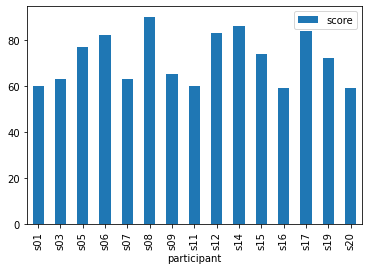

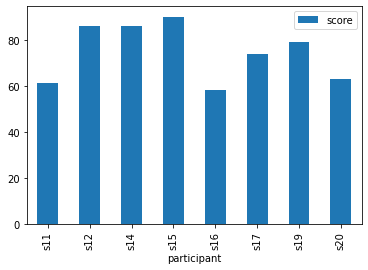

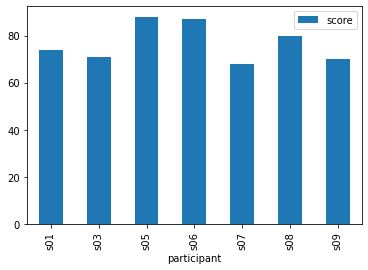

In [19]:
'''Here we plot the scores.'''

s_scores_1_bar = s_scores_1.plot.bar()

s_scores_2_s_bar = s_scores_2_s.plot.bar()

s_scores_2_d_bar = s_scores_2_d.plot.bar()

'''
#merge both games by participant:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')

#label columns
s_scores.columns=['Game 1','Game 2']

s_scores'''

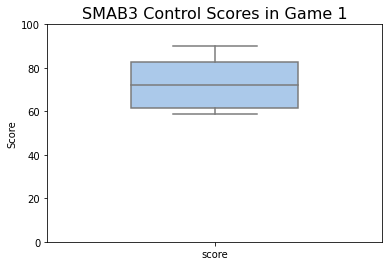

In [20]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores1_box = sns.boxplot( 
                 data=s_scores_1,
                 width=0.5,
                 palette="pastel")
s_scores1_box.axes.set_title("SMAB3 Control Scores in Game 1",
                    fontsize=16)

plot_file_name="s_score1_box.jpg"
 
plt.ylim(0, 100)
s_scores1_box.axes.set(ylabel='Score')

# save as jpeg
s_scores1_box.figure.savefig(plot_file_name,
                    format='jpeg')

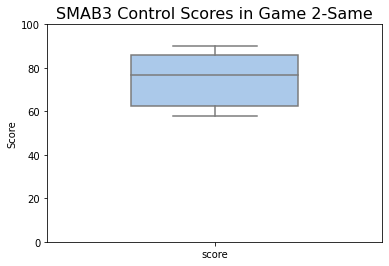

In [21]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores2s_box = sns.boxplot( 
                 data=s_scores_2_s,
                 width=0.5,
                 palette="pastel")
s_scores2s_box.axes.set_title("SMAB3 Control Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="s_score_2s_box.jpg"
 
plt.ylim(0, 100)
s_scores2s_box.axes.set(ylabel='Score')

# save as jpeg
s_scores2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

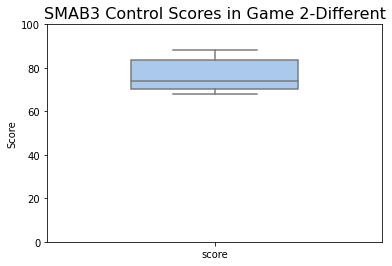

In [22]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores2d_box = sns.boxplot( 
                 data=s_scores_2_d,
                 width=0.5,
                 palette="pastel")
s_scores2d_box.axes.set_title("SMAB3 Control Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="s_score_2d_box.jpg"
 
plt.ylim(0, 100)
s_scores2d_box.axes.set(ylabel='Score')

# save as jpeg
s_scores2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [23]:
'''Here we look at the means, standard deviations, and medians of the scores in games 1 and 2.'''

s_scores_1_mean = s_scores_1.mean()

In [24]:
s_scores_1_std = s_scores_1.std()

In [25]:
s_scores_1_mean, s_scores_1_std

(score    71.8
 dtype: float64,
 score    11.181618
 dtype: float64)

In [26]:
s_scores_2s_mean = s_scores_2_s.mean()

In [27]:
s_scores_2s_std = s_scores_2_s.std()

In [28]:
s_scores_2d_mean = s_scores_2_d.mean()

In [29]:
s_scores_2d_std = s_scores_2_d.std()

In [30]:
s_scores_2s_mean, s_scores_2s_std

(score    74.625
 dtype: float64,
 score    12.603146
 dtype: float64)

In [31]:
s_scores_2d_mean, s_scores_2d_std

(score    76.857143
 dtype: float64,
 score    8.214389
 dtype: float64)

In [32]:
sp.stats.ttest_ind(s_scores_2_s, s_scores_2_d)

Ttest_indResult(statistic=array([-0.39928923]), pvalue=array([0.69616225]))

In [33]:
'''Here we separate the dataframes of game 1 and game 2 for each subject.'''


s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
s03_p1_g1, s03_p1_g2 = separate_df(s03, 's')
s05_p1_g1, s05_p1_g2 = separate_df(s05, 's')
s06_p1_g1, s06_p1_g2 = separate_df(s06, 's')
s07_p1_g1, s07_p1_g2 = separate_df(s07, 's')
s08_p1_g1, s08_p1_g2 = separate_df(s08, 's')
s09_p1_g1, s09_p1_g2 = separate_df(s09, 's')
s11_p1_g1, s11_p1_g2 = separate_df(s11, 's')
s12_p1_g1, s12_p1_g2 = separate_df(s12, 's')
s15_p1_g1, s15_p1_g2 = separate_df(s15, 's')
s16_p1_g1, s16_p1_g2 = separate_df(s16, 's')
s17_p1_g1, s17_p1_g2 = separate_df(s17, 's')
s19_p1_g1, s19_p1_g2 = separate_df(s19, 's')
s20_p1_g1, s20_p1_g2 = separate_df(s20, 's')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anacon

In [34]:
'''Here we check the arm-probability mappings in each game'''
s01_p1_g1_map = hole_prob_map(s01_p1_g1)
s01_p1_g2_map = hole_prob_map(s01_p1_g2)

s03_p1_g1_map = hole_prob_map(s03_p1_g1)
s03_p1_g2_map = hole_prob_map(s03_p1_g2)

s05_p1_g1_map = hole_prob_map(s05_p1_g1)
#s05_p1_g2_map = hole_prob_map(s05_p1_g2)

s07_p1_g1_map = hole_prob_map(s07_p1_g1)
s07_p1_g2_map = hole_prob_map(s07_p1_g2)

s08_p1_g1_map = hole_prob_map(s08_p1_g1)
s08_p1_g2_map = hole_prob_map(s08_p1_g2)

s09_p1_g1_map = hole_prob_map(s09_p1_g1)
s09_p1_g2_map = hole_prob_map(s09_p1_g2)

s11_p1_g1_map = hole_prob_map(s11_p1_g1)
s11_p1_g2_map = hole_prob_map(s11_p1_g2)

s12_p1_g1_map = hole_prob_map(s12_p1_g1)
s12_p1_g2_map = hole_prob_map(s12_p1_g2)

s15_p1_g1_map = hole_prob_map(s15_p1_g1)
s15_p1_g2_map = hole_prob_map(s15_p1_g2)

s16_p1_g1_map = hole_prob_map(s16_p1_g1)
s16_p1_g2_map = hole_prob_map(s16_p1_g2)

s17_p1_g1_map = hole_prob_map(s17_p1_g1)
#s17_p1_g2_map = hole_prob_map(s17_p1_g2)

In [306]:
s01_p1_g1

,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
0,1,1,1,2,30,1,11.220698,1,0
1,1,2,1,3,60,1,5.362458,2,1
2,1,3,1,2,30,0,3.489552,2,2
3,1,4,1,3,60,0,3.210886,2,3
4,1,5,1,3,60,1,2.904784,3,4
5,1,6,1,1,90,0,3.241885,3,5
6,1,7,1,1,90,1,2.839384,4,6
7,1,8,1,2,30,0,2.985595,4,7
8,1,9,1,2,30,1,2.581026,5,8
9,1,10,1,2,30,0,2.472073,5,9


In [35]:
'''Here we count the number of times that each hole was selected by each subject in each game by calling value_counts'''


s01_p1_g1_count = s01_p1_g1['probability'].value_counts(sort=False)
s01_p1_g2_count = s01_p1_g2['probability'].value_counts(sort=False)
s03_p1_g1_count = s03_p1_g1['probability'].value_counts(sort=False)
s03_p1_g2_count = s03_p1_g2['probability'].value_counts(sort=False)
s05_p1_g1_count = s05_p1_g1['probability'].value_counts(sort=False)
s05_p1_g2_count = s05_p1_g2['probability'].value_counts(sort=False)
s06_p1_g1_count = s06_p1_g1['probability'].value_counts(sort=False)
s06_p1_g2_count = s06_p1_g2['probability'].value_counts(sort=False)
s07_p1_g1_count = s07_p1_g1['probability'].value_counts(sort=False)
s07_p1_g2_count = s07_p1_g2['probability'].value_counts(sort=False)
s08_p1_g1_count = s08_p1_g1['probability'].value_counts(sort=False)
s08_p1_g2_count = s08_p1_g2['probability'].value_counts(sort=False)
s09_p1_g1_count = s09_p1_g1['probability'].value_counts(sort=False)
s09_p1_g2_count = s09_p1_g2['probability'].value_counts(sort=False)
s11_p1_g1_count = s11_p1_g1['probability'].value_counts(sort=False)
s11_p1_g2_count = s11_p1_g2['probability'].value_counts(sort=False)
s12_p1_g1_count = s12_p1_g1['probability'].value_counts(sort=False)
s12_p1_g2_count = s12_p1_g2['probability'].value_counts(sort=False)
s14_p1_g1_count = s14_p1_g1['probability'].value_counts(sort=False)
s14_p1_g2_count = s14_p1_g2['probability'].value_counts(sort=False)
s15_p1_g1_count = s15_p1_g1['probability'].value_counts(sort=False)
s15_p1_g2_count = s15_p1_g2['probability'].value_counts(sort=False)
s16_p1_g1_count = s16_p1_g1['probability'].value_counts(sort=False)
s16_p1_g2_count = s16_p1_g2['probability'].value_counts(sort=False)
s17_p1_g1_count = s17_p1_g1['probability'].value_counts(sort=False)
s17_p1_g2_count = s17_p1_g2['probability'].value_counts(sort=False)
s19_p1_g1_count = s19_p1_g1['probability'].value_counts(sort=False)
s19_p1_g2_count = s19_p1_g2['probability'].value_counts(sort=False)
s20_p1_g1_count = s20_p1_g1['probability'].value_counts(sort=False)
s20_p1_g2_count = s20_p1_g2['probability'].value_counts(sort=False)

In [36]:
s01_p1_g1_count

30    38
60    43
90    19
Name: probability, dtype: int64

In [37]:
s01_p1_g2_count

30    38
60    16
90    46
Name: probability, dtype: int64

In [38]:
'''Here we create dataframes with the counts for game 1.'''

s_g1_counts = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count,s14_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count','s14_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count'])



#How to prevent NaN: df = df.fillna(0). This makes the value 0 if a hole was never selected by a subject.
s_g1_counts = s_g1_counts.fillna(0)

#print
s_g1_counts

,30.0,60.0,90.0
s01_p1_g1_count,38,43,19
s03_p1_g1_count,28,38,34
s05_p1_g1_count,11,35,54
s06_p1_g1_count,11,13,76
s07_p1_g1_count,25,29,46
s08_p1_g1_count,2,6,92
s09_p1_g1_count,17,38,45
s11_p1_g1_count,30,34,36
s12_p1_g1_count,7,28,65
s14_p1_g1_count,2,1,97


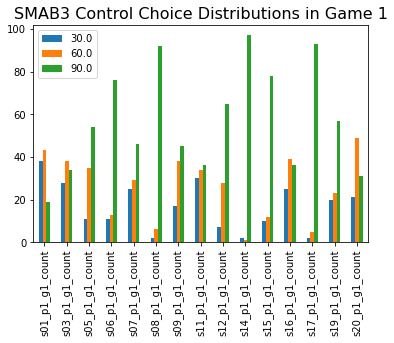

In [39]:
#Here we plot the value counts

s_g1_counts.sum(axis=1)


s_g1_counts_bar = s_g1_counts.plot.bar()

s_g1_counts_bar.axes.set_title("SMAB3 Control Choice Distributions in Game 1",
                    fontsize=16)

# save as jpeg
s_g1_counts_bar.figure.savefig("s_g1_counts_bar.jpg",
                    format='jpeg')

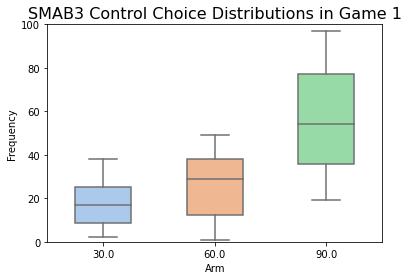

In [40]:
s_g1_counts_box = sns.boxplot( 
                 data=s_g1_counts, 
                 width=0.5,
                 palette="pastel")
s_g1_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="s_g1_counts_box.jpg"
 
plt.ylim(0, 100)
s_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [41]:
'''Here we get the mean and standard deviation of the number of selections of each hole where low is the 0th column and the 30% hole, 
med is the 1st column and the 60% hole, and high is the 2nd column and the 90% hole.'''


s_g1_low = np.mean(s_g1_counts.iloc[:,0])
s_g1_med = np.mean(s_g1_counts.iloc[:,1])
s_g1_high = np.mean(s_g1_counts.iloc[:,2])


s_g1_low_std = np.std(s_g1_counts.iloc[:,0])
s_g1_med_std = np.std(s_g1_counts.iloc[:,1])
s_g1_high_std = np.std(s_g1_counts.iloc[:,2])

In [42]:
s_g1_low, s_g1_med, s_g1_high

(16.6, 26.2, 57.266666666666666)

In [43]:
 s_g1_low_std, s_g1_med_std, s_g1_high_std

(10.886076734373438, 14.770240350109406, 24.208722027860585)

In [44]:
'''Here we create dataframes with the counts for game 2.'''


s_g2_s_counts = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count],
                             index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
s_g2_s_counts = s_g2_s_counts.fillna(0)

#print
s_g2_s_counts

s_g2_s_counts.sum(axis=1)

s01_p1_g2_count    100.0
s03_p1_g2_count    100.0
s05_p1_g2_count    100.0
s06_p1_g2_count    100.0
s07_p1_g2_count    100.0
s08_p1_g2_count    100.0
s09_p1_g2_count    100.0
dtype: float64

In [45]:
s_g2_d_counts = pd.DataFrame([s11_p1_g2_count, s12_p1_g2_count, s14_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count],
index= ['s11_p1_g2_count', 's12_p1_g2_count', 's14_p1_g2_count', 's15_p1_g2_count',
                                 's16_p1_g2_count', 's17_p1_g2_count', 's19_p1_g2_count', 's20_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
s_g2_d_counts = s_g2_d_counts.fillna(0)


s_g2_d_counts.sum(axis=1)

s11_p1_g2_count    100.0
s12_p1_g2_count    100.0
s14_p1_g2_count    100.0
s15_p1_g2_count    100.0
s16_p1_g2_count    100.0
s17_p1_g2_count    100.0
s19_p1_g2_count    100.0
s20_p1_g2_count    101.0
dtype: float64

In [46]:
s_g2_d_counts

,30.0,60.0,90.0
s11_p1_g2_count,28.0,30.0,42.0
s12_p1_g2_count,7.0,5.0,88.0
s14_p1_g2_count,2.0,0.0,98.0
s15_p1_g2_count,3.0,7.0,90.0
s16_p1_g2_count,29.0,44.0,27.0
s17_p1_g2_count,0.0,22.0,78.0
s19_p1_g2_count,12.0,9.0,79.0
s20_p1_g2_count,10.0,54.0,37.0


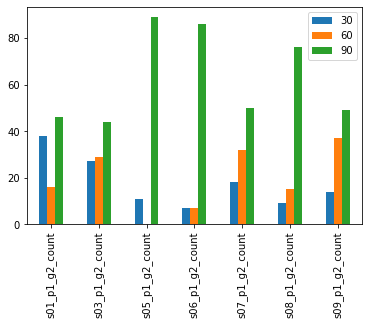

In [47]:
'''Here we plot the counts in game 2.'''

s_g2_s_counts_bar = s_g2_s_counts.plot.bar()

# save as jpeg
s_g2_s_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

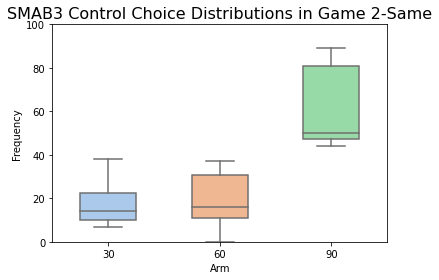

In [48]:
s_g2_s_counts_box = sns.boxplot( 
                 data=s_g2_s_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_s_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="s_g2_s_counts_box.jpg"

plt.ylim(0, 100)
s_g2_s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

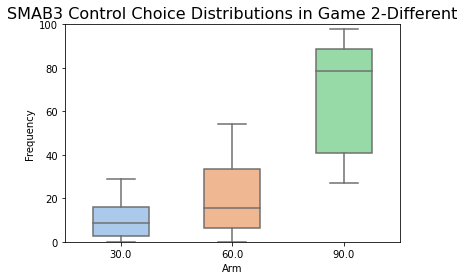

In [49]:
s_g2_d_counts_box = sns.boxplot( 
                 data=s_g2_d_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_d_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="s_g2_d_counts_box.jpg"

plt.ylim(0, 100)
s_g2_d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [50]:
'''Here we get the mean and standard deviation of the number of times participants chose each hole.'''


s_g2_s_low = np.mean(s_g2_s_counts.iloc[:,0])
s_g2_s_med = np.mean(s_g2_s_counts.iloc[:,1])
s_g2_s_high = np.mean(s_g2_s_counts.iloc[:,2])


In [51]:
'''Here we get the mean and standard deviation of the number of times participants chose each hole.'''


s_g2_d_low = np.mean(s_g2_d_counts.iloc[:,0])
s_g2_d_med = np.mean(s_g2_d_counts.iloc[:,1])
s_g2_d_high = np.mean(s_g2_d_counts.iloc[:,2])


In [52]:
s_g2_s_low_std = np.std(s_g2_s_counts.iloc[:,0])
s_g2_s_med_std = np.std(s_g2_s_counts.iloc[:,1])
s_g2_s_high_std = np.std(s_g2_s_counts.iloc[:,2])

In [53]:
s_g2_d_low_std = np.std(s_g2_d_counts.iloc[:,0])
s_g2_d_med_std = np.std(s_g2_d_counts.iloc[:,1])
s_g2_d_high_std = np.std(s_g2_d_counts.iloc[:,2])

In [54]:
'''Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.


import researchpy as rp


s_90_1 = np.array(s_g1_counts.iloc[:,2])
s_90_2 = np.array(s_g2_counts.iloc[:,2])

s_60_1 = np.array(s_g1_counts.iloc[:,1])
s_60_2 = np.array(s_g2_counts.iloc[:,1])


s_30_1 = np.array(s_g1_counts.iloc[:,0])
s_30_2 = np.array(s_g2_counts.iloc[:,0])

s_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)
s_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)
s_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)'''

'Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.\n\n\nimport researchpy as rp\n\n\ns_90_1 = np.array(s_g1_counts.iloc[:,2])\ns_90_2 = np.array(s_g2_counts.iloc[:,2])\n\ns_60_1 = np.array(s_g1_counts.iloc[:,1])\ns_60_2 = np.array(s_g2_counts.iloc[:,1])\n\n\ns_30_1 = np.array(s_g1_counts.iloc[:,0])\ns_30_2 = np.array(s_g2_counts.iloc[:,0])\n\ns_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)\ns_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)\ns_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)'

In [55]:
s01_p1_g1.reset_index(drop=True, inplace=True)

# Reaction Time Analyses

In [56]:
'Here we get the reaction times'
time_s_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_s_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [57]:
time_s_1 = reaction_time(s01_p1_g1, time_s_1)

In [58]:
time_s_1 = reaction_time(s03_p1_g1, time_s_1)
time_s_1 = reaction_time(s05_p1_g1, time_s_1)
time_s_1 = reaction_time(s06_p1_g1, time_s_1)
time_s_1 = reaction_time(s07_p1_g1, time_s_1)
time_s_1 = reaction_time(s08_p1_g1, time_s_1)
time_s_1 = reaction_time(s09_p1_g1, time_s_1)
time_s_1 = reaction_time(s11_p1_g1, time_s_1)
time_s_1 = reaction_time(s12_p1_g1, time_s_1)
time_s_1 = reaction_time(s15_p1_g1, time_s_1)
time_s_1 = reaction_time(s16_p1_g1, time_s_1)
time_s_1 = reaction_time(s17_p1_g1, time_s_1)
time_s_1 = reaction_time(s19_p1_g1, time_s_1)
#time_s_1 = reaction_time(s20_p1_g1, time_s_1)

In [59]:
time_s_2 = reaction_time(s03_p1_g2, time_s_2)
time_s_2 = reaction_time(s05_p1_g2, time_s_2)
time_s_2 = reaction_time(s06_p1_g2, time_s_2)
time_s_2 = reaction_time(s07_p1_g2, time_s_2)
time_s_2 = reaction_time(s08_p1_g2, time_s_2)
time_s_2 = reaction_time(s09_p1_g2, time_s_2)
time_s_2 = reaction_time(s11_p1_g2, time_s_2)
time_s_2 = reaction_time(s12_p1_g2, time_s_2)
time_s_2 = reaction_time(s15_p1_g2, time_s_2)
time_s_2 = reaction_time(s16_p1_g2, time_s_2)
time_s_2 = reaction_time(s17_p1_g2, time_s_2)
time_s_2 = reaction_time(s19_p1_g2, time_s_2)
#time_s_2 = reaction_time(s20_p1_g2, time_s_2)

In [60]:
sp.stats.ttest_rel(time_s_1['post win'], time_s_1['post loss'])

Ttest_relResult(statistic=-0.22232713395530926, pvalue=0.8277981973516864)

In [61]:
sp.stats.ttest_rel(time_s_2['post win'], time_s_2['post loss'])

Ttest_relResult(statistic=1.6133551404642006, pvalue=0.1349630881166298)

In [62]:
#sp.stats.ttest_rel(time_s_1['post loss'], time_s_2['post loss'])

In [63]:
s01_p1_g1.loc[0,'time']

11.22069836

In [66]:
'''Here we get the average reaction times for each subject in games 1 and 2'''
s01_p1_g1_t = s01_p1_g1['time'].mean()
s01_p1_g2_t = s01_p1_g2['time'].mean()

# SMAB4 Single Player Analysis

In [67]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.'''

df = organize_trial_by_trial_hand_code2('data/c01_gamedata_handcode.csv')
c01 = df
#c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c01.head()

df = organize_trial_by_trial('data/c02_gamedata.csv')
c02 = df
c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c02.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c03_gamedata.csv')
c03 = df
c03_p1_g1_score,c03_p1_g2_score,c03_score_diff, c03_p1_g1_50,c03_p1_g2_50 = call_get_score(c03, 'c')
c03.head()

df = organize_trial_by_trial_hand_code2('data/c04_gamedata_handcode.csv')
c04 = df
#c04_p1_g1_score,c04_p1_g2_score,c04_score_diff, c04_p1_g1_50,c04_p1_g2_50 = call_get_score(c04, 'c')
c04.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c05_gamedata.csv')
c05 = df
c05_p1_g1_score,c05_p1_g2_score,c05_score_diff, c05_p1_g1_50,c05_p1_g2_50 = call_get_score(c05, 'c')
c05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c06_gamedata.csv')
c06 = df
c06_p1_g1_score,c06_p1_g2_score,c06_score_diff, c06_p1_g1_50,c06_p1_g2_50 = call_get_score(c06, 'c')
c06.head()


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c07_gamedata.csv')
c07 = df
c07_p1_g1_score,c07_p1_g2_score,c07_score_diff, c07_p1_g1_50,c07_p1_g2_50 = 78, 86, 8, 34, 42 
#c07.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c09_gamedata.csv')
c09 = df
c09_p1_g1_score,c09_p1_g2_score,c09_score_diff, c09_p1_g1_50,c09_p1_g2_50 = call_get_score(c09, 'c')
c09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c10_gamedata.csv')
c10 = df
c10_p1_g1_score,c10_p1_g2_score,c10_score_diff, c10_p1_g1_50,c10_p1_g2_50 = call_get_score(c10, 'c')
c10.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c11_gamedata.csv')
c11 = df
c11_p1_g1_score,c11_p1_g2_score,c11_score_diff, c11_p1_g1_50,c11_p1_g2_50 = call_get_score(c11, 'c')
c11.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c12_gamedata2.csv')
c12 = df
c12_p1_g1_score,c12_p1_g2_score,c12_score_diff, c12_p1_g1_50,c12_p1_g2_50 = call_get_score(c12, 'c')
c12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c13_gamedata2.csv')
c13 = df
c13_p1_g1_score,c13_p1_g2_score,c13_score_diff, c13_p1_g1_50,c13_p1_g2_50 = call_get_score(c13, 'c')
c13.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c14_gamedata2.csv')
c14 = df
c14_p1_g1_score,c14_p1_g2_score,c14_score_diff, c14_p1_g1_50,c14_p1_g2_50 = call_get_score(c14, 'c')
c14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c15_gamedata.csv')
c15 = df
c15_p1_g1_score,c15_p1_g2_score,c15_score_diff, c15_p1_g1_50,c15_p1_g2_50 = call_get_score(c15, 'c')


#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c16_gamedata2.csv')
c16 = df
c16_p1_g1_score,c16_p1_g2_score,c16_score_diff, c16_p1_g1_50,c16_p1_g2_50 = call_get_score(c16, 'c')
c16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c17_gamedata2.csv')
c17 = df
c17_p1_g1_score,c17_p1_g2_score,c17_score_diff, c17_p1_g1_50,c17_p1_g2_50 = call_get_score(c17, 'c')
c17#in the s files, p2 is the confederate

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/c18_gamedata.csv')
c18 = df
c18_p1_g1_score,c18_p1_g2_score,c18_score_diff, c18_p1_g1_50,c18_p1_g2_50 = call_get_score(c18, 'c')
c18#in the s files, p2 is the confederate



,game number,trial,player,arm,probability,reward,time,P1 score,P2 score
0,1,1,1,3,90,0,5.135425,0,0
1,1,2,2,3,30,0,2.545789,1,0
2,1,3,1,2,60,0,7.996138,1,0
3,1,4,2,3,30,0,3.018310,2,0
4,1,4,1,3,90,0,1.015114,2,0
...,...,...,...,...,...,...,...,...,...
395,2,196,2,3,30,0,3.947417,73,35
396,2,197,1,1,30,0,3.995810,73,35
397,2,198,2,3,30,0,2.867564,73,35
398,2,199,1,3,90,0,3.397195,73,35


In [68]:
c01_p1_counts, c01_p2_counts, c01_p1_probs, c01_p2_probs = handcode_calc_prob(c01)
c04_p1_counts, c04_p2_counts, c04_p1_probs, c04_p2_probs = handcode_calc_prob(c04)

In [69]:
c01_p1_counts

,g1_p1_h1_count,g1_p1_h2_count,g1_p1_h3_count,g2_p1_h1_count,g2_p1_h2_count,g2_p1_h3_count
rewarded,39,20,7,53,20,2
non-rewarded,4,14,14,9,10,10


In [70]:
c04_p1_counts

,g1_p1_h1_count,g1_p1_h2_count,g1_p1_h3_count,g2_p1_h1_count,g2_p1_h2_count,g2_p1_h3_count
rewarded,43,12,1,50,21,1
non-rewarded,5,10,10,7,17,17


In [71]:
c01_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,90.697674,58.823529,33.333333
game 2,85.483871,66.666667,16.666667


In [72]:
c04_p1_probs

,p1_h1,p1_h2,p1_h3
game 1,89.583333,54.545455,9.090909
game 2,87.719298,55.263158,5.555556


In [73]:
#NOT SURE
c01 = fill_in_prob(c01, 90,60,30,90,60,30,30,60,90,30,60,90)
c04 = fill_in_prob(c04, 90,60,30,90,60,30,30,60,90,30,60,90)

In [74]:
c01_p1_g1, c01_p1_g2 = separate_df(c01, 'c')
c04_p1_g1, c04_p1_g2 = separate_df(c04, 'c')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [75]:
c01_p1_g1_score = c01_p1_g1['reward'].sum()
c01_p1_g2_score = c01_p1_g2['reward'].sum()
c04_p1_g1_score = c04_p1_g1['reward'].sum()
c04_p1_g2_score = c04_p1_g2['reward'].sum()

In [76]:
'''Here we place the scores in games 1 and 2 into dataframes.'''


#list out all the scores in game 1 by participant
c_scores_1 = pd.DataFrame({'participant':['c01','c02', 'c03', 'c04',
                               'c05', 'c06', 'c07','c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18'], 'score':
     [c01_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score, c04_p1_g1_score, c05_p1_g1_score, c06_p1_g1_score, c07_p1_g1_score,
      c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, 
      c15_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score, c18_p1_g1_score]})
#to prevent an extra column that numbers each row:
c_scores_1.set_index('participant', inplace=True, drop=True)

#print
c_scores_1


#list out all the scores in game 2 by participant
c_scores_2_d = pd.DataFrame({'participant':['c01','c02', 'c03', 'c04', 
                              'c05', 'c06', 'c09', 'c10', 'c11'], 'score':
                           [c01_p1_g2_score, c02_p1_g2_score, c03_p1_g2_score, c04_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2_d.set_index('participant', inplace=True, drop=True)

c_scores_2_s = pd.DataFrame({'participant':['c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18'], 'score':
                           [c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c15_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score, c18_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2_s.set_index('participant', inplace=True, drop=True)

'''
#list out all the scores in game 1 by participant
c_scores_1_50 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c15', 'c14', 'c16', 'c17', 'c18'], 'score_1_50':
     [c02_p1_g1_50, c03_p1_g1_50, c05_p1_g1_50,
      c06_p1_g1_50, c09_p1_g1_50, c10_p1_g1_50, c11_p1_g1_50, c12_p1_g1_50, c13_p1_g1_50, c14_p1_g1_50, c15_p1_g1_50,
      c16_p1_g1_50, c17_p1_g1_50, c18_p1_g1_50]})
#to prevent an extra column that numbers each row:
c_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
c_scores_2_50 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17','c18'], 'score_1_50':
     [c02_p1_g2_50, c03_p1_g2_50, c05_p1_g2_50,
      c06_p1_g2_50, c09_p1_g2_50, c10_p1_g2_50, c11_p1_g2_50, c12_p1_g2_50, c13_p1_g2_50, c14_p1_g2_50, 
      c15_p1_g2_50,c16_p1_g2_50, c17_p1_g2_50, c18_p1_g2_50]})
c_scores_2_50.set_index('participant', inplace=True, drop=True)'''

"\n#list out all the scores in game 1 by participant\nc_scores_1_50 = pd.DataFrame({'participant':['c02', 'c03', \n                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c15', 'c14', 'c16', 'c17', 'c18'], 'score_1_50':\n     [c02_p1_g1_50, c03_p1_g1_50, c05_p1_g1_50,\n      c06_p1_g1_50, c09_p1_g1_50, c10_p1_g1_50, c11_p1_g1_50, c12_p1_g1_50, c13_p1_g1_50, c14_p1_g1_50, c15_p1_g1_50,\n      c16_p1_g1_50, c17_p1_g1_50, c18_p1_g1_50]})\n#to prevent an extra column that numbers each row:\nc_scores_1_50.set_index('participant', inplace=True, drop=True)\n\n#list out all the scores in game 2 by participant\nc_scores_2_50 = pd.DataFrame({'participant':['c02', 'c03', \n                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17','c18'], 'score_1_50':\n     [c02_p1_g2_50, c03_p1_g2_50, c05_p1_g2_50,\n      c06_p1_g2_50, c09_p1_g2_50, c10_p1_g2_50, c11_p1_g2_50, c12_p1_g2_50, c13_p1_g2_50, c14_p1_g2_50, \n      c15_p1_g2_50,c1

In [77]:
'''Here we combine the dataframes with the scores from the 2 games.
c_scores_50 = c_scores_1_50.merge(c_scores_2_50,right_index=True,left_index=True)
c_scores = c_scores_1.merge(c_scores_2,right_index=True,left_index=True)
c_combo = c_scores_50.merge(c_scores,right_index=True,left_index=True)

#rename columns
c_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]'''

'Here we combine the dataframes with the scores from the 2 games.\nc_scores_50 = c_scores_1_50.merge(c_scores_2_50,right_index=True,left_index=True)\nc_scores = c_scores_1.merge(c_scores_2,right_index=True,left_index=True)\nc_combo = c_scores_50.merge(c_scores,right_index=True,left_index=True)\n\n#rename columns\nc_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]'

In [78]:
'''Here we plot the scores in games 1 and 2.

c_scores_1_bar = c_scores_1.plot.bar()



c_scores_2_bar = c_scores_2.plot.bar()



#label columns
#c_scores.columns=['Game 1','Game 2']


c_scores'''

"Here we plot the scores in games 1 and 2.\n\nc_scores_1_bar = c_scores_1.plot.bar()\n\n\n\nc_scores_2_bar = c_scores_2.plot.bar()\n\n\n\n#label columns\n#c_scores.columns=['Game 1','Game 2']\n\n\nc_scores"

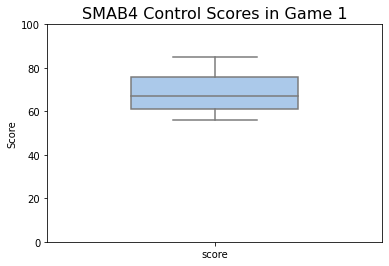

In [79]:
#c_scores1_box = c_scores_1.boxplot()
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))


c_scores1_box = sns.boxplot( 
                 data=c_scores_1, 
                 width=0.5,
                 palette="pastel")
c_scores1_box.axes.set_title("SMAB4 Control Scores in Game 1",
                    fontsize=16)

plot_file_name="c_g1_score_box.jpg"
 
plt.ylim(0, 100)
c_scores1_box.axes.set(ylabel='Score')

# save as jpeg
c_scores1_box.figure.savefig(plot_file_name,
                    format='jpeg')

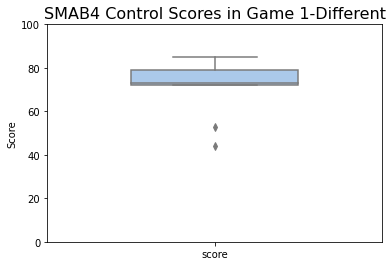

In [80]:
c_scores_2d_box = sns.boxplot( 
                 data=c_scores_2_d, 
                 width=0.5,
                 palette="pastel")
c_scores_2d_box.axes.set_title("SMAB4 Control Scores in Game 1-Different",
                    fontsize=16)

plot_file_name="c_g2d_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_2d_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

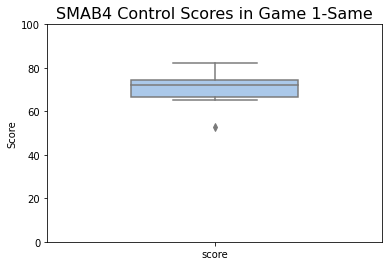

In [81]:
c_scores_2s_box = sns.boxplot( 
                 data=c_scores_2_s, 
                 width=0.5,
                 palette="pastel")
c_scores_2s_box.axes.set_title("SMAB4 Control Scores in Game 1-Same",
                    fontsize=16)

plot_file_name="c_g2s_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_2s_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [82]:
c_scores_2s_mean = c_scores_2_s.mean()

In [83]:
c_scores_2s_std = c_scores_2_s.std()

In [84]:
c_scores_2d_mean = c_scores_2_d.mean()

In [85]:
c_scores_2d_std = c_scores_2_d.std()

In [86]:
c_scores_2s_mean, c_scores_2s_std

(score    69.857143
 dtype: float64,
 score    9.191093
 dtype: float64)

In [87]:
c_scores_2d_mean, c_scores_2d_std

(score    70.555556
 dtype: float64,
 score    13.482499
 dtype: float64)

In [88]:
sp.stats.ttest_ind(c_scores_2_s, c_scores_2_d)

Ttest_indResult(statistic=array([-0.11709513]), pvalue=array([0.90844792]))

In [89]:
'''Here we make a boxplot with the scores in the first and second half of the games included
c_combo_box = sns.boxplot( 
                 data=c_combo, order = ['score_1_50','score_2_50','score_1','score_2'],
                 width=0.5,
                 palette="pastel")
c_combo_box.axes.set_title("SMAB4 Control Scores",
                    fontsize=16)

plot_file_name="c_score_box.jpg"
 
plt.ylim(0, 100)
c_combo_box.axes.set(ylabel='Score')

# save as jpeg
c_combo_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'Here we make a boxplot with the scores in the first and second half of the games included\nc_combo_box = sns.boxplot( \n                 data=c_combo, order = [\'score_1_50\',\'score_2_50\',\'score_1\',\'score_2\'],\n                 width=0.5,\n                 palette="pastel")\nc_combo_box.axes.set_title("SMAB4 Control Scores",\n                    fontsize=16)\n\nplot_file_name="c_score_box.jpg"\n \nplt.ylim(0, 100)\nc_combo_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nc_combo_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

In [90]:
'''Get the p value between the scores in games 1 and 2.

c_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])



c_scores_p


#plot bar graph of scores


c_scores_2_bar = c_scores_2.plot.bar()



#combine g1 and g2 to one dataframe
c_combo = c_scores_1.append(c_scores_2)



c_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',
                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':
     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})
c_combo.set_index('participant', inplace=True, drop=True)


#new_index = ('c02_g1','c02_g2','c03_g1','c03_g2','c04_g1','c04_g2','c05_g1','c05_g2','c06_g1','c06_g2','c09_g1','c09_g2','c10_g1','c10_g2','c11_g1','c11_g2','c12_g1','c12_g2','c13_g1','c13_g2','c14_g1','c14_g2','c16_g1','c16_g2','c17_g1','c17_g2')
#c_combo.index = new_index


c_combo = c_combo.sort_values(by=['participant'])'''

"Get the p value between the scores in games 1 and 2.\n\nc_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])\n\n\n\nc_scores_p\n\n\n#plot bar graph of scores\n\n\nc_scores_2_bar = c_scores_2.plot.bar()\n\n\n\n#combine g1 and g2 to one dataframe\nc_combo = c_scores_1.append(c_scores_2)\n\n\n\nc_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',\n                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':\n     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})\nc_combo.set_index('participant', inplace=True, drop=T

In [91]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
#colors = list(islice(cycle(['red','blue','green', 'yellow']),None,len(c_combo)))
#blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(c_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
#c_combo_bar = c_combo.plot(kind='bar',color=colors)

# Checking for outliars

In [92]:
#scatter plot
'''
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(c_combo['score_2_50'], c_combo['score_2'])
ax.set_xlabel('Score at trial 50')
ax.set_ylabel('Score at trial 100')
plt.show()'''

"\nfig, ax = plt.subplots(figsize=(16,8))\nax.scatter(c_combo['score_2_50'], c_combo['score_2'])\nax.set_xlabel('Score at trial 50')\nax.set_ylabel('Score at trial 100')\nplt.show()"

In [93]:
#calculate z score
#z = np.abs(stats.zscore(c_combo['score_2']))
#print(z)

In [94]:
#z = np.abs(stats.zscore(c_combo['score_2_50']))
#print(z)

In [95]:
'''Here we get the mean, median, and standard deviation of the scores in games 1 and 2.'''

c_scores_1_mean = c_scores_1.mean()


c_scores_1_mean

score    68.588235
dtype: float64

In [96]:
c_scores_1_std = c_scores_1.std()


c_scores_1_std

score    8.846319
dtype: float64

In [97]:
c_scores_1_mean, c_scores_1_std

(score    68.588235
 dtype: float64,
 score    8.846319
 dtype: float64)

In [98]:
'''
c_scores_2_mean = c_scores_2.mean()


# In[147]:


c_scores_2_mean'''

'\nc_scores_2_mean = c_scores_2.mean()\n\n\n# In[147]:\n\n\nc_scores_2_mean'

In [99]:
# In[148]:

'''
c_scores_2_std = c_scores_2.std()


# In[149]:


c_scores_2_std'''

'\nc_scores_2_std = c_scores_2.std()\n\n\n# In[149]:\n\n\nc_scores_2_std'

In [100]:
# In[150]:

'''
c_scores_med = c_scores.median()
c_scores_med'''

'\nc_scores_med = c_scores.median()\nc_scores_med'

In [101]:
'''Here we separate the dataframes into games 1 and 2.'''

#s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
c02_p1_g1, c02_p1_g2 = separate_df(c02, 'c')
c03_p1_g1, c03_p1_g2 = separate_df(c03, 'c')
c05_p1_g1, c05_p1_g2 = separate_df(c05, 'c')
c06_p1_g1, c06_p1_g2 = separate_df(c06, 'c')
c07_p1_g1, c07_p1_g2 = separate_df(c07, 'c')
c09_p1_g1, c09_p1_g2 = separate_df(c09, 'c')
c10_p1_g1, c10_p1_g2 = separate_df(c10, 'c')
c11_p1_g1, c11_p1_g2 = separate_df(c11, 'c')
c12_p1_g1, c12_p1_g2 = separate_df(c12, 'c')
c13_p1_g1, c13_p1_g2 = separate_df(c13, 'c')
c14_p1_g1, c14_p1_g2 = separate_df(c14, 'c')
c15_p1_g1, c15_p1_g2 = separate_df(c15, 'c')
c16_p1_g1, c16_p1_g2 = separate_df(c16, 'c')
c17_p1_g1, c17_p1_g2 = separate_df(c17, 'c')
c18_p1_g1, c18_p1_g2 = separate_df(c18, 'c')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anacon

In [102]:
c02_p1_g1_map = hole_prob_map(c02_p1_g1)
c02_p1_g2_map = hole_prob_map(c02_p1_g2)

c03_p1_g1_map = hole_prob_map(c03_p1_g1)
c03_p1_g2_map = hole_prob_map(c03_p1_g2)

c07_p1_g1_map = hole_prob_map(c07_p1_g1)
c07_p1_g2_map = hole_prob_map(c07_p1_g2)

c05_p1_g1_map = hole_prob_map(c05_p1_g1)
c05_p1_g2_map = hole_prob_map(c05_p1_g2)

c06_p1_g1_map = hole_prob_map(c06_p1_g1)
c06_p1_g2_map = hole_prob_map(c06_p1_g2)

c09_p1_g1_map = hole_prob_map(c09_p1_g1)
c09_p1_g2_map = hole_prob_map(c09_p1_g2)

c10_p1_g1_map = hole_prob_map(c10_p1_g1)
c10_p1_g2_map = hole_prob_map(c10_p1_g2)

c11_p1_g1_map = hole_prob_map(c11_p1_g1)
c11_p1_g2_map = hole_prob_map(c11_p1_g2)

c12_p1_g1_map = hole_prob_map(c12_p1_g1)
c12_p1_g2_map = hole_prob_map(c12_p1_g2)

c13_p1_g1_map = hole_prob_map(c13_p1_g1)
c13_p1_g2_map = hole_prob_map(c13_p1_g2)

c14_p1_g1_map = hole_prob_map(c14_p1_g1)
c14_p1_g2_map = hole_prob_map(c14_p1_g2)

c15_p1_g1_map = hole_prob_map(c15_p1_g1)
c15_p1_g2_map = hole_prob_map(c15_p1_g2)

c16_p1_g1_map = hole_prob_map(c16_p1_g1)
c16_p1_g2_map = hole_prob_map(c16_p1_g2)

c17_p1_g1_map = hole_prob_map(c17_p1_g1)
c17_p1_g2_map = hole_prob_map(c17_p1_g2)

c18_p1_g1_map = hole_prob_map(c18_p1_g1)
c18_p1_g2_map = hole_prob_map(c18_p1_g2)

In [103]:
c07_p1_g1_map

,h1_prob,h2_prob,h3_prob
0,30,90,60


In [104]:
c07_p1_g2_map

,h1_prob,h2_prob,h3_prob
0,90,60,30


In [105]:
#call fix_reward on all of the files imported with '300' to fix the reward column
c12_p1_g1 = fix_reward(c12_p1_g1)
c12_p1_g2 = fix_reward(c12_p1_g2)
c13_p1_g1 = fix_reward(c13_p1_g1)
c13_p1_g2 = fix_reward(c13_p1_g2)
c14_p1_g1 = fix_reward(c14_p1_g1)
c14_p1_g2 = fix_reward(c14_p1_g2)
c15_p1_g1 = fix_reward(c15_p1_g1)
c15_p1_g2 = fix_reward(c15_p1_g2)
c16_p1_g1 = fix_reward(c16_p1_g1)
c16_p1_g2 = fix_reward(c16_p1_g2)
c17_p1_g1 = fix_reward(c17_p1_g1)
c17_p1_g2 = fix_reward(c17_p1_g2)
c18_p1_g1 = fix_reward(c18_p1_g1)
c18_p1_g2 = fix_reward(c18_p1_g2)


In [106]:
'''Here we count the number of times each hole was chosen in each game and place it in an array.'''

c01_p1_g1_count = c01_p1_g1['probability'].value_counts(sort=False)
c01_p1_g2_count = c01_p1_g2['probability'].value_counts(sort=False)
c02_p1_g1_count = c02_p1_g1['probability'].value_counts(sort=False)
c02_p1_g2_count = c02_p1_g2['probability'].value_counts(sort=False)
c03_p1_g1_count = c03_p1_g1['probability'].value_counts(sort=False)
c03_p1_g2_count = c03_p1_g2['probability'].value_counts(sort=False)
c04_p1_g1_count = c04_p1_g1['probability'].value_counts(sort=False)
c04_p1_g2_count = c04_p1_g2['probability'].value_counts(sort=False)
c05_p1_g1_count = c05_p1_g1['probability'].value_counts(sort=False)
c05_p1_g2_count = c05_p1_g2['probability'].value_counts(sort=False)
c06_p1_g1_count = c06_p1_g1['probability'].value_counts(sort=False)
c06_p1_g2_count = c06_p1_g2['probability'].value_counts(sort=False)
c07_p1_g1_count = c07_p1_g1['probability'].value_counts(sort=False)
c07_p1_g2_count = c07_p1_g2['probability'].value_counts(sort=False)
c09_p1_g1_count = c09_p1_g1['probability'].value_counts(sort=False)
c09_p1_g2_count = c09_p1_g2['probability'].value_counts(sort=False)
c10_p1_g1_count = c10_p1_g1['probability'].value_counts(sort=False)
c10_p1_g2_count = c10_p1_g2['probability'].value_counts(sort=False)
c11_p1_g1_count = c11_p1_g1['probability'].value_counts(sort=False)
c11_p1_g2_count = c11_p1_g2['probability'].value_counts(sort=False)
c12_p1_g1_count = c12_p1_g1['probability'].value_counts(sort=False)
c12_p1_g2_count = c12_p1_g2['probability'].value_counts(sort=False)
c13_p1_g1_count = c13_p1_g1['probability'].value_counts(sort=False)
c13_p1_g2_count = c13_p1_g2['probability'].value_counts(sort=False)
c14_p1_g1_count = c14_p1_g1['probability'].value_counts(sort=False)
c14_p1_g2_count = c14_p1_g2['probability'].value_counts(sort=False)
c15_p1_g1_count = c15_p1_g1['probability'].value_counts(sort=False)
c15_p1_g2_count = c15_p1_g2['probability'].value_counts(sort=False)
c16_p1_g1_count = c16_p1_g1['probability'].value_counts(sort=False)
c16_p1_g2_count = c16_p1_g2['probability'].value_counts(sort=False)
c17_p1_g1_count = c17_p1_g1['probability'].value_counts(sort=False)
c17_p1_g2_count = c17_p1_g2['probability'].value_counts(sort=False)
c18_p1_g1_count = c18_p1_g1['probability'].value_counts(sort=False)
c18_p1_g2_count = c18_p1_g2['probability'].value_counts(sort=False)

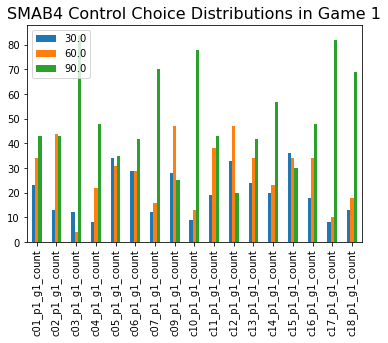

In [107]:
'''Here we place the number of times each hole was chosen by each subject in game 1 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''


c_g1_counts = pd.DataFrame([c01_p1_g1_count, c02_p1_g1_count, c03_p1_g1_count, c04_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c07_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c15_p1_g1_count,
                            c16_p1_g1_count, c17_p1_g1_count, c18_p1_g1_count],
         index=['c01_p1_g1_count', 'c02_p1_g1_count', 'c03_p1_g1_count', 'c04_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c07_p1_g1_count','c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c15_p1_g1_count', 'c16_p1_g1_count', 'c17_p1_g1_count', 'c18_p1_g1_count'])


#How to prevent NaN: df = df.fillna(0)
c_g1_counts = c_g1_counts.fillna(0)

#print
c_g1_counts


c_g1_counts.sum(axis=1)


c_g1_counts_bar = c_g1_counts.plot.bar()

c_g1_counts_bar.axes.set_title("SMAB4 Control Choice Distributions in Game 1",
                    fontsize=16)

# save as jpeg
c_g1_counts_bar.figure.savefig('c_g1_counts_bar.jpg',
                    format='jpeg',
                    dpi=100)

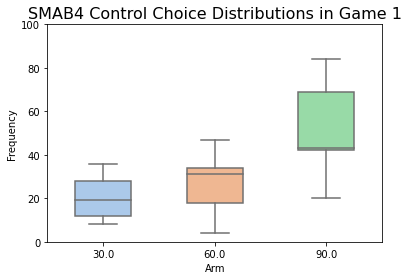

In [108]:
c_g1_counts_box = sns.boxplot( 
                 data=c_g1_counts, 
                 width=0.5,
                 palette="pastel")
c_g1_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="c_g1_counts_box.jpg"
 
plt.ylim(0, 100)
c_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [109]:
# In[158]:


#0 is low (30), 1 is med (60), 2 is high (90)
c_g1_low = np.mean(c_g1_counts.iloc[:,0])
c_g1_med = np.mean(c_g1_counts.iloc[:,1])
c_g1_high = np.mean(c_g1_counts.iloc[:,2])

In [110]:
c_g1_low_std = np.std(c_g1_counts.iloc[:,0])
c_g1_med_std = np.std(c_g1_counts.iloc[:,1])
c_g1_high_std = np.std(c_g1_counts.iloc[:,2])

In [111]:
c_g1_low, c_g1_med, c_g1_high

(19.941176470588236, 28.11764705882353, 50.529411764705884)

In [112]:
c_g1_low_std, c_g1_med_std, c_g1_high_std

(9.174585024981939, 12.512969050695677, 19.10071648504879)

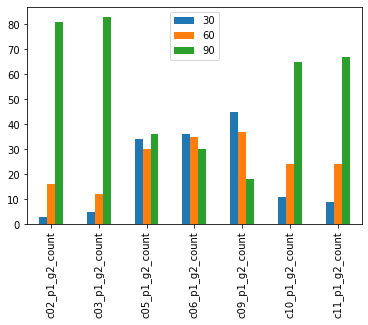

In [113]:
'''Here we place the number of times each hole was chosen by each subject in game 2 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''

c_g2_d_counts = pd.DataFrame([c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count],
         index=['c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
c_g2_d_counts = c_g2_d_counts.fillna(0)

#print
c_g2_d_counts


c_g2_d_counts.sum(axis=1)


c_g2_d_counts_bar = c_g2_d_counts.plot.bar()

# save as jpeg
c_g2_d_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

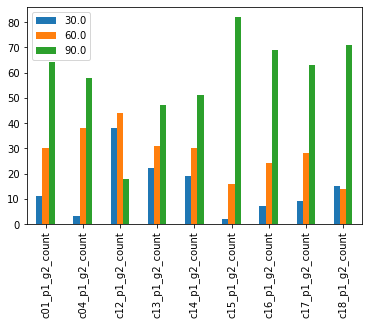

In [114]:
'''Here we place the number of times each hole was chosen by each subject in game 2 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''

c_g2_s_counts = pd.DataFrame([c01_p1_g2_count, c04_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c15_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count, c18_p1_g2_count],
         index=['c01_p1_g2_count', 'c04_p1_g2_count','c12_p1_g2_count', 'c13_p1_g2_count', 
                'c14_p1_g2_count', 'c15_p1_g2_count',
                'c16_p1_g2_count', 'c17_p1_g2_count', 'c18_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
c_g2_s_counts = c_g2_s_counts.fillna(0)

#print
c_g2_s_counts


c_g2_s_counts.sum(axis=1)


c_g2_s_counts_bar = c_g2_s_counts.plot.bar()

# save as jpeg
c_g2_s_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

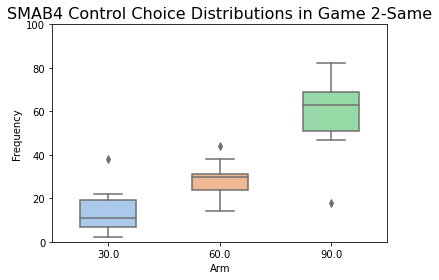

In [115]:
c_g2_s_counts_box = sns.boxplot( 
                 data=c_g2_s_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_s_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="c_g2_s_counts_box.jpg"
 
plt.ylim(0, 100)
c_g2_s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

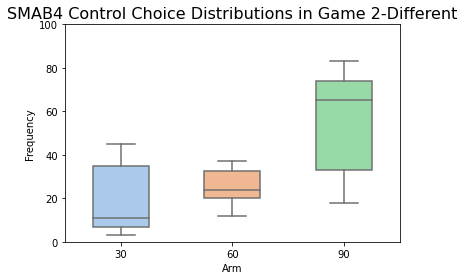

In [116]:
c_g2_d_counts_box = sns.boxplot( 
                 data=c_g2_d_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_d_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="c_g2_d_counts_box.jpg"
 
plt.ylim(0, 100)
c_g2_d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [117]:
c_g2_s_low = np.mean(c_g2_s_counts.iloc[:,0])
c_g2_s_med = np.mean(c_g2_s_counts.iloc[:,1])
c_g2_s_high = np.mean(c_g2_s_counts.iloc[:,2])

c_g2_d_low = np.mean(c_g2_d_counts.iloc[:,0])
c_g2_d_med = np.mean(c_g2_d_counts.iloc[:,1])
c_g2_d_high = np.mean(c_g2_d_counts.iloc[:,2])

In [118]:
c_g2_s_low_std = np.std(c_g2_s_counts.iloc[:,0])
c_g2_s_med_std = np.std(c_g2_s_counts.iloc[:,1])
c_g2_s_high_std = np.std(c_g2_s_counts.iloc[:,2])

c_g2_d_low_std = np.std(c_g2_d_counts.iloc[:,0])
c_g2_d_med_std = np.std(c_g2_d_counts.iloc[:,1])
c_g2_d_high_std = np.std(c_g2_d_counts.iloc[:,2])

# Reaction Time Analyses

In [119]:
'Here we get the reaction times'
'NEED to fix rewards for SMAB4'
time_c_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_c_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [120]:
time_c_1 = reaction_time(c02_p1_g1, time_c_1)
time_c_1 = reaction_time(c03_p1_g1, time_c_1)
time_c_1 = reaction_time(c05_p1_g1, time_c_1)
time_c_1 = reaction_time(c06_p1_g1, time_c_1)
time_c_1 = reaction_time(c09_p1_g1, time_c_1)
time_c_1 = reaction_time(c10_p1_g1, time_c_1)
time_c_1 = reaction_time(c11_p1_g1, time_c_1)
time_c_1 = reaction_time(c12_p1_g1, time_c_1)
time_c_1 = reaction_time(c13_p1_g1, time_c_1)
time_c_1 = reaction_time(c14_p1_g1, time_c_1)
time_c_1 = reaction_time(c15_p1_g1, time_c_1)
time_c_1 = reaction_time(c16_p1_g1, time_c_1)
time_c_1 = reaction_time(c17_p1_g1, time_c_1)
time_c_1 = reaction_time(c18_p1_g1, time_c_1)

In [121]:
time_c_1

,session,post win,post loss
0,c02_p1_g1,4.310843,4.483266
1,c03_p1_g1,3.233906,3.376468
2,c05_p1_g1,3.831172,3.794584
3,c06_p1_g1,3.367617,3.455480
4,c09_p1_g1,3.567952,3.557236
5,c10_p1_g1,3.213206,3.451479
6,c11_p1_g1,3.615086,4.014988
7,c12_p1_g1,3.721225,3.878290
8,c13_p1_g1,3.484952,3.786906
9,c14_p1_g1,3.311307,3.439066


In [122]:
time_c_2 = reaction_time(c02_p1_g2, time_c_2)
time_c_2 = reaction_time(c03_p1_g2, time_c_2)
time_c_2 = reaction_time(c05_p1_g2, time_c_2)
time_c_2 = reaction_time(c06_p1_g2, time_c_2)
time_c_2 = reaction_time(c09_p1_g2, time_c_2)
time_c_2 = reaction_time(c10_p1_g2, time_c_2)
time_c_2 = reaction_time(c11_p1_g2, time_c_2)
time_c_2 = reaction_time(c12_p1_g2, time_c_2)
time_c_2 = reaction_time(c13_p1_g2, time_c_2)
time_c_2 = reaction_time(c14_p1_g2, time_c_2)
time_c_2 = reaction_time(c15_p1_g2, time_c_2)
time_c_2 = reaction_time(c16_p1_g2, time_c_2)
time_c_2 = reaction_time(c17_p1_g2, time_c_2)
time_c_2 = reaction_time(c18_p1_g2, time_c_2)

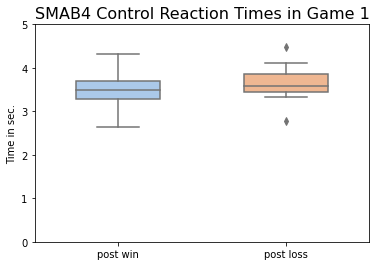

In [123]:
times_c_g1_box = sns.boxplot( 
                 data=time_c_1, 
                 width=0.5,
                 palette="pastel")
times_c_g1_box.axes.set_title("SMAB4 Control Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_c_g1_box.jpg"
 
plt.ylim(0, 5)
times_c_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_c_g1_box.figure.savefig(plot_file_name,format='jpeg')

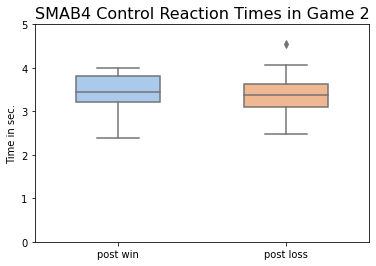

In [124]:
times_c_g2_box = sns.boxplot( 
                 data=time_c_2, 
                 width=0.5,
                 palette="pastel")
times_c_g2_box.axes.set_title("SMAB4 Control Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_c_g2_box.jpg"
 
plt.ylim(0, 5)
times_c_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_c_g2_box.figure.savefig(plot_file_name,format='jpeg')

In [125]:
np.mean(time_c_1)

post win     3.516535
post loss    3.645953
dtype: float64

In [126]:
np.mean(time_c_2)

post win     3.423937
post loss    3.395499
dtype: float64

In [127]:
np.std(time_c_1)

post win     0.399678
post loss    0.398324
dtype: float64

In [128]:
np.std(time_c_2)

post win     0.436234
post loss    0.536441
dtype: float64

In [129]:
sp.stats.ttest_rel(time_c_1['post win'],time_c_1['post loss'])

Ttest_relResult(statistic=-3.895131923798299, pvalue=0.0018430668367242645)

In [130]:
sp.stats.ttest_rel(time_c_2['post win'],time_c_2['post loss'])

Ttest_relResult(statistic=0.3910238480157525, pvalue=0.7021128497106475)

In [131]:
#not working
#sp.stats.ttest_rel(time_c_1['post win'],time_c_2['post win'])

In [132]:
#not working
#sp.stats.ttest_rel(time_c_1['post loss'],time_c_2['post loss'])

# Maximizing vs Matching

In [133]:
import math

In [134]:
'''
#TEST- JSD for multiple distributions
def entropy(prob_dist, base=math.e):
        return -sum([p * math.log(p,base) for p in prob_dist if p != 0])

def jsd(prob_dists, base=math.e):
    weight = 1/len(prob_dists) #all same weight
    js_left = [0,0,0]
    js_right = 0    
    for pd in prob_dists:
        js_left[0] += pd[0]*weight
        js_left[1] += pd[1]*weight
        js_left[2] += pd[2]*weight
        js_right += weight*entropy(pd,base)
    return entropy(js_left)-js_right'''

'\n#TEST- JSD for multiple distributions\ndef entropy(prob_dist, base=math.e):\n        return -sum([p * math.log(p,base) for p in prob_dist if p != 0])\n\ndef jsd(prob_dists, base=math.e):\n    weight = 1/len(prob_dists) #all same weight\n    js_left = [0,0,0]\n    js_right = 0    \n    for pd in prob_dists:\n        js_left[0] += pd[0]*weight\n        js_left[1] += pd[1]*weight\n        js_left[2] += pd[2]*weight\n        js_right += weight*entropy(pd,base)\n    return entropy(js_left)-js_right'

In [135]:
#NOTE: rewrite using pandas dataframe
# In[239]:

#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match,s01_g1_rand,s01_g1_soc = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match,s01_g2_rand,s01_g2_soc = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match,s03_g1_rand,s03_g1_soc = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match,s03_g2_rand,s03_g2_soc = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match,s05_g1_rand,s05_g1_soc= call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match,s05_g2_rand,s05_g2_soc = call_jsd([11, 0, 89])
s06_g1_max,s06_g1_match,s06_g1_rand,s06_g1_soc = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match,s06_g2_rand,s06_g2_soc = call_jsd(s06_p1_g2_count)
s07_g1_max,s07_g1_match,s07_g1_rand,s07_g1_soc = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match,s07_g2_rand,s07_g2_soc = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match,s08_g1_rand,s08_g1_soc = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match,s08_g2_rand,s08_g2_soc = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match,s09_g1_rand,s09_g1_soc = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match,s09_g2_rand,s09_g2_soc = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match,s11_g1_rand,s11_g1_soc = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match,s11_g2_rand,s11_g2_soc = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match,s12_g1_rand,s12_g1_soc = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match,s12_g2_rand,s12_g2_soc = call_jsd(s12_p1_g2_count)
s14_g1_max,s14_g1_match,s14_g1_rand,s14_g1_soc = call_jsd(s14_p1_g1_count)
s14_g2_max,s14_g2_match,s14_g2_rand,s14_g2_soc = call_jsd([2,0,98])
s15_g1_max,s15_g1_match,s15_g1_rand,s15_g1_soc = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match,s15_g2_rand,s15_g2_soc = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match,s16_g1_rand,s16_g1_soc = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match,s16_g2_rand,s16_g2_soc = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match,s17_g1_rand,s17_g1_soc = call_jsd(s17_p1_g1_count)
s17_g2_max,s17_g2_match,s17_g2_rand,s17_g2_soc = call_jsd([0,22,78])
s19_g1_max,s19_g1_match,s19_g1_rand,s19_g1_soc = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match,s19_g2_rand,s19_g2_soc = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match,s20_g1_rand,s20_g1_soc = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match,s20_g2_rand,s20_g2_soc = call_jsd(s20_p1_g2_count)
c01_g1_max,c01_g1_match,c01_g1_rand,c01_g1_soc = call_jsd(c01_p1_g1_count)
c01_g2_max,c01_g2_match,c01_g2_rand,c01_g2_soc = call_jsd(c01_p1_g2_count)
c02_g1_max,c02_g1_match,c02_g1_rand,c02_g1_soc = call_jsd(c02_p1_g1_count)
c02_g2_max,c02_g2_match,c02_g2_rand,c02_g2_soc = call_jsd(c02_p1_g2_count)
c03_g1_max,c03_g1_match,c03_g1_rand,c03_g1_soc = call_jsd(c03_p1_g1_count)
c03_g2_max,c03_g2_match,c03_g2_rand,c03_g2_soc = call_jsd(c03_p1_g2_count)
c04_g1_max,c04_g1_match,c04_g1_rand,c04_g1_soc = call_jsd(c04_p1_g1_count)
c04_g2_max,c04_g2_match,c04_g2_rand,c04_g2_soc = call_jsd(c04_p1_g2_count)
c05_g1_max,c05_g1_match,c05_g1_rand,c05_g1_soc = call_jsd(c05_p1_g1_count)
c05_g2_max,c05_g2_match,c05_g2_rand,c05_g2_soc = call_jsd(c05_p1_g2_count)
c06_g1_max,c06_g1_match,c06_g1_rand,c06_g1_soc = call_jsd(c06_p1_g1_count)
c06_g2_max,c06_g2_match,c06_g2_rand,c06_g2_soc = call_jsd(c06_p1_g1_count)
c07_g1_max,c07_g1_match,c07_g1_rand,c07_g1_soc = call_jsd(c07_p1_g1_count)
c07_g2_max,c07_g2_match,c07_g2_rand,c07_g2_soc = call_jsd(c07_p1_g1_count)
c09_g1_max,c09_g1_match,c09_g1_rand,c09_g1_soc = call_jsd(c09_p1_g1_count)
c09_g2_max,c09_g2_match,c09_g2_rand,c09_g2_soc = call_jsd(c09_p1_g2_count)
c10_g1_max,c10_g1_match,c10_g1_rand,c10_g1_soc = call_jsd(c10_p1_g1_count)
c10_g2_max,c10_g2_match,c10_g2_rand,c10_g2_soc = call_jsd(c10_p1_g2_count)
c11_g1_max,c11_g1_match,c11_g1_rand,c11_g1_soc = call_jsd(c11_p1_g1_count)
c11_g2_max,c11_g2_match,c11_g2_rand,c11_g2_soc= call_jsd(c11_p1_g2_count)
c12_g1_max,c12_g1_match,c12_g1_rand,c12_g1_soc = call_jsd(c12_p1_g1_count)
c12_g2_max,c12_g2_match,c12_g2_rand,c12_g2_soc = call_jsd(c12_p1_g2_count)
c13_g1_max,c13_g1_match,c13_g1_rand,c13_g1_soc  = call_jsd(c13_p1_g1_count)
c13_g2_max,c13_g2_match,c13_g2_rand,c13_g2_soc = call_jsd(c13_p1_g2_count)
c14_g1_max,c14_g1_match,c14_g1_rand,c14_g1_soc = call_jsd(c14_p1_g1_count)
c14_g2_max,c14_g2_match,c14_g2_rand,c14_g2_soc = call_jsd(c14_p1_g2_count)
c16_g1_max,c16_g1_match,c16_g1_rand,c16_g1_soc = call_jsd(c16_p1_g1_count)
c16_g2_max,c16_g2_match,c16_g2_rand,c16_g2_soc = call_jsd(c16_p1_g2_count)
c17_g1_max,c17_g1_match,c17_g1_rand,c17_g1_soc = call_jsd(c17_p1_g1_count)
c17_g2_max,c17_g2_match,c17_g2_rand,c17_g2_soc = call_jsd(c17_p1_g2_count)
c18_g1_max,c18_g1_match,c18_g1_rand,c18_g1_soc = call_jsd(c18_p1_g1_count)
c18_g2_max,c18_g2_match,c18_g2_rand,c18_g2_soc = call_jsd(c18_p1_g2_count)

In [136]:
max_vs_max, max_vs_match, d, c = call_jsd(maximize)

In [137]:
# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s14_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, 
                                      s19_g1_max, s20_g1_max, c01_g1_max, c02_g1_max, c03_g1_max, c04_g1_max, c05_g1_max, c06_g1_max, 
                                      c07_g1_max, c09_g1_max, c10_g1_max, c11_g1_max, c12_g1_max, c13_g1_max, c14_g1_max, 
                                      c16_g1_max, c17_g1_max, c18_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, 
                               s12_g1_match, s14_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, 
                               s20_g1_match, c01_g1_match, c02_g1_match, c03_g1_match, c04_g1_match, c05_g1_match, c06_g1_match, 
                                      c07_g1_match, c09_g1_match, c10_g1_match, c11_g1_match, c12_g1_match, c13_g1_match, c14_g1_match, 
                                      c16_g1_match, c17_g1_match, c18_g1_match],
                    'rand':[s01_g1_rand,s03_g1_rand,s05_g1_rand,s06_g1_rand,s07_g1_rand,s08_g1_rand,
                                s09_g1_rand, s11_g1_rand, s12_g1_rand, s14_g1_rand, s15_g1_rand, s16_g1_rand, s17_g1_rand, 
                                      s19_g1_rand, s20_g1_rand, c01_g1_rand, c02_g1_rand, c03_g1_rand, c04_g1_rand, c05_g1_rand, c06_g1_rand, 
                                      c07_g1_rand, c09_g1_rand, c10_g1_rand, c11_g1_rand, c12_g1_rand, c13_g1_rand, c14_g1_rand, 
                                      c16_g1_rand, c17_g1_rand, c18_g1_rand],
                        'soc':[s01_g1_soc,s03_g1_soc,s05_g1_soc,s06_g1_soc,s07_g1_soc,s08_g1_soc,
                                s09_g1_soc, s11_g1_soc, s12_g1_soc, s14_g1_soc, s15_g1_soc, s16_g1_soc, s17_g1_soc, 
                                      s19_g1_soc, s20_g1_soc, c01_g1_soc, c02_g1_soc, c03_g1_soc, c04_g1_soc, c05_g1_soc, c06_g1_soc, 
                                      c07_g1_soc, c09_g1_soc, c10_g1_soc, c11_g1_soc, c12_g1_soc, c13_g1_soc, c14_g1_soc, 
                                      c16_g1_soc, c17_g1_soc, c18_g1_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's14', 's15', 's16', 's17', 's19', 's20', 'c01', 'c02', 'c03', 
                               'c04','c05', 'c06', 'c07','c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17', 'c18'])

In [138]:
# In[ ]:


#closer to 0 = closer to that pure strategy
control_jsd_g1



# get the column name of min values in every row
strategy_control_jsd_g1 = control_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g1)


# In[ ]:


strategy_control_jsd_g1.value_counts()

min values of row are at following columns :
s01     rand
s03     rand
s05    match
s06    match
s07    match
s08      max
s09    match
s11     rand
s12    match
s14     rand
s15    match
s16     rand
s17      max
s19    match
s20     rand
c01     rand
c02    match
c03      max
c04     rand
c05     rand
c06     rand
c07    match
c09     rand
c10    match
c11    match
c12     rand
c13    match
c14    match
c16    match
c17    match
c18    match
dtype: object


match    16
rand     12
max       3
dtype: int64

In [139]:
control_jsd_g1

,max,match,rand,soc
s01,0.431875,0.060541,0.013773,0.013773
s03,0.313661,0.015698,0.001941,0.001941
s05,0.194304,0.003409,0.041901,0.041901
s06,0.091385,0.039518,0.095295,0.095295
s07,0.238287,0.005365,0.008818,0.008818
s08,0.028559,0.116763,0.207761,0.207761
s09,0.244099,0.001430,0.018617,0.018617
s11,0.300160,0.015397,0.000712,0.000712
s12,0.140003,0.016232,0.073835,0.073835
s14,0.665096,0.393220,0.261594,0.261594


In [140]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g2d = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, c02_g2_max, c03_g2_max, c05_g2_max, c06_g2_max, c07_g2_max,
                                      c09_g2_max, c10_g2_max, c11_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match,
                               s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, 
                                c02_g2_match, c03_g2_match, c05_g2_match, c06_g2_match, c07_g2_match,
                                      c09_g2_match, c10_g2_match, c11_g2_match],
                    'rand':[s01_g2_rand,s03_g2_rand,s05_g2_rand,s06_g2_rand,s07_g2_rand,s08_g2_rand,
                                s09_g2_rand, c02_g2_rand, c03_g2_rand, c05_g2_rand, c06_g2_rand, c07_g2_rand, 
                                      c09_g2_rand, c10_g2_rand, c11_g2_rand],
                        'soc':[s01_g2_soc,s03_g2_soc,s05_g2_soc,s06_g2_soc,s07_g2_soc,s08_g2_soc,
                                s09_g2_soc, c02_g2_soc, c03_g2_soc, c05_g2_soc, c06_g2_soc, c07_g2_soc,
                                      c09_g2_soc, c10_g2_soc, c11_g2_soc]},    
                        index=['s01', 's03','s05','s06','s07','s08','s09', 'c02', 'c03', 
                               'c05', 'c06', 'c07', 'c09', 'c10', 'c11'])

In [141]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g2s = pd.DataFrame({'max':[s11_g2_max, s12_g2_max, s14_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, 
                                      s19_g2_max, s20_g2_max, c01_g2_max, c04_g2_max, c12_g2_max, c13_g2_max, c14_g2_max, 
                                      c16_g2_max, c17_g2_max, c18_g2_max],
                      'match':[s11_g2_match, s12_g2_match, s14_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, 
                               s20_g2_match, c01_g2_match, c04_g2_match, c12_g2_match, c13_g2_match, c14_g2_match, 
                                      c16_g2_match, c17_g2_match, c18_g2_match],
                    'rand':[s11_g2_rand, s12_g2_rand, s14_g2_rand, s15_g2_rand, s16_g2_rand, s17_g2_rand, 
                                      s19_g2_rand, s20_g2_rand, c01_g2_rand, c04_g2_rand, c12_g2_rand, c13_g2_rand, c14_g2_rand, 
                                      c16_g2_rand, c17_g2_rand, c18_g2_rand],
                        'soc':[s11_g2_soc, s12_g2_soc, s14_g2_soc, s15_g2_soc, s16_g2_soc, s17_g2_soc, 
                                      s19_g2_soc, s20_g2_soc, c01_g2_soc, c04_g2_soc, c12_g2_soc, c13_g2_soc, c14_g2_soc, 
                                      c16_g2_soc, c17_g2_soc, c18_g2_soc]},
                              
                        index=['s11', 's12', 's14','s15', 's16', 's17', 's19', 's20', 'c01', 'c04', 'c12', 'c13', 'c14', 'c16', 'c17', 'c18'])

In [142]:
control_jsd_g2d

# get the column name of min values in every row
strategy_control_jsd_g2d = control_jsd_g2d.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g2d)



minValues_control_jsd_g2d = control_jsd_g2d.min()
 
print('minimum value in each column : ')
print(minValues_control_jsd_g2d)


# In[ ]:


maxValues_control_jsd_g2d = control_jsd_g2d.max()
 
print('maximum value in each column : ')
print(maxValues_control_jsd_g2d)


# In[ ]:


strategy_control_jsd_g2d.value_counts()


min values of row are at following columns :
s01     rand
s03     rand
s05      max
s06      max
s07    match
s08    match
s09    match
c02    match
c03      max
c05     rand
c06     rand
c07    match
c09     rand
c10    match
c11    match
dtype: object
minimum value in each column : 
max      0.039725
match    0.000196
rand     0.000712
soc      0.000712
dtype: float64
maximum value in each column : 
max      0.441162
match    0.146174
rand     0.210697
soc      0.210697
dtype: float64


match    7
rand     5
max      3
dtype: int64

In [143]:
control_jsd_g2s

# get the column name of min values in every row
strategy_control_jsd_g2s = control_jsd_g2s.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g2s)



minValues_control_jsd_g2s = control_jsd_g2s.min()
 
print('minimum value in each column : ')
print(minValues_control_jsd_g2s)


# In[ ]:


maxValues_control_jsd_g2s = control_jsd_g2s.max()
 
print('maximum value in each column : ')
print(maxValues_control_jsd_g2s)


# In[ ]:


strategy_control_jsd_g2s.value_counts()


min values of row are at following columns :
s11     rand
s12      max
s14      max
s15      max
s16     rand
s17    match
s19    match
s20    match
c01     rand
c04     rand
c12     rand
c13    match
c14    match
c16    match
c17    match
c18    match
dtype: object
minimum value in each column : 
max      0.006982
match    0.000845
rand     0.004098
soc      0.004098
dtype: float64
maximum value in each column : 
max      0.624791
match    0.188451
rand     0.282731
soc      0.282731
dtype: float64


match    8
rand     5
max      3
dtype: int64

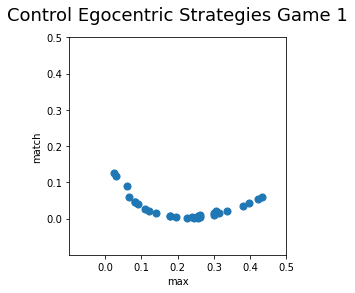

In [144]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

control_ego_jsd_g1_plot = control_jsd_g1.plot.scatter(x='max',y='match',s=50)
plt.title('Control Egocentric Strategies Game 1', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_1.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()

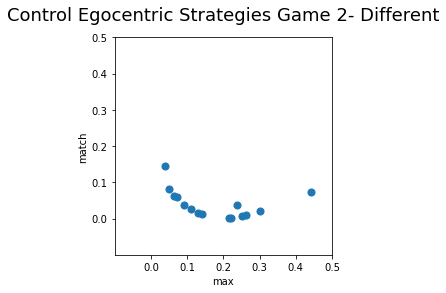

In [145]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g2d['max'], control_jsd_g2d['match'], 1)

control_ego_jsd_g2d_plot = control_jsd_g2d.plot.scatter(x='max',y='match',s=50)
plt.title('Control Egocentric Strategies Game 2- Different', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_2d.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()

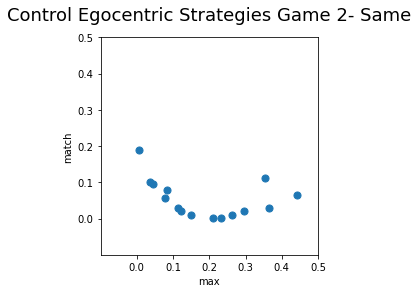

In [146]:
#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g2s['max'], control_jsd_g2s['match'], 1)

control_ego_jsd_g2s_plot = control_jsd_g2s.plot.scatter(x='max',y='match',s=50)
plt.title('Control Egocentric Strategies Game 2- Same', fontsize=18, y=1.05)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_2s.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()

# SMAB4 Joint Analysis

In [147]:
'''Here we load the csv files into Pandas dataframes by calling organize_trial_by_trial and get the score of each subject 
in each game by calling call_get_score.'''


df = organize_trial_by_trial('data/j01_gamedata.csv')
j01 = df
j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j01_p1_diff,j01_p2_diff,j01_p1_g1_50,j01_p1_g2_50,j01_p2_g1_50,j01_p2_g2_50= call_get_score(j01, 'j')
j01.head()

df = organize_trial_by_trial('data/j02_gamedata.csv')
j02 = df
j02_p1_g1_score,j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j02_p1_diff,j02_p2_diff,j02_p1_g1_50,j02_p1_g2_50,j02_p2_g1_50,j02_p2_g2_50 = call_get_score(j02, 'j')
j02.head()


df = organize_trial_by_trial('data/j03_gamedata.csv')
j03 = df
j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j03_p1_diff,j03_p2_diff,j03_p1_g1_50,j03_p1_g2_50,j03_p2_g1_50,j03_p2_g2_50 = call_get_score(j03, 'j')
j03.head()


df = organize_trial_by_trial('data/j04_gamedata.csv')
j04 = df
j04_p1_g1_score,j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j04_p1_diff,j04_p2_diff,j04_p1_g1_50,j04_p1_g2_50,j04_p2_g1_50,j04_p2_g2_50 = call_get_score(j04, 'j')
j04.head()


df = organize_trial_by_trial('data/j05_gamedata.csv')
j05 = df
j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j05_p1_diff,j05_p2_diff,j05_p1_g1_50,j05_p1_g2_50,j05_p2_g1_50,j05_p2_g2_50 = call_get_score(j05, 'j')
j05.head()


df = organize_trial_by_trial('data/j06_gamedata.csv')
j06 = df
j06_p1_g1_score,j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score,j06_p1_diff,j06_p2_diff,j06_p1_g1_50,j06_p1_g2_50,j06_p2_g1_50,j06_p2_g2_50 = call_get_score(j06, 'j')
j06.head()


df = organize_trial_by_trial('data/j07_gamedata.csv')
j07 = df
j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,j07_p2_g2_score,j07_p1_diff,j07_p2_diff,j07_p1_g1_50,j07_p1_g2_50,j07_p2_g1_50,j07_p2_g2_50 = call_get_score(j07, 'j')
j07.head()


df = organize_trial_by_trial('data/j08_gamedata.csv')
j08 = df
j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score,j08_p1_diff,j08_p2_diff,j08_p1_g1_50,j08_p1_g2_50,j08_p2_g1_50,j08_p2_g2_50 = call_get_score(j08, 'j')
j08.head()


df = organize_trial_by_trial_300('data/j10_gamedata2.csv')
j10 = df
j10_p1_g1_score,j10_p1_g2_score,j10_p2_g1_score,j10_p2_g2_score,j10_p1_diff,j10_p2_diff,j10_p1_g1_50,j10_p1_g2_50,j10_p2_g1_50,j10_p2_g2_50 = call_get_score(j10, 'j')
j10.head()


df = organize_trial_by_trial_300('data/j11_gamedata2.csv')
j11 = df
j11_p1_g1_score,j11_p1_g2_score,j11_p2_g1_score,j11_p2_g2_score,j11_p1_diff,j11_p2_diff,j11_p1_g1_50,j11_p1_g2_50,j11_p2_g1_50,j11_p2_g2_50 = call_get_score(j11, 'j')
j11.head()

#NEED to add j12 to other analyses
''''df = organize_trial_by_trial_300('data/j12_gamedata_old.csv')
j12 = df
j12_p1_g1_score,j12_p1_g2_score,j12_p2_g1_score,j12_p2_g2_score,j12_p1_diff,j12_p2_diff,j12_p1_g1_50,j12_p1_g2_50,j12_p2_g1_50,j12_p2_g2_50 = call_get_score(j12, 'j')
j12.head()'''

"'df = organize_trial_by_trial_300('data/j12_gamedata_old.csv')\nj12 = df\nj12_p1_g1_score,j12_p1_g2_score,j12_p2_g1_score,j12_p2_g2_score,j12_p1_diff,j12_p2_diff,j12_p1_g1_50,j12_p1_g2_50,j12_p2_g1_50,j12_p2_g2_50 = call_get_score(j12, 'j')\nj12.head()"

In [148]:
'''Here we separate the dataframes by suject and game by calling separate_df. We also create arrays with the number of
times that each subject chose each hole by calling value_counts.'''

j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')
j10_p1_g1, j10_p1_g2, j10_p2_g1, j10_p2_g2 = separate_df(j10, 'j')
j11_p1_g1, j11_p1_g2, j11_p2_g1, j11_p2_g2 = separate_df(j11, 'j')



j01_p1_g1_count = j01_p1_g1['probability'].value_counts(sort=False)
j01_p1_g2_count = j01_p1_g2['probability'].value_counts(sort=False)
j01_p2_g1_count = j01_p2_g1['probability'].value_counts(sort=False)
j01_p2_g2_count = j01_p2_g2['probability'].value_counts(sort=False)
j02_p1_g1_count = j02_p1_g1['probability'].value_counts(sort=False)
j02_p1_g2_count = j02_p1_g2['probability'].value_counts(sort=False)
j02_p2_g1_count = j02_p2_g1['probability'].value_counts(sort=False)
j02_p2_g2_count = j02_p2_g2['probability'].value_counts(sort=False)
j03_p1_g1_count = j03_p1_g1['probability'].value_counts(sort=False)
j03_p1_g2_count = j03_p1_g2['probability'].value_counts(sort=False)
j03_p2_g1_count = j03_p2_g1['probability'].value_counts(sort=False)
j03_p2_g2_count = j03_p2_g2['probability'].value_counts(sort=False)
j04_p1_g1_count = j04_p1_g1['probability'].value_counts(sort=False)
j04_p1_g2_count = j04_p1_g2['probability'].value_counts(sort=False)
j04_p2_g1_count = j04_p2_g1['probability'].value_counts(sort=False)
j04_p2_g2_count = j04_p2_g2['probability'].value_counts(sort=False)
j05_p1_g1_count = j05_p1_g1['probability'].value_counts(sort=False)
j05_p1_g2_count = j05_p1_g2['probability'].value_counts(sort=False)
j05_p2_g1_count = j05_p2_g1['probability'].value_counts(sort=False)
j05_p2_g2_count = j05_p2_g2['probability'].value_counts(sort=False)
j06_p1_g1_count = j06_p1_g1['probability'].value_counts(sort=False)
j06_p1_g2_count = j06_p1_g2['probability'].value_counts(sort=False)
j06_p2_g1_count = j06_p2_g1['probability'].value_counts(sort=False)
j06_p2_g2_count = j06_p2_g2['probability'].value_counts(sort=False)
j07_p1_g1_count = j07_p1_g1['probability'].value_counts(sort=False)
j07_p1_g2_count = j07_p1_g2['probability'].value_counts(sort=False)
j07_p2_g1_count = j07_p2_g1['probability'].value_counts(sort=False)
j07_p2_g2_count = j07_p2_g2['probability'].value_counts(sort=False)
j08_p1_g1_count = j08_p1_g1['probability'].value_counts(sort=False)
j08_p1_g2_count = j08_p1_g2['probability'].value_counts(sort=False)
j08_p2_g1_count = j08_p2_g1['probability'].value_counts(sort=False)
j08_p2_g2_count = j08_p2_g2['probability'].value_counts(sort=False)
j10_p1_g1_count = j10_p1_g1['probability'].value_counts(sort=False)
j10_p1_g2_count = j10_p1_g2['probability'].value_counts(sort=False)
j10_p2_g1_count = j10_p2_g1['probability'].value_counts(sort=False)
j10_p2_g2_count = j10_p2_g2['probability'].value_counts(sort=False)
j11_p1_g1_count = j11_p1_g1['probability'].value_counts(sort=False)
j11_p1_g2_count = j11_p1_g2['probability'].value_counts(sort=False)
j11_p2_g1_count = j11_p2_g1['probability'].value_counts(sort=False)
j11_p2_g2_count = j11_p2_g2['probability'].value_counts(sort=False)

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python

In [149]:
'''Here we mech the hole-probability mappings in each game for each player'''
j01_p1_g1_map = hole_prob_map(j01_p1_g1)
j01_p1_g2_map = hole_prob_map(j01_p1_g2)
j01_p2_g1_map = hole_prob_map(j01_p2_g1)
j01_p2_g2_map = hole_prob_map(j01_p2_g2)

j02_p1_g1_map = hole_prob_map(j02_p1_g1)
j02_p1_g2_map = hole_prob_map(j02_p1_g2)
j02_p2_g1_map = hole_prob_map(j02_p2_g1)
j02_p2_g2_map = hole_prob_map(j02_p2_g2)

j03_p1_g1_map = hole_prob_map(j03_p1_g1)
j03_p1_g2_map = hole_prob_map(j03_p1_g2)
j03_p2_g1_map = hole_prob_map(j03_p2_g1)
j03_p2_g2_map = hole_prob_map(j03_p2_g2)

j04_p1_g1_map = hole_prob_map(j04_p1_g1)
j04_p1_g2_map = hole_prob_map(j04_p1_g2)
j04_p2_g1_map = hole_prob_map(j04_p2_g1)
j04_p2_g2_map = hole_prob_map(j04_p2_g2)

j05_p1_g1_map = hole_prob_map(j05_p1_g1)
j05_p1_g2_map = hole_prob_map(j05_p1_g2)
j05_p2_g1_map = hole_prob_map(j05_p2_g1)
j05_p2_g2_map = hole_prob_map(j05_p2_g2)

j06_p1_g1_map = hole_prob_map(j06_p1_g1)
j06_p1_g2_map = hole_prob_map(j06_p1_g2)
j06_p2_g1_map = hole_prob_map(j06_p2_g1)
j06_p2_g2_map = hole_prob_map(j06_p2_g2)

j07_p1_g1_map = hole_prob_map(j07_p1_g1)
j07_p1_g2_map = hole_prob_map(j07_p1_g2)
j07_p2_g1_map = hole_prob_map(j07_p2_g1)
j07_p2_g2_map = hole_prob_map(j07_p2_g2)

j08_p1_g1_map = hole_prob_map(j08_p1_g1)
j08_p1_g2_map = hole_prob_map(j08_p1_g2)
j08_p2_g1_map = hole_prob_map(j08_p2_g1)
j08_p2_g2_map = hole_prob_map(j08_p2_g2)

j10_p1_g1_map = hole_prob_map(j10_p1_g1)
j10_p1_g2_map = hole_prob_map(j10_p1_g2)
j10_p2_g1_map = hole_prob_map(j10_p2_g1)
j10_p2_g2_map = hole_prob_map(j10_p2_g2)

#j11_p1_g1_map = hole_prob_map(j11_p1_g1)
#j11_p1_g2_map = hole_prob_map(j11_p1_g2)
#j11_p2_g1_map = hole_prob_map(j11_p2_g1)
#j11_p2_g2_map = hole_prob_map(j11_p2_g2)

In [150]:
'''Here we create dataframes with all of the scores of each subject in games 1 and 2. 50 refers to the score half-way
through the games'''


# # Combined Joint scores G1

j_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score]})
j_scores_1.set_index('participant', inplace=True, drop=True)
j_scores_1


# # Combined Joint scores G2

# In[ ]:


j_scores_2_d = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2'], 'score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score]})
j_scores_2_d.set_index('participant', inplace=True, drop=True)

j_scores_2_s = pd.DataFrame({'participant':['j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2':
     [j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score]})
j_scores_2_s.set_index('participant', inplace=True, drop=True)

j_scores_1_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1_50':
     [j01_p1_g1_50, j01_p2_g1_50, j02_p1_g1_50, j02_p2_g1_50, j03_p1_g1_50, j03_p2_g1_50,
      j04_p1_g1_50, j04_p2_g1_50, j05_p1_g1_50, j05_p2_g1_50, j06_p1_g1_50, j06_p2_g1_50,
      j07_p1_g1_50, j07_p2_g1_50, j08_p1_g1_50, j08_p2_g1_50, j10_p1_g1_50, j10_p2_g1_50, j11_p1_g1_50, j11_p2_g1_50]})
j_scores_1_50.set_index('participant', inplace=True, drop=True)




j_scores_2_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2_50':
     [j01_p1_g2_50, j01_p2_g2_50, j02_p1_g2_50, j02_p2_g2_50, j03_p1_g2_50, j03_p2_g2_50,
      j04_p1_g2_50, j04_p2_g2_50, j05_p1_g2_50, j05_p2_g2_50, j06_p1_g2_50, j06_p2_g2_50,
      j07_p1_g2_50, j07_p2_g2_50, j08_p1_g2_50, j08_p2_g2_50, j10_p1_g2_50, j10_p2_g2_50, j11_p1_g2_50, j11_p2_g2_50]})
j_scores_2_50.set_index('participant', inplace=True, drop=True)



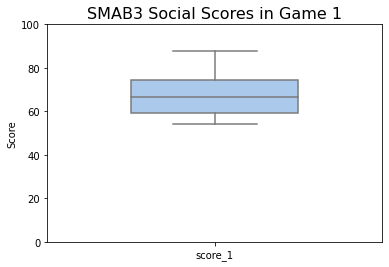

In [151]:
j_scores_1_box = sns.boxplot( 
                 data=j_scores_1, 
                 width=0.5,
                 palette="pastel")
j_scores_1_box.axes.set_title("SMAB3 Social Scores in Game 1",
                    fontsize=16)

plot_file_name="j_score_1_box.jpg"
 
plt.ylim(0, 100)
j_scores_1_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_1_box.figure.savefig(plot_file_name,
                    format='jpeg')

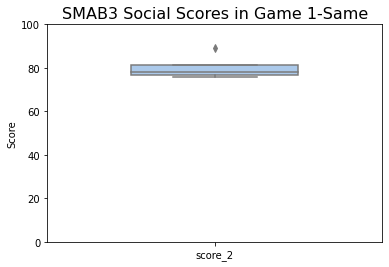

In [152]:
j_scores_2s_box = sns.boxplot( 
                 data=j_scores_2_s, 
                 width=0.5,
                 palette="pastel")
j_scores_2s_box.axes.set_title("SMAB3 Social Scores in Game 1-Same",
                    fontsize=16)

plot_file_name="j_score_2s_box.jpg"
 
plt.ylim(0, 100)
j_scores_2s_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_2s_box.figure.savefig(plot_file_name,
                    format='jpeg')

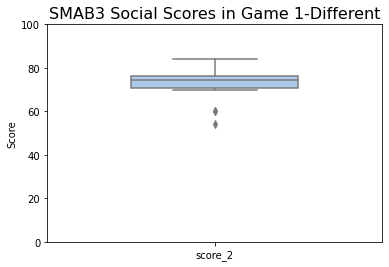

In [153]:
j_scores_2d_box = sns.boxplot( 
                 data=j_scores_2_d, 
                 width=0.5,
                 palette="pastel")
j_scores_2d_box.axes.set_title("SMAB3 Social Scores in Game 1-Different",
                    fontsize=16)

plot_file_name="j_score_2d_box.jpg"
 
plt.ylim(0, 100)
j_scores_2d_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_2d_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [154]:
j_scores_2s_mean = j_scores_2_s.mean()

In [155]:
j_scores_2d_mean = j_scores_2_d.mean()

In [156]:
j_scores_2s_std = j_scores_2_s.std()

In [157]:
j_scores_2d_std = j_scores_2_d.std()

In [158]:
j_scores_2s_mean, j_scores_2s_std

(score_2    80.25
 dtype: float64,
 score_2    5.965177
 dtype: float64)

In [159]:
j_scores_2d_mean, j_scores_2d_std

(score_2    72.6875
 dtype: float64,
 score_2    8.42788
 dtype: float64)

In [160]:
sp.stats.ttest_ind(j_scores_2_s, j_scores_2_d)

Ttest_indResult(statistic=array([1.67640168]), pvalue=array([0.11094111]))

In [161]:
s_scores_2_s.size

8

In [162]:
'''Here we get the mean, median, and standard deviation of the scores. We also run a t-test comparing the scores in games 1 and 2
and plot the data.'''

j_scores_1_mean = j_scores_1.mean()


# In[ ]:


j_scores_1_mean


# In[ ]:


j_scores_1_std = j_scores_1.std()


# In[ ]:


j_scores_1_std

score_1    9.653333
dtype: float64

In [163]:
#j_scores_p = sp.stats.ttest_rel(j_scores['Game 1'],j_scores['Game 2'])

In [164]:
len(j_scores_1)

20

In [165]:
'''
j_scores_box = sns.boxplot( 
                 data=j_scores, 
                 width=0.5,
                 palette="pastel")
j_scores_box.axes.set_title("SMAB3 Social Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_scores_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')'''

'\nj_scores_box = sns.boxplot( \n                 data=j_scores, \n                 width=0.5,\n                 palette="pastel")\nj_scores_box.axes.set_title("SMAB3 Social Scores",\n                    fontsize=16)\n\nplot_file_name="j_score_box.jpg"\n \nplt.ylim(0, 100)\nj_scores_box.axes.set(ylabel=\'Score\')\n\n# save as jpeg\nj_scores_box.figure.savefig(plot_file_name,\n                    format=\'jpeg\')'

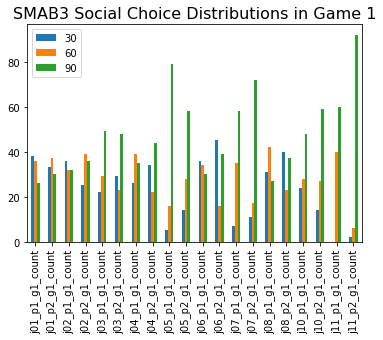

In [166]:
'''Here we place all of the data into the number of times each subject chose each hole into dataframes for games 1 
and 2. We plot this data and run statistics on it.'''

# # Joint combined choices in G1



j_g1_counts = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count'])


# In[ ]:


j_g1_counts = j_g1_counts.fillna(0)


# In[ ]:


j_g1_counts 


# In[ ]:


j_g1_counts.sum(axis=1)


# In[ ]:


j_g1_counts_bar = j_g1_counts.plot.bar()

j_g1_counts_bar.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

j_g1_counts_bar.figure.savefig("j_g1_counts_bar.jpg",
                    format='jpeg')

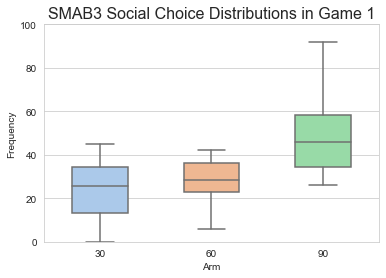

In [167]:
# In[ ]:
sns.set_style("whitegrid")

j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"
 
plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')


# In[ ]:

In [168]:
j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low


# In[ ]:


j_g1_med


# In[ ]:


j_g1_high


# In[ ]:


j_g1_low_std = np.std(j_g1_counts.iloc[:,0])
j_g1_med_std = np.std(j_g1_counts.iloc[:,1])
j_g1_high_std = np.std(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low_std


# In[ ]:


j_g1_med_std


# In[ ]:


j_g1_high_std

17.746760267722106

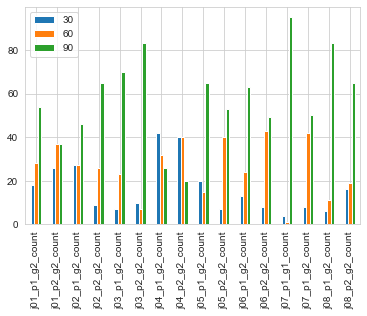

In [169]:
# # Joint combined choices in G2


j_g2_d_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g1_count', 'j07_p1_g2_count', 
                 'j08_p1_g2_count', 'j08_p2_g2_count'])



j_g2_d_counts = j_g2_d_counts.fillna(0)



j_g2_d_counts.sum(axis=1)



j_g2_d_counts_bar = j_g2_d_counts.plot.bar()

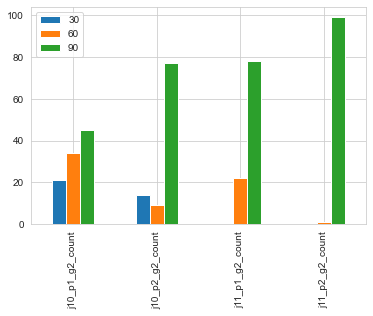

In [170]:
j_g2_s_counts = pd.DataFrame([j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count],
                index = ['j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count'])



j_g2_s_counts = j_g2_s_counts.fillna(0)



j_g2_s_counts.sum(axis=1)



j_g2_s_counts_bar = j_g2_s_counts.plot.bar()

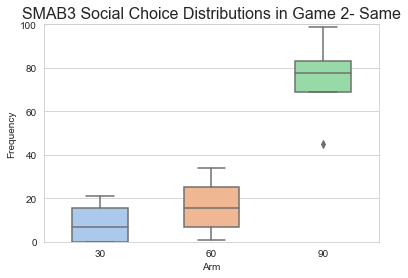

In [171]:
# In[ ]:


j_g2_s_counts_box = sns.boxplot( 
                 data=j_g2_s_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_s_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 2- Same",
                    fontsize=16)

plot_file_name="j_g2_s_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

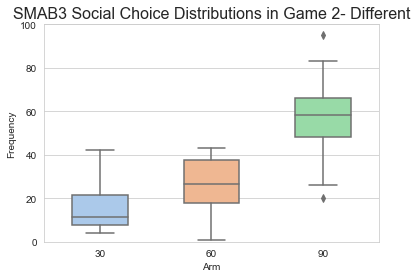

In [172]:
j_g2_d_counts_box = sns.boxplot( 
                 data=j_g2_d_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_d_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 2- Different",
                    fontsize=16)

plot_file_name="j_g2_d_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [173]:
j_scores_1

,score_1
participant,
j01_p1,57
j01_p2,61
j02_p1,54
j02_p2,68
j03_p1,69
j03_p2,67
j04_p1,64
j04_p2,56
j05_p1,77


In [174]:
j_scores_1_mean

score_1    66.85
dtype: float64

In [175]:
j_scores_1_std

score_1    9.653333
dtype: float64

In [176]:
# In[ ]:

j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])

j_g2_s_low = np.mean(j_g2_s_counts.iloc[:,0])
j_g2_s_med = np.mean(j_g2_s_counts.iloc[:,1])
j_g2_s_high = np.mean(j_g2_s_counts.iloc[:,2])

j_g2_d_low = np.mean(j_g2_d_counts.iloc[:,0])
j_g2_d_med = np.mean(j_g2_d_counts.iloc[:,1])
j_g2_d_high = np.mean(j_g2_d_counts.iloc[:,2])

In [177]:
j_g1_low, j_g1_med, j_g1_high

(23.6, 28.45, 47.95)

In [178]:
j_g1_low_std, j_g1_med_std, j_g1_high_std

(13.268006632497586, 9.499868420141407, 17.746760267722106)

In [179]:
j_g1_counts

,30,60,90
j01_p1_g1_count,38.0,36.0,26.0
j01_p2_g1_count,33.0,37.0,30.0
j02_p1_g1_count,36.0,32.0,32.0
j02_p2_g1_count,25.0,39.0,36.0
j03_p1_g1_count,22.0,29.0,49.0
j03_p2_g1_count,29.0,23.0,48.0
j04_p1_g1_count,26.0,39.0,35.0
j04_p2_g1_count,34.0,22.0,44.0
j05_p1_g1_count,5.0,16.0,79.0
j05_p2_g1_count,14.0,28.0,58.0


# Reaction Time

In [180]:
'Here we get the reaction times'
time_j_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_j_2 = pd.DataFrame(columns = ['session','post win','post loss'])

In [181]:
time_j_1 = reaction_time(j01_p1_g1, time_j_1)
time_j_1 = reaction_time(j02_p1_g1, time_j_1)
time_j_1 = reaction_time(j03_p1_g1, time_j_1)
time_j_1 = reaction_time(j04_p1_g1, time_j_1)
time_j_1 = reaction_time(j05_p1_g1, time_j_1)
time_j_1 = reaction_time(j06_p1_g1, time_j_1)
time_j_1 = reaction_time(j07_p1_g1, time_j_1)
time_j_1 = reaction_time(j08_p1_g1, time_j_1)
time_j_1 = reaction_time(j10_p1_g1, time_j_1)
time_j_1 = reaction_time(j11_p1_g1, time_j_1)

In [182]:
time_j_2 = reaction_time(j01_p1_g2, time_j_2)
time_j_2 = reaction_time(j02_p1_g2, time_j_2)
time_j_2 = reaction_time(j03_p1_g2, time_j_2)
time_j_2 = reaction_time(j04_p1_g2, time_j_2)
time_j_2 = reaction_time(j05_p1_g2, time_j_2)
time_j_2 = reaction_time(j06_p1_g2, time_j_2)
time_j_2 = reaction_time(j07_p1_g2, time_j_2)
time_j_2 = reaction_time(j08_p1_g2, time_j_2)
time_j_2 = reaction_time(j10_p1_g2, time_j_2)
time_j_2 = reaction_time(j11_p1_g2, time_j_2)

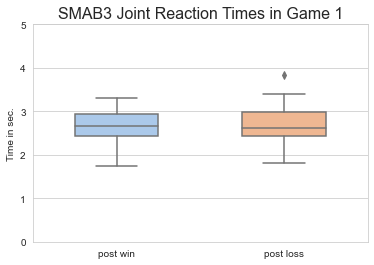

In [183]:
times_j_g1_box = sns.boxplot( 
                 data=time_j_1, 
                 width=0.5,
                 palette="pastel")
times_j_g1_box.axes.set_title("SMAB3 Joint Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_j_g1_box.jpg"
 
plt.ylim(0, 5)
times_j_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_j_g1_box.figure.savefig(plot_file_name,format='jpeg')

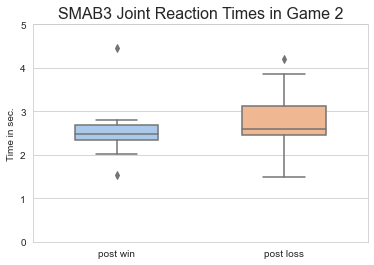

In [184]:
times_j_g2_box = sns.boxplot( 
                 data=time_j_2, 
                 width=0.5,
                 palette="pastel")
times_j_g2_box.axes.set_title("SMAB3 Joint Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_j_g2_box.jpg"
 
plt.ylim(0, 5)
times_j_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_j_g2_box.figure.savefig(plot_file_name,format='jpeg')

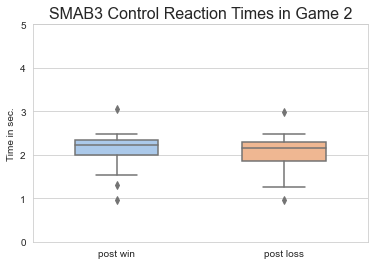

In [185]:
times_s_g2_box = sns.boxplot( 
                 data=time_s_2, 
                 width=0.5,
                 palette="pastel")
times_s_g2_box.axes.set_title("SMAB3 Control Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_s_g2_box.jpg"
 
plt.ylim(0, 5)
times_s_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_s_g2_box.figure.savefig(plot_file_name,format='jpeg')

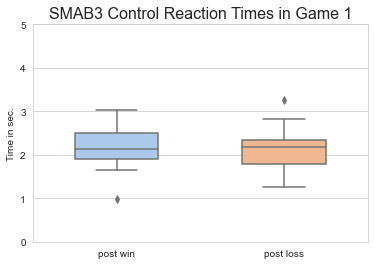

In [186]:
times_s_g1_box = sns.boxplot( 
                 data=time_s_1, 
                 width=0.5,
                 palette="pastel")
times_s_g1_box.axes.set_title("SMAB3 Control Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_s_g1_box.jpg"
 
plt.ylim(0, 5)
times_s_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_s_g1_box.figure.savefig(plot_file_name,format='jpeg')

In [187]:
np.mean(time_s_1)

post win     2.143281
post loss    2.156833
dtype: float64

In [188]:
np.mean(time_s_2)

post win     2.095491
post loss    2.040904
dtype: float64

In [189]:
np.std(time_s_1)

post win     0.501875
post loss    0.504602
dtype: float64

In [190]:
np.std(time_s_2)

post win     0.539784
post loss    0.528833
dtype: float64

In [191]:
np.mean(time_j_1)

post win     3.003842
post loss    2.743744
dtype: float64

In [192]:
np.mean(time_j_2)

post win     2.571192
post loss    2.772587
dtype: float64

In [193]:
np.std(time_j_1)

post win     1.287668
post loss    0.547701
dtype: float64

In [194]:
np.std(time_j_2)

post win     0.715499
post loss    0.768199
dtype: float64

In [195]:
sp.stats.ttest_rel(time_s_1['post win'],time_s_1['post loss'])

Ttest_relResult(statistic=-0.22232713395530926, pvalue=0.8277981973516864)

In [196]:
sp.stats.ttest_rel(time_s_2['post win'],time_s_2['post loss'])

Ttest_relResult(statistic=1.6133551404642006, pvalue=0.1349630881166298)

In [197]:
sp.stats.ttest_rel(time_j_1['post win'],time_j_1['post loss'])

Ttest_relResult(statistic=0.8796229730498023, pvalue=0.40193938606783575)

In [198]:
sp.stats.ttest_rel(time_j_2['post win'],time_j_2['post loss'])

Ttest_relResult(statistic=-1.240209628973232, pvalue=0.24625663257219957)

# SMAB4 Joint Data 

In [199]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.
Note: for the files that were hand coded, the scores will be obtained later, as the score column needs to be filled out still.'''

# # Multi Analysis

df = organize_trial_by_trial_hand_code2('data/m01_gamedata_handcode.csv')
m01 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m01.head()

df = organize_trial_by_trial_hand_code2('data/m03_gamedata_handcode.csv')
m03 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m03.head()

df = organize_trial_by_trial('data/m05_gamedata.csv')
m05 = df
m05_p1_g1_score,m05_p1_g2_score,m05_p2_g1_score,m05_p2_g2_score,m05_p1_diff,m05_p2_diff,m05_p1_g1_50,m05_p1_g2_50,m05_p2_g1_50,m05_p2_g2_50 = call_get_score(m05, 'm')
m05.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m06_gamedata2.csv')
m06 = df
m06_p1_g1_score,m06_p1_g2_score,m06_p2_g1_score,m06_p2_g2_score,m06_p1_diff,m06_p2_diff,m06_p1_g1_50,m06_p1_g2_50,m06_p2_g1_50,m06_p2_g2_50 = call_get_score(m06, 'm')
m06.head()


df = organize_trial_by_trial_hand_code2('data/m07_gamedata_handcode.csv')
m07 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m07.head()

#m09 from LSL needs to be combined with hand coded
df = organize_trial_by_trial_hand_code('data/m09_gamedata_handcode.csv')
m09 = df
#m01_p1_g1_score,m01_p1_g2_score,m01_p2_g1_score,m01_p2_g2_score,m01_p1_diff,m01_p2_diff,m01_p1_g1_50,m01_p1_g2_50,m01_p2_g1_50,m01_p2_g2_50 = call_get_score(m01, 'm')
m09.head()

df = organize_trial_by_trial('data/m09_gamedata.csv')
m09_lsl = df
#m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_diff,m08_p2_diff,m08_p1_g1_50,m08_p1_g2_50,m08_p2_g1_50,m08_p2_g2_50 = call_get_score(m08, 'm')
m09.head()

df = organize_trial_by_trial_300('data/m08_gamedata2.csv')
m08 = df
m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_diff,m08_p2_diff,m08_p1_g1_50,m08_p1_g2_50,m08_p2_g1_50,m08_p2_g2_50 = call_get_score(m08, 'm')
m08.head()


# In[ ]:


# In[ ]:


df = organize_trial_by_trial_300('data/m10_gamedata2.csv')
m10 = df
m10_p1_g1_score,m10_p1_g2_score,m10_p2_g1_score,m10_p2_g2_score,m10_p1_diff,m10_p2_diff,m10_p1_g1_50,m10_p1_g2_50,m10_p2_g1_50,m10_p2_g2_50 = call_get_score(m10, 'm')
m10.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m11_gamedata2.csv')
m11 = df
m11_p1_g1_score,m11_p1_g2_score,m11_p2_g1_score,m11_p2_g2_score,m11_p1_diff,m11_p2_diff,m11_p1_g1_50,m11_p1_g2_50,m11_p2_g1_50,m11_p2_g2_50 = call_get_score(m11, 'm')
m11.head()


# In[ ]:

#session ends early
#df = organize_trial_by_trial_floatclick('data/m12_gamedata.csv')
#m12 = df
#m12_p1_g1_score,m12_p1_g2_score,m12_p2_g1_score,m12_p2_g2_score,m12_p1_score_diff,m12_p2_score_diff = call_get_score(m12, 'm')
#m12.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m13_gamedata2.csv')
m13 = df
m13_p1_g1_score,m13_p1_g2_score,m13_p2_g1_score,m13_p2_g2_score,m13_p1_diff,m13_p2_diff,m13_p1_g1_50,m13_p1_g2_50,m13_p2_g1_50,m13_p2_g2_50 = call_get_score(m13, 'm')
m13.head()


# In[ ]:


df = organize_trial_by_trial_300('data/m14_gamedata2.csv')
m14 = df
m14_p1_g1_score,m14_p1_g2_score,m14_p2_g1_score,m14_p2_g2_score,m14_p1_diff,m14_p2_diff,m14_p1_g1_50,m14_p1_g2_50,m14_p2_g1_50,m14_p2_g2_50 = call_get_score(m14, 'm')
m14.head()


# In[ ]:


m05_p1_g1, m05_p1_g2, m05_p2_g1, m05_p2_g2 = separate_df(m05, 'm')
m06_p1_g1, m06_p1_g2, m06_p2_g1, m06_p2_g2 = separate_df(m06, 'm')
m07_p1_g1, m07_p1_g2, m07_p2_g1, m07_p2_g2 = separate_df(m07, 'm')
m08_p1_g1, m08_p1_g2, m08_p2_g1, m08_p2_g2 = separate_df(m08, 'm')
m10_p1_g1, m10_p1_g2, m10_p2_g1, m10_p2_g2 = separate_df(m10, 'm')
m11_p1_g1, m11_p1_g2, m11_p2_g1, m11_p2_g2 = separate_df(m11, 'm')
m13_p1_g1, m13_p1_g2, m13_p2_g1, m13_p2_g2 = separate_df(m13, 'm')

m14_p1_g1, m14_p1_g2, m14_p2_g1, m14_p2_g2 = separate_df(m14, 'm')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python

In [200]:
m01_p1_counts, m01_p2_counts, m01_p1_probs, m01_p2_probs = handcode_calc_prob(m01)
m03_p1_counts, m03_p2_counts, m03_p1_probs, m03_p2_probs = handcode_calc_prob(m03)
m07_p1_counts, m07_p2_counts, m07_p1_probs, m07_p2_probs = handcode_calc_prob(m07)

In [201]:
m01 = fill_in_prob(m01, 90,60,30,60,30,90,30,60,90,60,90,30)
m03 = fill_in_prob(m01, 30,90,60,90,30,60,90,30,60,30,90,60)
m07 = fill_in_prob(m07, 30,90,60,90,30,60,90,30,60,30,90,60)

In [202]:
m01_p1_g1, m01_p1_g2, m01_p2_g1, m01_p2_g2 = separate_df(m01, 'm')
m03_p1_g1, m03_p1_g2, m03_p2_g1, m03_p2_g2 = separate_df(m03, 'm')
m07_p1_g1, m07_p1_g2, m07_p2_g1, m07_p2_g2 = separate_df(m07, 'm')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python

In [203]:
'''Here we check the probability-hole mappings for each player in each game'''
m01_p1_g1_map = hole_prob_map(m01_p1_g1)
m01_p1_g2_map = hole_prob_map(m01_p1_g2)
m01_p2_g1_map = hole_prob_map(m01_p2_g1)

m03_p2_g2_map = hole_prob_map(m03_p2_g2)
m03_p1_g1_map = hole_prob_map(m03_p1_g1)
m03_p1_g2_map = hole_prob_map(m03_p1_g2)
m03_p2_g1_map = hole_prob_map(m03_p2_g1)
m03_p2_g2_map = hole_prob_map(m03_p2_g2)

m05_p1_g1_map = hole_prob_map(m05_p1_g1)
m05_p1_g2_map = hole_prob_map(m05_p1_g2)
m05_p2_g1_map = hole_prob_map(m05_p2_g1)
m05_p2_g2_map = hole_prob_map(m05_p2_g2)

m06_p1_g1_map = hole_prob_map(m06_p1_g1)
m06_p1_g2_map = hole_prob_map(m06_p1_g2)
m06_p2_g1_map = hole_prob_map(m06_p2_g1)
m06_p2_g2_map = hole_prob_map(m06_p2_g2)

m07_p1_g1_map = hole_prob_map(m07_p1_g1)
#m07_p1_g2_map = hole_prob_map(m07_p1_g2)
m07_p2_g1_map = hole_prob_map(m07_p2_g1)
#m07_p2_g2_map = hole_prob_map(m07_p2_g2)

m08_p1_g1_map = hole_prob_map(m08_p1_g1)
m08_p1_g2_map = hole_prob_map(m08_p1_g2)
m08_p2_g1_map = hole_prob_map(m08_p2_g1)
m08_p2_g2_map = hole_prob_map(m08_p2_g2)

m10_p1_g1_map = hole_prob_map(m10_p1_g1)
m10_p1_g2_map = hole_prob_map(m10_p1_g2)
m10_p2_g1_map = hole_prob_map(m10_p2_g1)
m10_p2_g2_map = hole_prob_map(m10_p2_g2)

m11_p1_g1_map = hole_prob_map(m11_p1_g1)
#m11_p1_g2_map = hole_prob_map(m11_p1_g2)
m11_p2_g1_map = hole_prob_map(m11_p2_g1)
#m11_p2_g2_map = hole_prob_map(m11_p2_g2)

m13_p1_g1_map = hole_prob_map(m13_p1_g1)
m13_p1_g2_map = hole_prob_map(m13_p1_g2)
m13_p2_g1_map = hole_prob_map(m13_p2_g1)
m13_p2_g2_map = hole_prob_map(m13_p2_g2)

In [204]:
m01_p1_g1_score = m01_p1_g1['reward'].sum()
m01_p1_g2_score = m01_p1_g2['reward'].sum()
m01_p2_g1_score = m01_p2_g1['reward'].sum()
m01_p2_g2_score = m01_p2_g2['reward'].sum()

m03_p1_g1_score = m03_p1_g1['reward'].sum()
m03_p1_g2_score = m03_p1_g2['reward'].sum()
m03_p2_g1_score = m03_p2_g1['reward'].sum()
m03_p2_g2_score = m03_p2_g2['reward'].sum()

m07_p1_g1_score = m07_p1_g1['reward'].sum()
m07_p1_g2_score = m07_p1_g2['reward'].sum()
m07_p2_g1_score = m07_p2_g1['reward'].sum()
m07_p2_g2_score = m07_p2_g2['reward'].sum()

In [205]:
m01_p1_g2

,game number,trial,player,arm,probability,reward,time,comment 1,comment 2
200,2,1,1,3,60.0,0,1900-01-01 00:13:02.702,NaT,
202,2,3,1,1,90.0,1,1900-01-01 00:13:09.572,NaT,
204,2,5,1,3,60.0,1,1900-01-01 00:13:15.470,NaT,
206,2,7,1,2,30.0,1,1900-01-01 00:13:21.267,NaT,
208,2,9,1,1,90.0,0,1900-01-01 00:13:27.969,NaT,
...,...,...,...,...,...,...,...,...,...
390,2,191,1,3,60.0,0,1900-01-01 00:23:20.902,NaT,
392,2,193,1,2,30.0,0,1900-01-01 00:23:28.040,NaT,
394,2,195,1,3,60.0,1,1900-01-01 00:23:33.536,NaT,
396,2,197,1,3,60.0,1,1900-01-01 00:23:39.434,NaT,


In [206]:
# In[ ]:
#Not working for m01 and m07 (hand coded)- need to fill in the probability column
m01_p1_g1_count = m01_p1_g1['probability'].value_counts(sort=False)
m01_p1_g2_count = m01_p1_g2['probability'].value_counts(sort=False)
m01_p2_g1_count = m01_p2_g1['probability'].value_counts(sort=False)
m01_p2_g2_count = m01_p2_g2['probability'].value_counts(sort=False)
m03_p1_g1_count = m03_p1_g1['probability'].value_counts(sort=False)
m03_p1_g2_count = m03_p1_g2['probability'].value_counts(sort=False)
m03_p2_g1_count = m03_p2_g1['probability'].value_counts(sort=False)
m03_p2_g2_count = m03_p2_g2['probability'].value_counts(sort=False)

m05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)
m05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)
m05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)
m05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)

m07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)
m07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)
m07_p2_g1_count = m07_p2_g1['probability'].value_counts(sort=False)
m07_p2_g2_count = m07_p2_g2['probability'].value_counts(sort=False)

In [207]:
#same_probs_g1_2
m06_p1_g1_count = m06_p1_g1['probability'].value_counts(sort=False)
m06_p1_g2_count = m06_p1_g2['probability'].value_counts(sort=False)
m06_p2_g1_count = m06_p2_g1['probability'].value_counts(sort=False)
m06_p2_g2_count = m06_p2_g2['probability'].value_counts(sort=False)
m07_p1_g1_count = m07_p1_g1['probability'].value_counts(sort=False)
m07_p1_g2_count = m07_p1_g2['probability'].value_counts(sort=False)
m07_p2_g1_count = m07_p2_g1['probability'].value_counts(sort=False)
m07_p2_g2_count = m07_p2_g2['probability'].value_counts(sort=False)
m08_p1_g1_count = m08_p1_g1['probability'].value_counts(sort=False)
m08_p1_g2_count = m08_p1_g2['probability'].value_counts(sort=False)
m08_p2_g1_count = m08_p2_g1['probability'].value_counts(sort=False)
m08_p2_g2_count = m08_p2_g2['probability'].value_counts(sort=False)
m10_p1_g1_count = m10_p1_g1['probability'].value_counts(sort=False)
m10_p1_g2_count = m10_p1_g2['probability'].value_counts(sort=False)
m10_p2_g1_count = m10_p2_g1['probability'].value_counts(sort=False)
m10_p2_g2_count = m10_p2_g2['probability'].value_counts(sort=False)
m11_p1_g1_count = m11_p1_g1['probability'].value_counts(sort=False)
m11_p1_g2_count = m11_p1_g2['probability'].value_counts(sort=False)
m11_p2_g1_count = m11_p2_g1['probability'].value_counts(sort=False)
m11_p2_g2_count = m11_p2_g2['probability'].value_counts(sort=False)
m13_p1_g1_count = m13_p1_g1['probability'].value_counts(sort=False)
m13_p1_g2_count = m13_p1_g2['probability'].value_counts(sort=False)
m13_p2_g1_count = m13_p2_g1['probability'].value_counts(sort=False)
m13_p2_g2_count = m13_p2_g2['probability'].value_counts(sort=False)
m14_p1_g1_count = m14_p1_g1['probability'].value_counts(sort=False)
m14_p1_g2_count = m14_p1_g2['probability'].value_counts(sort=False)
m14_p2_g1_count = m14_p2_g1['probability'].value_counts(sort=False)
m14_p2_g2_count = m14_p2_g2['probability'].value_counts(sort=False)

In [208]:
#call fix_reward on all of the files imported with '300' to fix the reward column
m06_p1_g1 = fix_reward(m06_p1_g1)
m06_p1_g2 = fix_reward(m06_p1_g2)
m06_p2_g1 = fix_reward(m06_p2_g1)
m06_p2_g2 = fix_reward(m06_p2_g2)
m08_p1_g1 = fix_reward(m08_p1_g1)
m08_p1_g2 = fix_reward(m08_p1_g2)
m08_p2_g1 = fix_reward(m08_p2_g1)
m08_p2_g2 = fix_reward(m08_p2_g2)
m10_p1_g1 = fix_reward(m10_p1_g1)
m10_p1_g2 = fix_reward(m10_p1_g2)
m10_p2_g1 = fix_reward(m10_p2_g1)
m10_p2_g2 = fix_reward(m10_p2_g2)
m11_p1_g1 = fix_reward(m11_p1_g1)
m11_p1_g2 = fix_reward(m11_p1_g2)
m11_p2_g1 = fix_reward(m11_p2_g1)
m11_p2_g2 = fix_reward(m11_p2_g2)
m13_p1_g1 = fix_reward(m13_p1_g1)
m13_p1_g2 = fix_reward(m13_p1_g2)
m13_p2_g1 = fix_reward(m13_p2_g1)
m13_p2_g2 = fix_reward(m13_p2_g2)
m14_p1_g1 = fix_reward(m14_p1_g1)
m14_p1_g2 = fix_reward(m14_p1_g2)
m14_p2_g1 = fix_reward(m14_p2_g1)
m14_p2_g2 = fix_reward(m14_p2_g2)

In [209]:
# # Combined multi scores G1

# In[ ]:


m_scores_1 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1':
     [m01_p1_g1_score, m01_p2_g1_score, m03_p1_g1_score, m03_p2_g1_score, m05_p1_g1_score, m05_p2_g1_score, m07_p1_g1_score, m07_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
m_scores_1.set_index('participant', inplace=True, drop=True)
m_scores_1

,score_1
participant,
m01_p1,67
m01_p2,59
m03_p1,67
m03_p2,59
m05_p1,86
m05_p2,75
m07_p1,80
m07_p2,77
m08_p1,69


In [210]:
# # Combined multi scores G2

# In[ ]:

#NEEDS TO BE SEPARATED
m_scores_2_d = pd.DataFrame({'participant':['m01_p1', 'm01_p2','m03_p1','m03_p2','m05_p1','m05_p2'], 'score_2':
     [m01_p1_g2_score, m01_p2_g2_score, m03_p1_g2_score, m03_p2_g2_score, m05_p1_g2_score, m05_p2_g2_score]})
m_scores_2_d.set_index('participant', inplace=True, drop=True)

m_scores_2_s = pd.DataFrame({'participant':['m06_p1', 'm06_p2', 'm07_p1', 'm07_p2','m08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_2':
     [m06_p1_g2_score, m06_p2_g2_score, m07_p1_g2_score, m07_p2_g2_score,
      m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score,
      m14_p1_g2_score, m14_p2_g2_score]})
m_scores_2_s.set_index('participant', inplace=True, drop=True)


#NEEDS TO BE REVISITED, add 50 to hand coded sessions
'''m_scores_1_50 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m01_p1_g1_50, m01_p2_g1_50, m03_p1_g1_50, m03_p2_g1_50, m05_p1_g1_50, m05_p2_g1_50, m06_p1_g1_50, m06_p2_g1_50, m07_p1_g1_50, m07_p2_g1_50, m08_p1_g1_50, m08_p2_g1_50, m10_p1_g1_50, m10_p2_g1_50, m11_p1_g1_50, m11_p2_g1_50, m13_p1_g1_50, m13_p2_g1_50,
     m14_p1_g1_50, m14_p2_g1_50,]})
m_scores_1_50.set_index('participant', inplace=True, drop=True)

#NEEDS TO BE SEPARATED
m_scores_2_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m01_p1_g2_50, m01_p2_g2_50, m03_p1_g2_50, m03_p2_g2_50, m05_p1_g2_50, m05_p2_g2_50, m06_p1_g2_50, m06_p2_g2_50, m07_p1_g2_50, m07_p2_g2_50, m08_p1_g2_50, m08_p2_g2_50, m10_p1_g2_50, m10_p2_g2_50, m11_p1_g2_50, m11_p2_g2_50, m13_p1_g2_50, m13_p2_g2_50,
     m14_p1_g2_50, m14_p2_g2_50,]})
m_scores_2_50.set_index('participant', inplace=True, drop=True)'''

"m_scores_1_50 = pd.DataFrame({'participant':['m01_p1','m01_p2', 'm03_p1', 'm03_p2','m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':\n     [m01_p1_g1_50, m01_p2_g1_50, m03_p1_g1_50, m03_p2_g1_50, m05_p1_g1_50, m05_p2_g1_50, m06_p1_g1_50, m06_p2_g1_50, m07_p1_g1_50, m07_p2_g1_50, m08_p1_g1_50, m08_p2_g1_50, m10_p1_g1_50, m10_p2_g1_50, m11_p1_g1_50, m11_p2_g1_50, m13_p1_g1_50, m13_p2_g1_50,\n     m14_p1_g1_50, m14_p2_g1_50,]})\nm_scores_1_50.set_index('participant', inplace=True, drop=True)\n\n#NEEDS TO BE SEPARATED\nm_scores_2_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm07_p1', 'm07_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':\n     [m01_p1_g2_50, m01_p2_g2_50, m03_p1_g2_50, m03_p2_g2_50, m05_p1_g2_50, m05_p2_g2_50, m06_p1_g2_50, m06_p2_g2_50, m07_p1_g2_50, m0

In [211]:
m_scores_1

,score_1
participant,
m01_p1,67
m01_p2,59
m03_p1,67
m03_p2,59
m05_p1,86
m05_p2,75
m07_p1,80
m07_p2,77
m08_p1,69


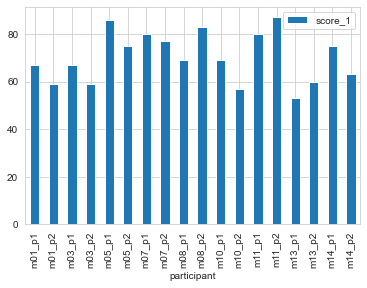

In [212]:
m_scores_1_bar = m_scores_1.plot.bar()

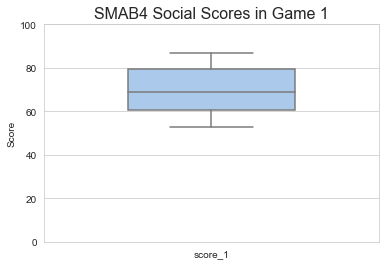

In [213]:
m_g1_scores_box = sns.boxplot( 
                 data=m_scores_1, 
                 width=0.5,
                 palette="pastel")
m_g1_scores_box.axes.set_title("SMAB4 Social Scores in Game 1",
                    fontsize=16)

plot_file_name="m_g1_score_box.jpg"
 
plt.ylim(0, 100)
m_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')


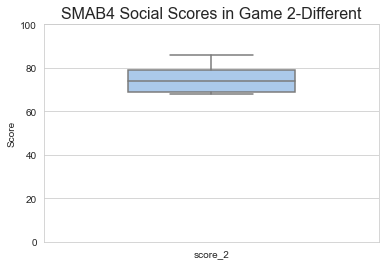

In [214]:
m_g2d_scores_box = sns.boxplot( 
                 data=m_scores_2_d, 
                 width=0.5,
                 palette="pastel")
m_g2d_scores_box.axes.set_title("SMAB4 Social Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="m_g2d_score_box.jpg"
 
plt.ylim(0, 100)
m_g2d_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g2d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

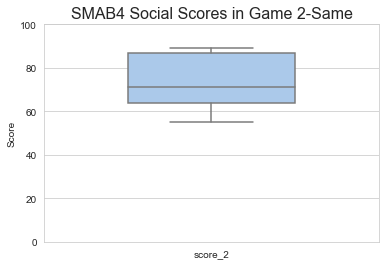

In [215]:
m_g2s_scores_box = sns.boxplot( 
                 data=m_scores_2_s, 
                 width=0.5,
                 palette="pastel")
m_g2s_scores_box.axes.set_title("SMAB4 Social Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="m_g2s_score_box.jpg"
 
plt.ylim(0, 100)
m_g2s_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_g2s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [216]:
m_scores_2s_mean = m_scores_2_s.mean()

In [217]:
m_scores_2s_std = m_scores_2_s.std()

In [218]:
m_scores_2d_mean = m_scores_2_d.mean()

In [219]:
m_scores_2d_std = m_scores_2_d.std()

In [220]:
m_scores_2s_mean, m_scores_2s_std

(score_2    73.785714
 dtype: float64,
 score_2    12.292453
 dtype: float64)

In [221]:
m_scores_2d_mean, m_scores_2d_std

(score_2    75.0
 dtype: float64,
 score_2    7.402702
 dtype: float64)

In [222]:
sp.stats.ttest_ind(m_scores_2_s, m_scores_2_d)

Ttest_indResult(statistic=array([-0.22316038]), pvalue=array([0.82592361]))

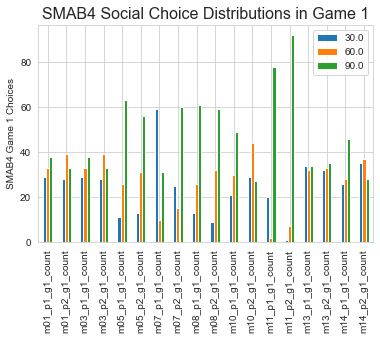

In [223]:
'''Here we place the counts of how many times each hole was chosen into dataframes for games 1 and 2. We also 
get statistics on this data and plot it.'''

# # Multi combined choices in G1

# In[ ]:


m_g1_counts = pd.DataFrame([m01_p1_g1_count, m01_p2_g1_count, m03_p1_g1_count, m03_p2_g1_count, m05_p1_g1_count, m05_p2_g1_count, m07_p1_g1_count, m07_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['m01_p1_g1_count', 'm01_p2_g1_count', 'm03_p1_g1_count', 'm03_p2_g1_count', 'm05_p1_g1_count', 'm05_p2_g1_count', 
                 'm07_p1_g1_count', 'm07_p2_g1_count', 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count']) 

# In[ ]:


m_g1_counts = m_g1_counts.fillna(0) 



# In[ ]:


m_g1_counts


# In[ ]:


m_g1_counts.sum(axis=1)


# In[ ]:

# save as jpeg


m_g1_counts_bar = m_g1_counts.plot.bar()

m_g1_counts_bar.axes.set(ylabel='SMAB4 Game 1 Choices')

m_g1_counts_bar.axes.set_title("SMAB4 Social Choice Distributions in Game 1",fontsize=16)

m_g1_counts_bar.figure.savefig("m1_g1_counts_bar.jpg",
                    format='jpeg')

In [224]:
m01_p1_g1_count

60.0    33
30.0    29
90.0    38
Name: probability, dtype: int64

In [225]:
m_g1_counts

,30.0,60.0,90.0
m01_p1_g1_count,29,33,38
m01_p2_g1_count,28,39,33
m03_p1_g1_count,29,33,38
m03_p2_g1_count,28,39,33
m05_p1_g1_count,11,26,63
m05_p2_g1_count,13,31,56
m07_p1_g1_count,59,10,31
m07_p2_g1_count,25,15,60
m08_p1_g1_count,13,26,61
m08_p2_g1_count,9,32,59


In [226]:
len(m_g1_counts)

18

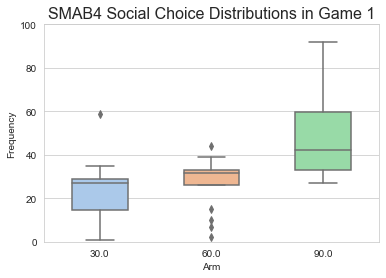

In [227]:
# In[ ]:


m_g1_counts_box = sns.boxplot( 
                 data = m_g1_counts, 
                 width=0.5,
                 palette="pastel")
m_g1_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="m_g1_counts_box.jpg"
 
plt.ylim(0, 100)
m_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [228]:
# In[ ]:


m_g1_low = np.mean(m_g1_counts.iloc[:,0])
m_g1_med = np.mean(m_g1_counts.iloc[:,1])
m_g1_high = np.mean(m_g1_counts.iloc[:,2])


# In[ ]:


m_g1_low


# In[ ]:


m_g1_med


# In[ ]:


m_g1_high


# In[ ]:


m_g1_low_std = np.std(m_g1_counts.iloc[:,0])
m_g1_med_std = np.std(m_g1_counts.iloc[:,1])
m_g1_high_std = np.std(m_g1_counts.iloc[:,2])


# In[ ]:


m_g1_low_std


# In[ ]:


m_g1_med_std


# In[ ]:


m_g1_high_std

17.808393776219372

In [229]:
# # Multi combined choices in G2


m_g2d_counts = pd.DataFrame([m01_p1_g2_count, m01_p2_g2_count, m03_p1_g2_count, m03_p2_g2_count, m05_p1_g2_count, m05_p2_g2_count],
                index = ['m01_p1_g2_count','m01_p2_g2_count','m03_p1_g2_count', 'm03_p2_g2_count','m05_p1_g2_count', 'm05_p2_g2_count'])



m_g2d_counts = m_g2d_counts.fillna(0) 


m_g2d_counts.sum(axis=1)

m01_p1_g2_count    100
m01_p2_g2_count    100
m03_p1_g2_count    100
m03_p2_g2_count    100
m05_p1_g2_count    100
m05_p2_g2_count    100
dtype: int64

In [230]:
# # Multi combined choices in G2


m_g2s_counts = pd.DataFrame([m06_p1_g2_count, m06_p2_g2_count, m07_p1_g2_count, m07_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['m06_p1_g2_count', 'm06_p2_g2_count', 'm07_p1_g2_count',
                 'm07_p2_g2_count','m08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])


m_g2s_counts = m_g2s_counts.fillna(0) 



m_g2s_counts.sum(axis=1)

m06_p1_g2_count    100.0
m06_p2_g2_count    100.0
m07_p1_g2_count    100.0
m07_p2_g2_count    100.0
m08_p1_g2_count    100.0
m08_p2_g2_count    100.0
m10_p1_g2_count    100.0
m10_p2_g2_count    100.0
m11_p1_g2_count    100.0
m11_p2_g2_count    100.0
m13_p1_g2_count    100.0
m13_p2_g2_count    100.0
m14_p1_g2_count    100.0
m14_p2_g2_count    100.0
dtype: float64

In [231]:
m_scores_1

,score_1
participant,
m01_p1,67
m01_p2,59
m03_p1,67
m03_p2,59
m05_p1,86
m05_p2,75
m07_p1,80
m07_p2,77
m08_p1,69


In [232]:
m_scores_mean_1 = np.mean(m_scores_1)
m_scores_std_1 = np.std(m_scores_1)

In [233]:
m_scores_mean_1

score_1    70.333333
dtype: float64

In [234]:
m_scores_std_1

score_1    10.219806
dtype: float64

In [235]:
m_g1_low, m_g1_med, m_g1_high

(24.555555555555557, 27.61111111111111, 47.833333333333336)

In [236]:
m_g1_low_std, m_g1_med_std, m_g1_high_std

(12.486535958660175, 11.338914747643223, 17.808393776219372)

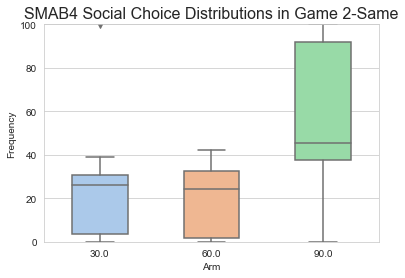

In [237]:
m_g2s_counts_box = sns.boxplot( 
                 data = m_g2s_counts, 
                 width=0.5,
                 palette="pastel")
m_g2s_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="m_g2s_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2s_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

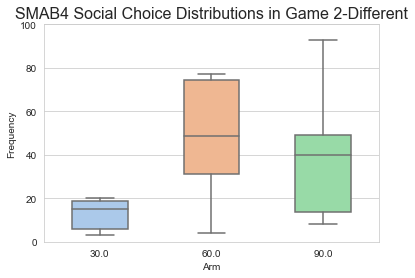

In [238]:
m_g2d_counts_box = sns.boxplot( 
                 data = m_g2d_counts, 
                 width=0.5,
                 palette="pastel")
m_g2d_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="m_g2d_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2d_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [239]:
# In[ ]:


m_g2s_low = np.mean(m_g2s_counts.iloc[:,0])
m_g2s_med = np.mean(m_g2s_counts.iloc[:,1])
m_g2s_high = np.mean(m_g2s_counts.iloc[:,2])

m_g2s_low_std = np.std(m_g2s_counts.iloc[:,0])
m_g2s_med_std = np.std(m_g2s_counts.iloc[:,1])
m_g2s_high_std = np.std(m_g2s_counts.iloc[:,2])



import researchpy as rp


# In[ ]:


m_90_1 = np.array(m_g1_counts.iloc[:,2])
m_90_2s = np.array(m_g2s_counts.iloc[:,2])
m_90_2d = np.array(m_g2s_counts.iloc[:,2])

m_60_1 = np.array(m_g1_counts.iloc[:,1])
m_60_2s = np.array(m_g2s_counts.iloc[:,1])
m_60_2d = np.array(m_g2d_counts.iloc[:,1])


m_30_1 = np.array(m_g1_counts.iloc[:,0])
m_30_2s = np.array(m_g2s_counts.iloc[:,0])
m_30_2d = np.array(m_g2d_counts.iloc[:,0])

# Reaction Time

In [240]:
'Here we get the reaction times'
time_m_1 = pd.DataFrame(columns = ['session','post win','post loss'])
time_m_2 = pd.DataFrame(columns = ['session','post win','post loss'])

time_m_1 = reaction_time(m05_p1_g1, time_m_1)
time_m_1 = reaction_time(m06_p1_g1, time_m_1)
time_m_1 = reaction_time(m08_p1_g1, time_m_1)
time_m_1 = reaction_time(m10_p1_g1, time_m_1)
time_m_1 = reaction_time(m11_p1_g1, time_m_1)
time_m_1 = reaction_time(m13_p1_g1, time_m_1)
time_m_1 = reaction_time(m14_p1_g1, time_m_1)
time_m_1 = reaction_time(m05_p2_g1, time_m_1)
time_m_1 = reaction_time(m06_p2_g1, time_m_1)
time_m_1 = reaction_time(m08_p2_g1, time_m_1)
time_m_1 = reaction_time(m10_p2_g1, time_m_1)
time_m_1 = reaction_time(m11_p2_g1, time_m_1)
time_m_1 = reaction_time(m13_p2_g1, time_m_1)
time_m_1 = reaction_time(m14_p2_g1, time_m_1)

time_m_2 = reaction_time(m05_p1_g2, time_m_2)
time_m_2 = reaction_time(m06_p1_g2, time_m_2)
time_m_2 = reaction_time(m08_p1_g2, time_m_2)
time_m_2 = reaction_time(m10_p1_g2, time_m_2)
time_m_2 = reaction_time(m11_p1_g2, time_m_2)
time_m_2 = reaction_time(m13_p1_g2, time_m_2)
time_m_2 = reaction_time(m14_p1_g2, time_m_2)
time_m_2 = reaction_time(m05_p2_g2, time_m_2)
time_m_2 = reaction_time(m06_p2_g2, time_m_2)
time_m_2 = reaction_time(m08_p2_g2, time_m_2)
time_m_2 = reaction_time(m10_p2_g2, time_m_2)
time_m_2 = reaction_time(m11_p2_g2, time_m_2)
time_m_2 = reaction_time(m13_p2_g2, time_m_2)
time_m_2 = reaction_time(m14_p2_g2, time_m_2)

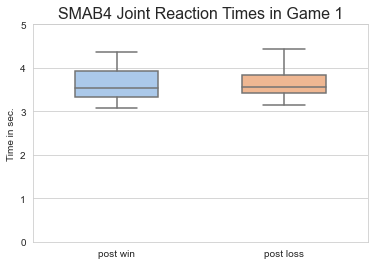

In [241]:
times_m_g1_box = sns.boxplot( 
                 data=time_m_1, 
                 width=0.5,
                 palette="pastel")
times_m_g1_box.axes.set_title("SMAB4 Joint Reaction Times in Game 1",
                    fontsize=16)

plot_file_name="times_m_g1_box.jpg"
 
plt.ylim(0, 5)
times_m_g1_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_m_g1_box.figure.savefig(plot_file_name,format='jpeg')

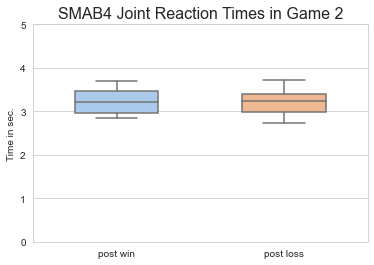

In [242]:
times_m_g2_box = sns.boxplot( 
                 data=time_m_2, 
                 width=0.5,
                 palette="pastel")
times_m_g2_box.axes.set_title("SMAB4 Joint Reaction Times in Game 2",
                    fontsize=16)

plot_file_name="times_m_g2_box.jpg"
 
plt.ylim(0, 5)
times_m_g2_box.axes.set(ylabel='Time in sec.')

# save as jpeg
times_m_g2_box.figure.savefig(plot_file_name,format='jpeg')

In [243]:
np.mean(time_m_1)

post win     3.626935
post loss    3.656920
dtype: float64

In [244]:
np.mean(time_m_2)

post win     3.426058
post loss    3.214477
dtype: float64

In [245]:
np.std(time_m_1)

post win     0.388043
post loss    0.357404
dtype: float64

In [246]:
np.std(time_m_2)

post win     0.823263
post loss    0.280154
dtype: float64

In [247]:
sp.stats.ttest_rel(time_m_1['post win'], time_m_1['post loss'])

Ttest_relResult(statistic=-0.7438584283556953, pvalue=0.4701941413958608)

In [248]:
sp.stats.ttest_rel(time_m_2['post win'], time_m_2['post loss'])

Ttest_relResult(statistic=0.9748098200412652, pvalue=0.3474456609541037)

In [249]:
sp.stats.ttest_rel(time_m_1['post win'], time_m_2['post win'])

Ttest_relResult(statistic=0.8653075259742253, pvalue=0.4025564225265744)

In [250]:
sp.stats.ttest_rel(time_m_1['post loss'], time_m_2['post loss'])

Ttest_relResult(statistic=5.168850202010096, pvalue=0.00018063098116127718)

# Test for differences between SMAB3 and SMAB4 in multi-player data

In [251]:
#simple t-test for score 
sp.stats.ttest_ind(m_scores_1, j_scores_1)

Ttest_indResult(statistic=array([1.06469837]), pvalue=array([0.29410178]))

In [252]:
#combine control_score_2 and control_score_1
#social_scores = social_scores_1.merge(social_scores_2,right_index=True,left_index=True)


#convert from wide-format to long-format
#social_scores = pd.melt(social_scores,ignore_index=False)

# Testing for differences b/w SMAB3 and 4

In [253]:
#combine m_counts and j_counts
soc_g1_counts_unmelt = m_g1_counts.append(j_g1_counts)

In [254]:
#combine m_counts and j_counts
soc_g2_s_counts_unmelt = m_g2s_counts.append(j_g2_s_counts)

soc_g2_d_counts_unmelt = m_g2d_counts.append(j_g2_d_counts)

In [255]:
confed_g2_d_counts_unmelt = c_g2_d_counts.append(s_g2_d_counts)

confed_g2_s_counts_unmelt = c_g2_s_counts.append(s_g2_s_counts)

In [256]:
soc_g2_s_scores_unmelt = m_scores_2_s.append(j_scores_2_s)

soc_g2_d_scores_unmelt = m_scores_2_d.append(j_scores_2_d)

In [257]:
confed_g2_s_scores_unmelt = c_scores_2_s.append(s_scores_2_s)

confed_g2_d_scores_unmelt = c_scores_2_d.append(s_scores_2_d)

In [258]:
soc_g1_counts_unmelt

,30.0,60.0,90.0
m01_p1_g1_count,29.0,33.0,38.0
m01_p2_g1_count,28.0,39.0,33.0
m03_p1_g1_count,29.0,33.0,38.0
m03_p2_g1_count,28.0,39.0,33.0
m05_p1_g1_count,11.0,26.0,63.0
m05_p2_g1_count,13.0,31.0,56.0
m07_p1_g1_count,59.0,10.0,31.0
m07_p2_g1_count,25.0,15.0,60.0
m08_p1_g1_count,13.0,26.0,61.0
m08_p2_g1_count,9.0,32.0,59.0


In [259]:
'''The next few cells are done in order to be able to run ANOVA.'''
soc_g1_counts = soc_g1_counts_unmelt.melt(ignore_index=False)

In [260]:
soc_g1_counts

,variable,value
m01_p1_g1_count,30.0,29.0
m01_p2_g1_count,30.0,28.0
m03_p1_g1_count,30.0,29.0
m03_p2_g1_count,30.0,28.0
m05_p1_g1_count,30.0,11.0
...,...,...
j08_p2_g1_count,90.0,37.0
j10_p1_g1_count,90.0,48.0
j10_p2_g1_count,90.0,59.0
j11_p1_g1_count,90.0,60.0


In [261]:
confed_g1_counts_unmelt = c_g1_counts.append(s_g1_counts)
confed_g1_counts = confed_g1_counts_unmelt.melt(ignore_index=False)

In [262]:
confed_g1_counts_unmelt

,30.0,60.0,90.0
c01_p1_g1_count,23,34,43
c02_p1_g1_count,13,44,43
c03_p1_g1_count,12,4,84
c04_p1_g1_count,8,22,48
c05_p1_g1_count,34,31,35
c06_p1_g1_count,29,29,42
c07_p1_g1_count,12,16,70
c09_p1_g1_count,28,47,25
c10_p1_g1_count,9,13,78
c11_p1_g1_count,19,38,43


In [263]:
np.mean(confed_g1_counts_unmelt)

30.0    18.37500
60.0    27.21875
90.0    53.68750
dtype: float64

In [264]:
np.mean(soc_g1_counts_unmelt)

30.0    24.052632
60.0    28.052632
90.0    47.894737
dtype: float64

In [265]:
np.std(confed_g1_counts_unmelt)

30.0    10.151201
60.0    13.651315
90.0    21.905247
dtype: float64

In [266]:
np.std(confed_g1_counts_unmelt)

30.0    10.151201
60.0    13.651315
90.0    21.905247
dtype: float64

In [267]:
sp.stats.ttest_ind(confed_g1_counts_unmelt,soc_g1_counts_unmelt)

Ttest_indResult(statistic=array([-1.98815277, -0.28532822,  1.20359528]), pvalue=array([0.05082228, 0.77625999, 0.23291939]))

In [268]:
g1_counts = confed_g1_counts.append(soc_g1_counts)

In [269]:
g1_counts

,variable,value
c01_p1_g1_count,30.0,23.0
c02_p1_g1_count,30.0,13.0
c03_p1_g1_count,30.0,12.0
c04_p1_g1_count,30.0,8.0
c05_p1_g1_count,30.0,34.0
...,...,...
j08_p2_g1_count,90.0,37.0
j10_p1_g1_count,90.0,48.0
j10_p2_g1_count,90.0,59.0
j11_p1_g1_count,90.0,60.0


In [270]:
#add another column to scores indicating whether it's the single or multiplayer

subjects = g1_counts.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

g1_counts['condition'] = condition

In [271]:
#add column to joint_counts indicating whether it's SMAB3 or 4
subjects = g1_counts.index.to_numpy()

experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j' or [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm' or [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
g1_counts['experiment'] = experiment

In [272]:
g1_counts

,variable,value,condition,experiment
c01_p1_g1_count,30.0,23.0,control,4.0
c02_p1_g1_count,30.0,13.0,control,4.0
c03_p1_g1_count,30.0,12.0,control,4.0
c04_p1_g1_count,30.0,8.0,control,4.0
c05_p1_g1_count,30.0,34.0,control,4.0
...,...,...,...,...
j08_p2_g1_count,90.0,37.0,social,3.0
j10_p1_g1_count,90.0,48.0,social,3.0
j10_p2_g1_count,90.0,59.0,social,3.0
j11_p1_g1_count,90.0,60.0,social,3.0


In [273]:
#break up counts dataframe into 30,60,90
grouped = g1_counts.groupby(g1_counts.variable)
g1_counts_30 = grouped.get_group(30.0)
g1_counts_60 = grouped.get_group(60.0)
g1_counts_90 = grouped.get_group(90.0)

In [274]:
g1_counts_30

,variable,value,condition,experiment
c01_p1_g1_count,30.0,23.0,control,4.0
c02_p1_g1_count,30.0,13.0,control,4.0
c03_p1_g1_count,30.0,12.0,control,4.0
c04_p1_g1_count,30.0,8.0,control,4.0
c05_p1_g1_count,30.0,34.0,control,4.0
...,...,...,...,...
j08_p2_g1_count,30.0,40.0,social,3.0
j10_p1_g1_count,30.0,24.0,social,3.0
j10_p2_g1_count,30.0,14.0,social,3.0
j11_p1_g1_count,30.0,0.0,social,3.0


In [275]:
#combine c_score and s_score
confed_g1_score = c_scores_1.append(s_scores_1)
confed_g1_score = confed_g1_score.melt(ignore_index=False)

In [276]:
confed_g1_score

,variable,value
participant,,
c01,score,66.0
c02,score,74.0
c03,score,79.0
c04,score,56.0
c05,score,61.0
c06,score,59.0
c07,score,78.0
c09,score,61.0
c10,score,81.0


In [277]:
confed_g1_score

,variable,value
participant,,
c01,score,66.0
c02,score,74.0
c03,score,79.0
c04,score,56.0
c05,score,61.0
c06,score,59.0
c07,score,78.0
c09,score,61.0
c10,score,81.0


In [278]:
#combine m_score and j_score
soc_g1_score = m_scores_1.append(j_scores_1)
soc_g1_score = soc_g1_score.melt(ignore_index=False)

In [279]:
soc_g1_score

,variable,value
participant,,
m01_p1,score_1,67
m01_p2,score_1,59
m03_p1,score_1,67
m03_p2,score_1,59
m05_p1,score_1,86
m05_p2,score_1,75
m07_p1,score_1,80
m07_p2,score_1,77
m08_p1,score_1,69


# Plotting Combined Data

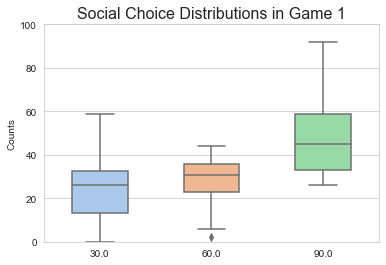

In [280]:
soc_g1_counts_box = sns.boxplot( 
                 data=soc_g1_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g1_counts_box.axes.set_title("Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="soc_counts1_box.jpg"
 
plt.ylim(0, 100)
soc_g1_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

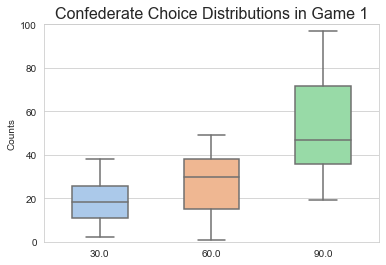

In [281]:
confed_g1_counts_box = sns.boxplot( 
                 data=confed_g1_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g1_counts_box.axes.set_title("Confederate Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="confed_counts1_box.jpg"
 
plt.ylim(0, 100)
confed_g1_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

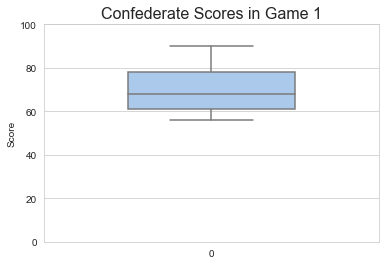

In [282]:
confed_g1_scores_box = sns.boxplot( 
                 data=confed_g1_score['value'],
                 width=0.5,
                 palette="pastel")
confed_g1_scores_box.axes.set_title("Confederate Scores in Game 1",
                    fontsize=16)

plot_file_name="confed_score1_box.jpg"
 
plt.ylim(0, 100)
confed_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

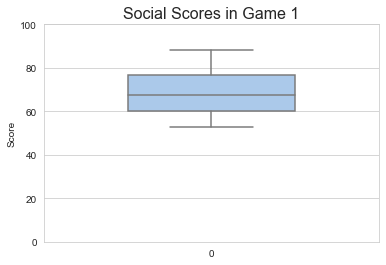

In [283]:
soc_g1_scores_box = sns.boxplot( 
                 data=soc_g1_score['value'],
                 width=0.5,
                 palette="pastel")
soc_g1_scores_box.axes.set_title("Social Scores in Game 1",
                    fontsize=16)

plot_file_name="soc_score1_box.jpg"
 
plt.ylim(0, 100)
soc_g1_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g1_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

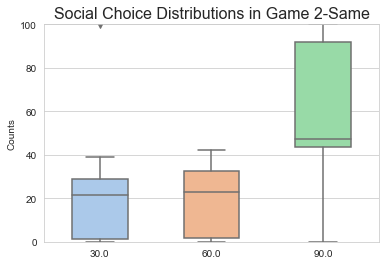

In [284]:
soc_g2s_counts_box = sns.boxplot( 
                 data=soc_g2_s_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2s_counts_box.axes.set_title("Social Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="soc_counts2s_box.jpg"
 
plt.ylim(0, 100)
soc_g2s_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g2s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

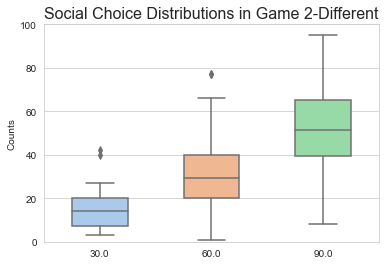

In [285]:
soc_g2d_counts_box = sns.boxplot( 
                 data=soc_g2_d_counts_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2d_counts_box.axes.set_title("Social Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="soc_counts2d_box.jpg"
 
plt.ylim(0, 100)
soc_g2d_counts_box.axes.set(ylabel='Counts')

# save as jpeg
soc_g2d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

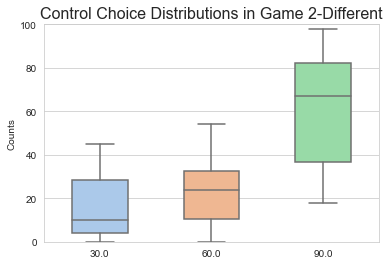

In [286]:
confed_g2d_counts_box = sns.boxplot( 
                 data=confed_g2_d_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2d_counts_box.axes.set_title("Control Choice Distributions in Game 2-Different",
                    fontsize=16)

plot_file_name="confed_counts2d_box.jpg"
 
plt.ylim(0, 100)
confed_g2d_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g2d_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

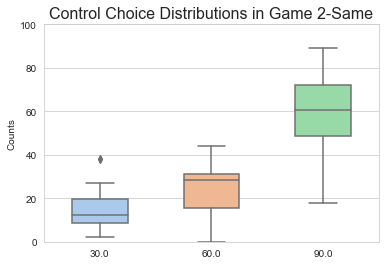

In [287]:
confed_g2s_counts_box = sns.boxplot( 
                 data=confed_g2_s_counts_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2s_counts_box.axes.set_title("Control Choice Distributions in Game 2-Same",
                    fontsize=16)

plot_file_name="confed_counts2s_box.jpg"
 
plt.ylim(0, 100)
confed_g2s_counts_box.axes.set(ylabel='Counts')

# save as jpeg
confed_g2s_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

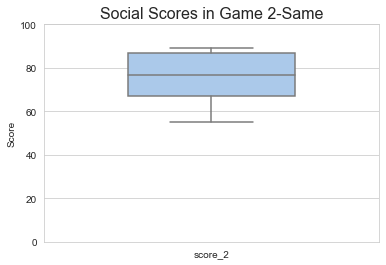

In [288]:
soc_g2_s_scores_box = sns.boxplot( 
                 data=soc_g2_s_scores_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2_s_scores_box.axes.set_title("Social Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="soc_g2_s_scores_box.jpg"
 
plt.ylim(0, 100)
soc_g2_s_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g2_s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

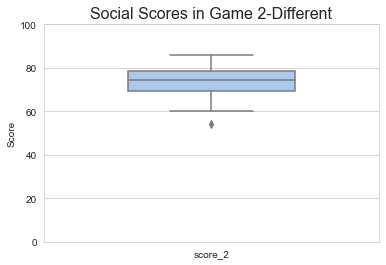

In [289]:
soc_g2_d_scores_box = sns.boxplot( 
                 data=soc_g2_d_scores_unmelt,
                 width=0.5,
                 palette="pastel")
soc_g2_d_scores_box.axes.set_title("Social Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="soc_g2_d_scores_box.jpg"
 
plt.ylim(0, 100)
soc_g2_d_scores_box.axes.set(ylabel='Score')

# save as jpeg
soc_g2_d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

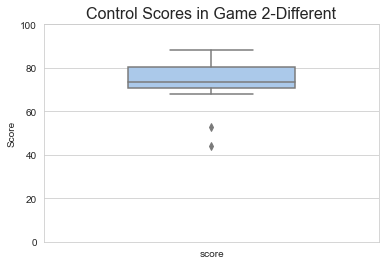

In [290]:
#NEED TO FIX
confed_g2_d_scores_box = sns.boxplot( 
                 data=confed_g2_d_scores_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2_d_scores_box.axes.set_title("Control Scores in Game 2-Different",
                    fontsize=16)

plot_file_name="confed_g2_d_scores_box.jpg"
 
plt.ylim(0, 100)
confed_g2_d_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g2_d_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

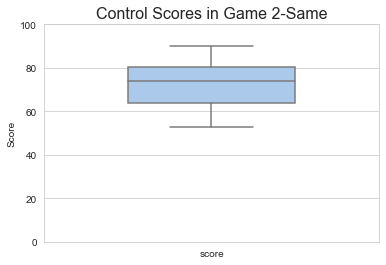

In [291]:
confed_g2_s_scores_box = sns.boxplot( 
                 data=confed_g2_s_scores_unmelt,
                 width=0.5,
                 palette="pastel")
confed_g2_s_scores_box.axes.set_title("Control Scores in Game 2-Same",
                    fontsize=16)

plot_file_name="confed_g2_s_scores_box.jpg"
 
plt.ylim(0, 100)
confed_g2_s_scores_box.axes.set(ylabel='Score')

# save as jpeg
confed_g2_s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

# Maximizing vs Matching Social Condition

In [292]:
# # Maximizing/Matching SOCIAL

# In[ ]:


from scipy import stats


# In[ ]:


#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate)

#social_max = [0, 0, 100]
#social_match = [30/180 * 100,60/180 * 100, 90/180 * 100]


# In[ ]:


#Calls jsd with the social distributions.
#def call_jsd_social(counts):
   # maxi = jsd(counts,social_max)
   # matchi = jsd(counts,social_match)
    #return maxi,matchi


# In[ ]:


j01_p1_g1_max,j01_p1_g1_match,j01_p1_g1_rand,j01_p1_g1_soc = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match,j01_p1_g2_rand,j01_p1_g2_soc = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match,j01_p2_g1_rand,j01_p2_g1_soc = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match,j01_p2_g2_rand,j01_p2_g2_soc = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match,j02_p1_g1_rand,j02_p1_g1_soc = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match,j02_p1_g2_rand,j02_p1_g2_soc = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match,j02_p2_g1_rand,j02_p2_g1_soc = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match,j02_p2_g2_rand,j02_p2_g2_soc = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match,j03_p1_g1_rand,j03_p1_g1_soc = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match,j03_p1_g2_rand,j03_p1_g2_soc = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match,j03_p2_g1_rand,j03_p2_g1_soc  = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match,j03_p2_g2_rand,j03_p2_g2_soc = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match,j04_p1_g1_rand,j04_p1_g1_soc = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match,j04_p1_g2_rand,j04_p1_g2_soc = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match,j04_p2_g1_rand,j04_p2_g1_soc  = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match,j04_p2_g2_rand,j04_p2_g2_soc = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match,j05_p1_g1_rand,j05_p1_g1_soc = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match,j05_p1_g2_rand,j05_p1_g2_soc = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match,j05_p2_g1_rand,j05_p2_g1_soc = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match,j05_p2_g2_rand,j05_p2_g2_soc = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match,j06_p1_g1_rand,j06_p1_g1_soc = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match,j06_p1_g2_rand,j06_p1_g2_soc = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match,j06_p2_g1_rand,j06_p2_g1_soc = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match,j06_p2_g2_rand,j06_p2_g2_soc = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match,j07_p1_g1_rand,j07_p1_g1_soc = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match,j07_p1_g2_rand,j07_p1_g2_soc = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match,j07_p2_g1_rand,j07_p2_g1_soc = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match,j07_p2_g2_rand,j07_p2_g2_soc = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match,j08_p1_g1_rand,j08_p1_g1_soc = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match,j08_p1_g2_rand,j08_p1_g2_soc = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match,j08_p2_g1_rand,j08_p2_g1_soc = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match,j08_p2_g2_rand,j08_p2_g2_soc = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match,j10_p1_g1_rand,j10_p1_g1_soc = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match,j10_p1_g2_rand,j10_p1_g2_soc = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match,j10_p2_g1_rand,j10_p2_g1_soc = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match,j10_p2_g2_rand,j10_p2_g2_soc = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match,j11_p1_g1_rand,j11_p1_g1_soc = call_jsd([0,40,60])
j11_p1_g2_max,j11_p1_g2_match,j11_p1_g2_rand,j11_p1_g2_soc = call_jsd([0,22,78])
j11_p2_g1_max,j11_p2_g1_match,j11_p2_g1_rand,j11_p2_g1_soc = call_jsd(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match,j11_p2_g2_rand,j11_p2_g2_soc = call_jsd([0,1,99])
m05_p1_g1_max,m05_p1_g1_match,m05_p1_g1_rand,m05_p1_g1_soc = call_jsd(m05_p1_g1_count)
m05_p1_g2_max,m05_p1_g2_match,m05_p1_g2_rand,m05_p1_g2_soc = call_jsd(m05_p1_g2_count)
m05_p2_g1_max,m05_p2_g1_match,m05_p2_g1_rand,m05_p2_g1_soc = call_jsd(m05_p2_g1_count)
m05_p2_g2_max,m05_p2_g2_match,m05_p2_g2_rand,m05_p2_g2_soc = call_jsd(m05_p2_g2_count)
m06_p1_g1_max,m06_p1_g1_match,m06_p1_g1_rand,m06_p1_g1_soc = call_jsd(m06_p1_g1_count)
m06_p1_g2_max,m06_p1_g2_match,m06_p1_g2_rand,m06_p1_g2_soc = call_jsd(m06_p1_g2_count)
m06_p2_g1_max,m06_p2_g1_match,m06_p2_g1_rand,m06_p2_g1_soc = call_jsd(m06_p2_g1_count)
m06_p2_g2_max,m06_p2_g2_match,m06_p2_g2_rand,m06_p2_g2_soc = call_jsd(m06_p2_g2_count)
m08_p1_g1_max,m08_p1_g1_match,m08_p1_g1_rand,m08_p1_g1_soc = call_jsd(m08_p1_g1_count)
m08_p1_g2_max,m08_p1_g2_match,m08_p1_g2_rand,m08_p1_g2_soc = call_jsd(m08_p1_g2_count)
m08_p2_g1_max,m08_p2_g1_match,m08_p2_g1_rand,m08_p2_g1_soc = call_jsd(m08_p2_g1_count)
m08_p2_g2_max,m08_p2_g2_match,m08_p2_g2_rand,m08_p2_g2_soc = call_jsd(m08_p2_g2_count)
m10_p1_g1_max,m10_p1_g1_match,m10_p1_g1_rand,m10_p1_g1_soc = call_jsd(m10_p1_g1_count)
m10_p1_g2_max,m10_p1_g2_match,m10_p1_g2_rand,m10_p1_g2_soc = call_jsd(m10_p1_g2_count)
m10_p2_g1_max,m10_p2_g1_match,m10_p2_g1_rand,m10_p2_g1_soc = call_jsd(m10_p2_g1_count)
m10_p2_g2_max,m10_p2_g2_match,m10_p2_g2_rand,m10_p2_g2_soc = call_jsd(m10_p2_g2_count)
m11_p1_g1_max,m11_p1_g1_match,m11_p1_g1_rand,m11_p1_g1_soc = call_jsd(m11_p1_g1_count)
m11_p1_g2_max,m11_p1_g2_match,m11_p1_g2_rand,m11_p1_g2_soc = call_jsd([0,1,99])
m11_p2_g1_max,m11_p2_g1_match,m11_p2_g1_rand,m11_p2_g1_soc = call_jsd(m11_p2_g1_count)
m11_p2_g2_max,m11_p2_g2_match,m11_p2_g2_rand,m11_p2_g2_soc = call_jsd([0,0,100])
m13_p1_g1_max,m13_p1_g1_match,m13_p1_g1_rand,m13_p1_g1_soc = call_jsd(m13_p1_g1_count)
m13_p1_g2_max,m13_p1_g2_match,m13_p1_g2_rand,m13_p1_g2_soc = call_jsd(m13_p1_g2_count)
m13_p2_g1_max,m13_p2_g1_match,m13_p2_g1_rand,m13_p2_g1_soc = call_jsd(m13_p2_g1_count)
m13_p2_g2_max,m13_p2_g2_match,m13_p2_g2_rand,m13_p2_g2_soc = call_jsd(m13_p2_g2_count)
m14_p1_g1_max,m14_p1_g1_match,m14_p1_g1_rand,m14_p1_g1_soc = call_jsd(m14_p1_g1_count)
m14_p1_g2_max,m14_p1_g2_match,m14_p1_g2_rand,m14_p1_g2_soc = call_jsd(m14_p1_g2_count)
m14_p2_g1_max,m14_p2_g1_match,m14_p2_g1_rand,m14_p2_g1_soc = call_jsd(m14_p2_g1_count)
m14_p2_g2_max,m14_p2_g2_match,m14_p2_g2_rand,m14_p2_g2_soc = call_jsd(m14_p2_g2_count)

In [293]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max, m05_p1_g1_max, m05_p2_g1_max, m06_p1_g1_max, m06_p2_g1_max,
                                   m08_p1_g1_max, m08_p2_g1_max, m10_p1_g1_max, m10_p2_g1_max, m11_p1_g1_max, m11_p2_g1_max,
                                    m13_p1_g1_max, m13_p2_g1_max, m14_p1_g1_max, m14_p2_g1_max],
                    'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match, j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                               j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match, m05_p1_g1_match, m05_p2_g1_match,
                               m06_p1_g1_match, m06_p2_g1_match, m08_p1_g1_match, m08_p2_g1_match, m10_p1_g1_match,
                               m10_p2_g1_match, m11_p1_g1_match, m11_p2_g1_match, m13_p1_g1_match, m13_p2_g1_match,
                               m14_p1_g1_match, m14_p2_g1_match],
                    'rand':[j01_p1_g1_rand,j01_p2_g1_rand,j02_p1_g1_rand,j02_p2_g1_rand,j03_p1_g1_rand,j03_p2_g1_rand,
                             j04_p1_g1_rand,j04_p2_g1_rand,j05_p1_g1_rand,j05_p2_g1_rand,j06_p1_g1_rand,j06_p2_g1_rand,
                             j07_p1_g1_rand,j07_p2_g1_rand,j08_p1_g1_rand,j08_p2_g1_rand, j10_p1_g1_rand, j10_p2_g1_rand,
                               j11_p1_g1_rand, j11_p2_g1_rand, m05_p1_g1_rand, m05_p2_g1_rand, m06_p1_g1_rand, m06_p2_g1_rand,
                                   m08_p1_g1_rand, m08_p2_g1_rand, m10_p1_g1_rand, m10_p2_g1_rand, m11_p1_g1_rand, m11_p2_g1_rand,
                                    m13_p1_g1_rand, m13_p2_g1_rand, m14_p1_g1_rand, m14_p2_g1_rand],
                    'soc':[j01_p1_g1_soc,j01_p2_g1_soc,j02_p1_g1_soc, j02_p2_g1_soc,j03_p1_g1_soc,j03_p2_g1_soc,
                               j04_p1_g1_soc,j04_p2_g1_soc,j05_p1_g1_soc,
                               j05_p2_g1_soc,j06_p1_g1_soc,j06_p2_g1_soc,
                               j07_p1_g1_soc,j07_p2_g1_soc,j08_p1_g1_soc,j08_p2_g1_soc, j10_p1_g1_soc,
                               j10_p2_g1_soc, j11_p1_g1_soc, j11_p2_g1_soc, m05_p1_g1_soc, m05_p2_g1_soc,
                               m06_p1_g1_soc, m06_p2_g1_soc, m08_p1_g1_soc, m08_p2_g1_soc, m10_p1_g1_soc,
                               m10_p2_g1_soc, m11_p1_g1_soc, m11_p2_g1_soc, m13_p1_g1_soc, m13_p2_g1_soc,
                               m14_p1_g1_soc, m14_p2_g1_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])


# In[ ]:


#to print wothout truncation
pd.set_option('display.max_rows', None)


# In[ ]:


social_jsd_g1


# In[ ]:


#export to excel
social_jsd_g1.to_excel("output1.xlsx")  


# In[ ]:


# get the column name of min values in every row
strategy_social_jsd_g1 = social_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g1)


# In[ ]:


strategy_social_jsd_g1.value_counts()


# In[ ]:


#social_types_g1 = check_type(social_jsd_g1)


# In[ ]:


#social_types_g1.drop([0])


# In[ ]:


#(social_types_g1 == 'maxi').sum()

min values of row are at following columns :
j01     rand
j01     rand
j02     rand
j02     rand
j03    match
j03     rand
j04     rand
j04     rand
j05    match
j05    match
j06     rand
j06     rand
j07    match
j07    match
j08     rand
j08     rand
j10    match
j10    match
j11    match
j11      max
m05    match
m05    match
m06     rand
m06     rand
m08    match
m08    match
m10    match
m10     rand
m11      max
m11      max
m13     rand
m13     rand
m14    match
m14     rand
dtype: object


rand     17
match    14
max       3
dtype: int64

In [294]:

#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max, j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m05_p1_g2_max, m05_p2_g2_max, m06_p1_g2_max, m06_p2_g2_max,
                                   m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, j10_p1_g2_match,
                               j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match,
                               m06_p1_g2_match, m06_p2_g2_match, m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand, m05_p1_g2_rand, m05_p2_g2_rand, m06_p1_g2_rand, m06_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc, j10_p1_g2_soc,
                               j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc, m05_p1_g2_soc, m05_p2_g2_soc,
                               m06_p1_g2_soc, m06_p2_g2_soc, m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])


# In[ ]:


social_jsd_g2


# In[ ]:


#export to excel
social_jsd_g2.to_excel("output2.xlsx")


# In[ ]:


# get the column name of min values in every row
strategy_social_jsd_g2 = social_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g2)


# In[ ]:


strategy_social_jsd_g2.value_counts()


# In[ ]:


social_jsd_g1.mean()


# In[ ]:


social_jsd_g2.mean()


# # Social strategy stats 

# # Max strategy

# In[ ]:


social_max_g1 = social_jsd_g1.loc[ : , 'max' ]


# In[ ]:


social_max_g1


# In[ ]:


social_max_g2 = social_jsd_g2.loc[ : , 'max' ]


# In[ ]:


social_max_g2


# In[ ]:


social_max_g1_mean = social_max_g1.mean()


# In[ ]:


social_max_g1_mean


# In[ ]:


social_max_g1_std = social_max_g1.std()


# In[ ]:


social_max_g1_std


# In[ ]:


social_max_g2_mean = social_max_g2.mean()


# In[ ]:


social_max_g2_mean


# In[ ]:


social_max_g2_std = social_max_g2.std()
social_max_g2_std


# In[ ]:


social_max_p = sp.stats.ttest_rel(social_max_g1,social_max_g2)


# In[ ]:


social_max_p


# # Match strategy

# In[ ]:


social_match_g1 = social_jsd_g1.loc[ : , 'match' ]


# In[ ]:


social_match_g1


# In[ ]:


social_match_g2 = social_jsd_g2.loc[ : , 'match' ]


# In[ ]:


social_match_g2


# In[ ]:


social_match_g1_mean = social_match_g1.mean()


# In[ ]:


social_match_g1_mean


# In[ ]:


social_match_g1_std = social_match_g1.std()


# In[ ]:


social_match_g1_std


# In[ ]:


social_match_g2_mean = social_match_g2.mean()


# In[ ]:


social_match_g2_mean


# In[ ]:


social_match_g2_std = social_match_g2.std()


# In[ ]:


social_match_g2_std


# In[ ]:


social_match_p = sp.stats.ttest_rel(social_match_g1,social_match_g2)


# In[ ]:


social_match_p


# # Random strategy

# In[ ]:


social_rand_g1 = social_jsd_g1.loc[ : , 'rand' ]


# In[ ]:


social_rand_g1


# In[ ]:


social_rand_g2 = social_jsd_g2.loc[ : , 'rand' ]


# In[ ]:


social_rand_g2


# In[ ]:


social_rand_g1_mean = social_rand_g1.mean()


# In[ ]:


social_rand_g1_mean


# In[ ]:


social_rand_g1_std = social_rand_g1.std()


# In[ ]:


social_rand_g1_std


# In[ ]:


social_rand_g2_mean = social_rand_g2.mean()


# In[ ]:


social_rand_g2_mean


# In[ ]:


social_rand_g2_std = social_rand_g2.std()


# In[ ]:


social_rand_g2_std


# In[ ]:


social_rand_p = sp.stats.ttest_rel(social_rand_g1,social_rand_g2)


# In[ ]:


social_rand_p


# # Social strategy

# In[ ]:


social_soc_g1 = social_jsd_g1.loc[ : , 'soc' ]


# In[ ]:


social_soc_g1


# In[ ]:


social_soc_g2 = social_jsd_g2.loc[ : , 'soc' ]


# In[ ]:


social_soc_g2


# In[ ]:


social_soc_g1_mean = social_soc_g1.mean()


# In[ ]:


social_soc_g1_mean


# In[ ]:


social_soc_g1_std = social_soc_g1.std()


# In[ ]:


social_soc_g1_std


# In[ ]:


social_soc_g2_mean = social_soc_g2.mean()


# In[ ]:


social_soc_g2_mean


# In[ ]:


social_soc_g2_std = social_soc_g2.std()


# In[ ]:


social_soc_g2_std


# In[ ]:


social_soc_p = sp.stats.ttest_rel(social_soc_g1,social_soc_g2)


# In[ ]:


social_soc_p


# In[ ]:


#social_types_g2 = check_type(social_jsd_g2)


# In[ ]:


#social_types_g2.drop([0])


# In[ ]:


#(social_types_g2 == 'maxi').sum()


# In[ ]:


import matplotlib.lines as mlines


# In[ ]:


#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              

min values of row are at following columns :
j01    match
j01     rand
j02    match
j02    match
j03    match
j03      max
j04     rand
j04     rand
j05    match
j05    match
j06    match
j06    match
j07      max
j07    match
j08      max
j08    match
j10    match
j10    match
j11    match
j11      max
m05    match
m05      max
m06     rand
m06     rand
m08    match
m08      max
m10     rand
m10    match
m11      max
m11      max
m13    match
m13    match
m14     rand
m14     rand
dtype: object


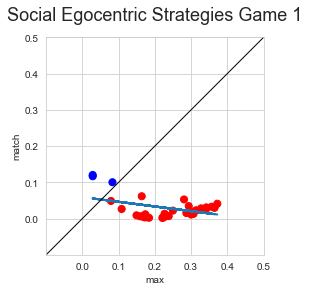

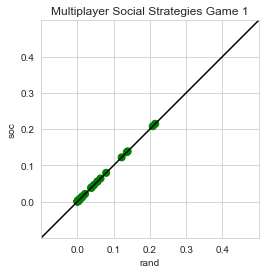

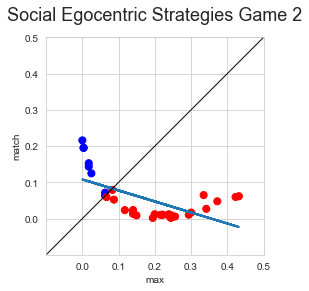

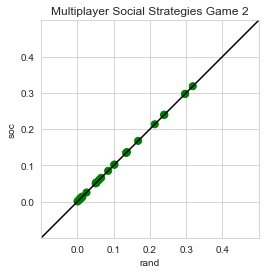

Ttest_relResult(statistic=-1.146788990825688, pvalue=0.262326441367707)

In [295]:
# In[ ]:


import itertools


# In[ ]:


#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
#colors_jsd_j = ['red','lightcoral','red','darkred','green','red',
             # 'blue','darkblue','hotblue','blue','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_social_g1_egocentric = ['red','red','red','red','red','red','red',
                        'red','red','red', 'red','red','red','red',
              'red', 'red','red', 'red','red', 'blue','red','red',
                        'red','red','red','red', 'red', 'red','blue', 
                        'blue','red','red','red','red']


colors_jsd_social_g2_egocentric = ['red','red','red','red','red','blue','red',
                        'red','red','red', 'red','red','blue','red',
             'blue', 'red','red', 'red','red', 'blue','red','blue',
                        'red','red','red','blue', 'red', 'red','blue', 
                        'blue','red','red','red','red']


colors_jsd_social_g1_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green','green', 'green','green', 
                        'green','green','green','green','green']




colors_jsd_social_g2_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green','green', 'green','green', 
                        'green','green','green','green','green']



#markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
         # 'o','v','o','v','o','v','o','v']


# In[ ]:


#Here I print the means of the JSD values in each condition, just to see what they are.'''


# In[ ]:


#run t test to see sig between max and match per game
#put in box plot
social_jsd_g1.mean()


# In[ ]:


social_jsd_g2.mean()


# In[ ]:


import matplotlib.patches as mpatches


# # Graphs

# In[ ]:


#Here I try to plot the JSD Values. Continued below under 'JSD with gender.


# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(social_jsd_g1['max'], social_jsd_g1['match'], 1)

social_ego_jsd_g1_plot = social_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_social_g1_egocentric)
plt.title('Social Egocentric Strategies Game 1', fontsize=18, y=1.05)
social_ego_jsd_g1_plot.plot(social_jsd_g1['max'], m*social_jsd_g1['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
social_ego_jsd_g1_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_1.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()



# In[ ]:


#under line = matching (closer to 0)
#plots of atual jsd values
social_joint_jsd_g1_plot = social_jsd_g1.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_social_g1_joint,title='Multiplayer Social Strategies Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
social_joint_jsd_g1_plot.add_line(line1)



plt.savefig('social_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
social_joint_jsd_g1_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(social_jsd_g2['max'], social_jsd_g2['match'], 1)

social_ego_jsd_g2_plot = social_jsd_g2.plot.scatter(x='max',y='match',s=50,color=colors_jsd_social_g2_egocentric)
plt.title('Social Egocentric Strategies Game 2', fontsize=18, y=1.05)
social_ego_jsd_g2_plot.plot(social_jsd_g2['max'], m*social_jsd_g2['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
social_ego_jsd_g2_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()


# In[ ]:


#under line = matching (closer to 0)
#plots of atual jsd values
social_joint_jsd_g2_plot = social_jsd_g2.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_social_g2_joint,title='Multiplayer Social Strategies Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
social_joint_jsd_g2_plot.add_line(line1)



plt.savefig('social_joint_jsd_2.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
social_joint_jsd_g2_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# # CONTROL (total) scores in G1 and G2

# In[ ]:


#list out all the scores in game 1 by participant
control_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
control_scores_1.set_index('participant', inplace=True, drop=True)

#print
control_scores_1


# In[ ]:


#list out all the scores in game 2 by participant
control_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_2':
        [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score, 
         c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
control_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
control_scores_2


# In[ ]:


#merge both games by participant:
control_scores = pd.merge(control_scores_1, control_scores_2, on = 'participant')


# In[ ]:


#label columns
control_scores.columns=['Game 1','Game 2']


# In[ ]:


control_scores


# In[ ]:


control_scores_1_mean = control_scores_1.mean()


# In[ ]:


control_scores_1_mean


# In[ ]:


control_scores_1_std = control_scores_1.std()


# In[ ]:


control_scores_1_std


# In[ ]:


control_scores_2_mean = control_scores_2.mean()


# In[ ]:


control_scores_2_mean


# In[ ]:


control_scores_2_std = control_scores_2.std()


# In[ ]:


control_scores_2_std


# In[ ]:


control_scores_med = control_scores.median()
control_scores_med


# In[ ]:


control_scores_p = sp.stats.ttest_rel(control_scores['Game 1'],control_scores['Game 2'])


# In[ ]:


control_scores_p


# In[ ]:





# # End of SMAB3 analysis

In [296]:
# In[ ]:


#hypothesis: scores lower for same gender pairs: male-male
'''here i compared scores of pairs of mixed gender and same gender pairs. there are a lot of different types of analyses you can
do on the choice data, and you can group the data by demographics, questionnaire responses, etc.'''


# In[ ]:





# In[ ]:


scores_f = pd.DataFrame([j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j04_p1_g1_score,
            j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,
            j07_p2_g2_score,j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score])


# In[ ]:


scores_mix = pd.DataFrame([j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j02_p1_g1_score,
            j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,
            j05_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j06_p1_g1_score,
            j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score])


# In[ ]:


#m_mean=scores_m.mean()
f_mean=scores_f.mean()
mix_mean=scores_mix.mean()


# In[ ]:


#m_mean


# In[ ]:


f_mean


# In[ ]:


mix_mean


# In[ ]:


#j_combo = j_combo.sort_values(by=['participant'])


# In[ ]:


#j_combo_bar = j_combo.plot(kind='bar',color=colors)


# In[ ]:


j_score_diff = pd.DataFrame({'participant':['j01_p1','j01_p2','j02_p1','j02_p2','j03_p1','j03_p2','j04_p1','j04_p2',
                                          'j05_p1','j05_p2','j06_p1','j06_p2','j07_p1','j07_p2','j06_p1','j06_p2'], 'score_diff':
     [j01_p1_diff,j01_p2_diff,j02_p1_diff,j02_p2_diff,j03_p1_diff,j03_p2_diff,j04_p1_diff,j04_p2_diff,
     j05_p1_diff,j05_p2_diff,j06_p1_diff,j06_p2_diff,j07_p1_diff,j07_p2_diff,j08_p1_diff,j08_p2_diff]})


# In[ ]:


j_score_diff


# In[ ]:


#impairs learning?


# In[ ]:


#pattern within sessions for score_diff?
#5 ppl did worse second time; joint interfered with learning


# In[ ]:


j_score_diff_mean = j_score_diff['score_diff'].mean()


# In[ ]:


j_score_diff_mean

8.375

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/baryosef/anaconda3/lib/python

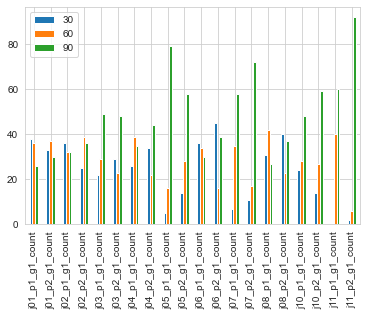

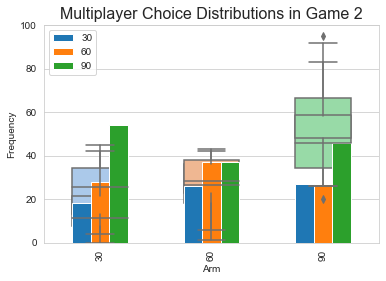

In [297]:
# In[ ]:


j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')


# In[ ]:


#social matching


# In[ ]:


j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, 
                            j03_p1_g2_count, j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count,
                           j05_p1_g2_count,j05_p2_g2_count, j06_p1_g2_count, j06_p2_g2_count, j07_p1_g2_count, 
                            j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count],
                          index=['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                            'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count',
                           'j05_p1_g2_count','j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                            'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count'])


# In[ ]:


j_g2_counts


# In[ ]:


#j_60_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,1],j_g2_counts.iloc[:,1])


# In[ ]:


#j_60_p


# In[ ]:


#j_30_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,0],j_g2_counts.iloc[:,0])


# In[ ]:


j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])

j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])


# In[ ]:


j_g2_low


# In[ ]:


j_g2_med


# In[ ]:


j_g2_high


# In[ ]:


j_g1_counts_bar = j_g1_counts.plot.bar()


# In[ ]:


j_g2_counts_bar = j_g2_counts.plot.bar()


# In[ ]:


j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"

plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:


j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"

plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:

# Maximizing and Matching Strategies

In [298]:
#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.


# In[ ]:


s_g1_counts


# In[ ]:


s_g1_counts


# In[ ]:


j_g1_counts


# In[ ]:


j_g2_counts


# In[ ]:


#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://urldefense.com/v3/__https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX94Xg7JRI$ . *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://urldefense.com/v3/__https://en.wikipedia.org/wiki/Jensen**BShannon_divergence__;4oCT!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9SSBIvMc$ 
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.


# In[ ]:


#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2


# In[ ]:


#Idealized probability distributions to use for comparison. You can change these or add more models.
maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,50]


# In[ ]:


#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize)
    matchi = jsd(counts,match)
    return maxi,matchi


# In[ ]:


j01_p1_g1_count


# In[ ]:


#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate.

social_max = [0, 100, 0]
social_match = [30/180 * 100,30/180 * 100, 30/180 * 100]


# In[ ]:


#Calls jsd with the social distributions.
def call_jsd_social(counts):
    maxi = jsd(counts,social_max)
    matchi = jsd(counts,social_match)
    return maxi,matchi


# In[ ]:


s01_p1_g1_count


# In[ ]:


from scipy import stats


# In[ ]:


#if same, 0
test = jsd(maximize,match)


# In[ ]:


test


# In[ ]:


s01 = 'match'


# In[ ]:


s05_p1_g2_count


# In[ ]:


s05_p1_g2_count = [11,0,89]


# In[ ]:


# some add to 80, some add to 81??
s_g1_counts




,30.0,60.0,90.0
s01_p1_g1_count,38,43,19
s03_p1_g1_count,28,38,34
s05_p1_g1_count,11,35,54
s06_p1_g1_count,11,13,76
s07_p1_g1_count,25,29,46
s08_p1_g1_count,2,6,92
s09_p1_g1_count,17,38,45
s11_p1_g1_count,30,34,36
s12_p1_g1_count,7,28,65
s14_p1_g1_count,2,1,97


In [299]:
# In[ ]:


#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match = call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match = call_jsd(s05_p1_g2_count)
s06_g1_max,s06_g1_match = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match = call_jsd(s06_p1_g1_count)
s07_g1_max,s07_g1_match = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match = call_jsd(s12_p1_g2_count)
s15_g1_max,s15_g1_match = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match = call_jsd([0.0, 3.0, 78.0])
s17_g2_max,s17_g2_match = call_jsd([0, 19, 62])
s19_g1_max,s19_g1_match = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match = call_jsd(s20_p1_g2_count)


# In[ ]:


s17_p1_g1_count


# In[ ]:


s17_p1_g2_count


# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
s_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, s19_g1_max, s20_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, s20_g1_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])


# In[ ]:


#closer to 0 = closer to that pure strategy
s_jsd_g1


# In[ ]:


#Create a dataframe for single player game 2 jsd scores, with a column for each strategy.'''
s_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, s19_g2_max, s20_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, s20_g2_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])

In [300]:
# In[ ]:


def check_type(df,*social):
    types = pd.DataFrame(index=['type'])
    for index,row in df.iterrows():
        maxi = row["max"]
        matchi = row["match"]
        print(index,maxi,matchi)
        if maxi < matchi:
            print('maxi')
            types = types.append({'type' : 'maxi'},ignore_index=True)
            #types[index,'type'] = 'max'
            num = maxi
        elif matchi < maxi:
            print('matchi')
            types = types.append({'type' : 'matchi'},ignore_index=True)
            num = matchi
        else:
            types = types.append({'type' : 'neither'},ignore_index=True)
            num = 1
        if social == True:
            if num >= jsd(social_max,social_match):
                types = types.append({'type' : 'neither'},ignore_index=True)
        else:
            if num >= jsd(maximize,match):
                types = types.append({'type' : 'neither'},ignore_index=True)
    return types


# In[ ]:


s_types_g1 = check_type(s_jsd_g1)


# In[ ]:


s_types_g2 = check_type(s_jsd_g2)


# In[ ]:


#add label, make sure in correct order
s_types_g1.drop([0])


# In[ ]:


s_types_g2.drop([0])


# In[ ]:


#how different max and match dists are from eachother
#neither max or match(?)
threshold = jsd(maximize,match)


# In[ ]:


threshold


# In[ ]:


s_jsd_g1


# In[ ]:


s_jsd_g2

s01 0.4318754981734429 0.06054148947299787
matchi
s03 0.3136608967716278 0.015697836724085833
matchi
s05 0.19430446226785061 0.0034085885935871106
matchi
s06 0.09138502722922329 0.03951762558866109
matchi
s07 0.23828696089939724 0.0053654131945676635
matchi
s08 0.0285594618498793 0.11676336139531006
maxi
s09 0.24409937049739652 0.0014302350058570182
matchi
s11 0.30016036017557546 0.015397423641056673
matchi
s12 0.1400031203020941 0.01623165498296157
matchi
s15 0.08306135620297604 0.04576596686818012
matchi
s16 0.30016036017557546 0.011028978242923135
matchi
s17 0.01301077227129638 0.16318633737131052
maxi
s19 0.17884892768841604 0.006669897415355728
matchi
s20 0.33696362490947884 0.019880323589985344
matchi
s01 0.23828696089939724 0.03734820425576257
matchi
s03 0.24998841732128801 0.007883430429554528
matchi
s05 0.03972452885343111 0.1461736151764258
maxi
s06 0.09138502722922329 0.03951762558866109
matchi
s07 0.21576155433883565 0.0001962686894984066
matchi
s08 0.09138502722922329 0.03

,max,match
s01,0.238287,0.037348
s03,0.249988,0.007883
s05,0.039725,0.146174
s06,0.091385,0.039518
s07,0.215762,0.000196
s08,0.091385,0.037151
s09,0.221288,0.001084
s11,0.262006,0.009448
s12,0.043505,0.095303
s15,0.035974,0.101856


In [301]:
# In[ ]:


#Call 'call_jsd' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match = call_jsd([0,6,74])
j11_p1_g2_max,j11_p1_g2_match = call_jsd([0,6,74])
j11_p2_g1_max,j11_p2_g1_match = call_jsd([0,6,74])
j11_p2_g2_max,j11_p2_g2_match = call_jsd([0,6,74])


# In[ ]:


#Create a dataframe for joint game 1 jsd scores, with a column for each strategy.'''
j_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max,j10_p1_g1_max,j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])


# In[ ]:


#Create a dataframe for joint game 2 jsd scores, with a column for each strategy.'''
j_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max,j10_p1_g2_max,j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match,j10_p1_g2_match,
                              j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])


# In[ ]:


j_types_g1 = check_type(j_jsd_g1)


# In[ ]:


j_types_g2 = check_type(j_jsd_g2)


# In[ ]:


j_types_g1.drop([0])


# In[ ]:


j_types_g2.drop([0])


# In[ ]:


j_jsd_g1


# In[ ]:


j_jsd_g2


# In[ ]:


#same for joint using "social"

j01 0.37242722211735246 0.040908395510238574
matchi
j01 0.3420144880071857 0.026793253013230066
matchi
j02 0.3276007490949424 0.028191250575098234
matchi
j02 0.30016036017557546 0.011028978242923135
matchi
j03 0.22128824866172742 0.002623936882068798
matchi
j03 0.2268834335864397 0.013299200569501346
matchi
j04 0.3068577088686985 0.012909072374830417
matchi
j04 0.24998841732128801 0.021930764983990762
matchi
j05 0.07895387905098877 0.048562468411548376
matchi
j05 0.17381067052114874 0.003224168082350133
matchi
j06 0.3420144880071857 0.030814349065625385
matchi
j06 0.2806674110234412 0.05276204892546748
matchi
j07 0.17381067052114874 0.011749975387766832
matchi
j07 0.10848682634020129 0.026388230577774827
matchi
j08 0.3646114505633699 0.030882071491651487
matchi
j08 0.2935651532009069 0.03438923030930108
matchi
j10 0.2268834335864397 0.004587099460795689
matchi
j10 0.16882697874109426 0.004105486419217843
matchi
j11 0.026723723680696507 0.13408494168579138
maxi
j11 0.026723723680696507 

,max,match
j01,0.194304,0.001674
j01,0.293565,0.010498
j02,0.238287,0.008254
j02,0.140003,0.012990
j03,0.117277,0.023303
j03,0.062871,0.071617
j04,0.372427,0.047613
j04,0.422810,0.059473
j05,0.140003,0.023492
j05,0.199575,0.011901


In [302]:
# In[ ]:


#Call 'call_jsd_social' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd_social(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd_social(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd_social(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd_social(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd_social(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd_social(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd_social(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd_social(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd_social(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd_social(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd_social(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd_social(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd_social(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd_social(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd_social(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd_social(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd_social(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd_social(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd_social(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd_social(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd_social(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd_social(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd_social(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd_social(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd_social(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd_social(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd_social(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd_social(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd_social(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd_social(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd_social(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd_social(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd_social(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd_social(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd_social(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd_social(j10_p2_g2_count)
#j11 not working
#j11_p1_g1_max,j11_p1_g1_match = call_jsd_social(j11_p1_g1_count)
#j11_p1_g2_max,j11_p1_g2_match = call_jsd_social(j11_p1_g2_count)
#j11_p2_g1_max,j11_p2_g1_match = call_jsd_social(j11_p2_g1_count)
#j11_p2_g2_max,j11_p2_g2_match = call_jsd_social(j11_p2_g2_count)

In [303]:
# In[ ]:


#Create a dataframe for joint game 1 social jsd scores, with a column for each strategy.'''
j_jsd_g1_social = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10'])


# In[ ]:


#Create a dataframe for joint game 2 social jsd scores, with a column for each strategy.'''
j_jsd_g2_social = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08'])


# In[ ]:


j_jsd_g1_social = check_type(j_jsd_g1_social,True)


# In[ ]:


j_jsd_g2_social = check_type(j_jsd_g2_social,True)


# In[ ]:


#j_jsd_g1_social.drop([0])

j_jsd_g1_social


# In[ ]:


j_jsd_g2_social


# In[ ]:

j01 0.3001603601755753 0.0032919808600490354
matchi
j01 0.2935651532009069 0.0009210866283259119
matchi
j02 0.32760074909494247 0.0003925373789966432
matchi
j02 0.2806674110234412 0.004353839692670397
matchi
j03 0.34941116808875117 0.014096617199095787
matchi
j03 0.3968207298318064 0.012167655443583163
matchi
j04 0.2806674110234412 0.0034843272640260412
matchi
j04 0.40529410613611927 0.009550899789536379
matchi
j05 0.46045706049148205 0.12197576718987321
matchi
j05 0.3569415360699646 0.03835499756116475
matchi
j06 0.3136608967716278 0.0007117746385332316
matchi
j06 0.46045706049148205 0.021026200095421166
matchi
j07 0.30685770886869845 0.06368498543923984
matchi
j07 0.45068365594208204 0.07927854680582927
matchi
j08 0.2620056824966033 0.0043748997445118235
matchi
j08 0.39682072983180644 0.00676094207691845
matchi
j10 0.35694153606996454 0.01162462426637402
matchi
j10 0.3646114505633699 0.04007019706990854
matchi
j01 0.3569415360699646 0.025130966500317167
matchi
j01 0.2935651532009069 

,type
0,NaN
1,matchi
2,matchi
3,matchi
4,matchi
5,matchi
6,matchi
7,matchi
8,matchi
9,matchi


In [304]:
threshold


# In[ ]:


import matplotlib.lines as mlines


# In[ ]:


#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              


# In[ ]:


import itertools


# In[ ]:


#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
colors_jsd_j = ['red','lightcoral','orange','darkorange','green','palegreen',
              'blue','darkblue','hotpink','pink','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_s_g1 = ['red','orange','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
colors_jsd_s_g2 = ['red','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
          'o','v','o','v','o','v','o','v']


# In[ ]:


#Here I print the means of the JSD values in each condition, just to see what they are.'''


# In[ ]:


#run t test to see sig between max and match per game
#put in box plot
s_jsd_g1.mean()


# In[ ]:


s_jsd_g2.mean()


# In[ ]:


j_jsd_g1.mean()


# In[ ]:


j_jsd_g2.mean()


# In[ ]:

max      0.168643
match    0.042691
dtype: float64